## Deliverables for Team Whiskerboard
1. Presentation slides:
2. Video: 

## Dependencies

In [ ]:
# GPT Neo
!pip install transformers
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
import torch 
import numpy as np
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
torch.cuda.is_available()
model = model.to('cuda')

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 32.5 MB/s 
     |████████████████████████████████| 6.6 MB 25.8 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 880 kB 41.2 MB/s 
     |████████████████████████████████| 96 kB 3.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=6fb2977f2eea13a65818a48e55c34e8bd0bdd9c04f513db885104dd216b04ea5
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into a

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [ ]:
# Download the large spacy model and import spacy
!python -m spacy download en_core_web_lg
import spacy
from spacy import displacy
import en_core_web_lg
nlp = en_core_web_lg.load()

# nlp = spacy.load("en_core_web_sm")

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=bf9c813991083b7e5a24d3a8800b9ee96e8a3058969453d270fed6f30cdf7dd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fl_c3gq/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# VerbNet
import nltk
vn = nltk.download('verbnet')
from nltk.corpus import verbnet as vn
import re
import json

[nltk_data] Downloading package verbnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/verbnet.zip.


In [ ]:
# Display
!pip install networkx
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## Spacy and NER

In [ ]:
# Classes for spacy relations

# A relation between a subject and a direct object.
class Relation:
  def __init__(self, relation="", subjs=[], dobjs=[], NOT=False):
    self.relation = relation
    self.subjs = list(subjs)
    self.dobjs = list(dobjs)
    self.NOT = NOT

  # String representation.
  def __str__(self): 
    txt = ""
    if self.NOT:
      txt += "(NOT)"
    txt += str(self.subjs) + " " + self.relation + " " + str(self.dobjs)
    return txt

  # Alternate string representation.
  def __repr__(self):
    return str(self)

# Holds the relations extracted from a sentence in the context of a larger text.
class SentenceRelations:
  def __init__(self, span, curr_subj="", curr_dobj=""):
    self.span = span
    self.text = span.text
    self.disambiguated_text = ""
    self.curr_subj = curr_subj
    self.curr_dobj = curr_dobj
    self.relations = {}
    self.disambiguations = {}
    self.get_relations()
    self.relation_tuples = []
    self.make_tuples()  
    self.disambiguate()

  # Iterate over the noun chunks of the sentence and call submethods based on 
  # the dep_; then fill in guesses for pronouns and negate relations with a 
  # negation modifier.
  def get_relations(self):
    for noun_chunk in self.span.noun_chunks:
      root = noun_chunk.root
      if root.dep_ == "nsubj":
        self.add_nsubj_relation(noun_chunk)
      elif root.dep_ in ["attr", "dobj"] and root.head.pos_ in ["VERB", "AUX"]:
        # HAS and IS are labeled as AUX and the object of IS is labeled as ATTR
        # To capture these relations, we look for all versions.
        self.add_dobj_relation(noun_chunk)
      elif root.dep_ == "conj" and not self.is_pron(root):
        self.add_conj_relation(noun_chunk)
      if noun_chunk.start not in self.disambiguations:
        # A relationship was not found, but we still need to disambiguate,
        # so we guess at using the current subject if it is a pronoun. 
        disambiguated_entity = self.get_entity_label(noun_chunk)
        if disambiguated_entity == "":
          disambiguated_entity = self.curr_subj
        self.disambiguations[noun_chunk.start] = disambiguated_entity

    self.guess_subjects()
    self.get_negations()

  # Add a relation with the noun chunk as the subject and
  # a verb as the relation.
  def add_nsubj_relation(self, noun_chunk):
    relation = noun_chunk.root.head
    if relation.pos_ in ["VERB", "AUX"]:
      self.add_nsubj(relation, noun_chunk)
  
  # Add a relation with the noun chunk as the direct object.
  def add_dobj_relation(self, noun_chunk):
    relation = noun_chunk.root.head
    self.add_dobj(relation, noun_chunk)

  # Add a relation for a conjugate (a word related to a subject or direct object
  # with 'and'. Each subject and object will be separately related.)
  def add_conj_relation(self, noun_chunk):
    root = noun_chunk.root
    for sibling in root.conjuncts:
      relation = sibling.head
      if sibling.dep_ == "nsubj" and relation.pos_ in ["VERB", "AUX"]:
        self.add_nsubj(relation, noun_chunk)    
      elif sibling.dep_ == "dobj" and relation.pos_ == "VERB":
        self.add_dobj(relation, noun_chunk)

  # Add a subject relation.
  def add_nsubj(self, relation, noun_chunk):
    entity_label = self.get_entity_label(noun_chunk)
    if entity_label != "":
      # Update the current subject of the text.
      self.curr_subj = entity_label
    
    rel_label = self.get_relation_label(relation)
    if relation.i not in self.relations:
      self.relations[relation.i] = Relation(relation=rel_label, subjs=[self.curr_subj])
    else:
      self.relations[relation.i].subjs.append(self.curr_subj)
    self.disambiguations[noun_chunk.start] = self.curr_subj

  # Add a direct object relation.
  def add_dobj(self, relation, noun_chunk):
    entity_label = self.get_entity_label(noun_chunk)
    if entity_label != "":
      # Update the current object of the text.
      self.curr_dobj = entity_label
    
    rel_label = self.get_relation_label(relation)
    if relation.i not in self.relations:
      self.relations[relation.i] = Relation(relation=rel_label, dobjs=[self.curr_dobj])
    else:
      self.relations[relation.i].dobjs.append(self.curr_dobj)
    self.disambiguations[noun_chunk.start] = self.curr_dobj

  # Get the label for a relation. Auxiliaries (e.g 'is', 'was', etc.) are given
  # 'IS'
  def get_relation_label(self, relation):
    return relation.lemma_

  # Get the label for an entity. 
  # Remove determinative ('a', 'the') and adjectives,
  # and use all uppercase to standardize entity names.
  def get_entity_label(self, noun_chunk):
    root = noun_chunk.root
    label = ""
    if root.pos_ == "PRON":
      if root.text in ["I", "me"]:
        label = "I"
      elif root.text in ["we", "us"]:
        label = "WE"
      # Other pronoun labels are left as "" and will be filled in
      # with the current tracked dobj/nsubj entity.
    else:
      label = ""
      for token in noun_chunk:
        if token.pos_ not in ["DET", "ADJ"]:
          label += token.text + " "
    return label.strip().upper()
  
  # Determine whether a word is a pronoun.
  # We don't consider 'I' words as pronouns because 'I' and 'WE' 
  # are subjects that don't usually have an entity to replace with.
  def is_pron(self, root):
    return root.pos_ == "PRON" and not (root.text in ["I", "me", "we", "us"])

  # Guess the subject of a relation that doesn't have an nsubj.
  def guess_subjects(self):
    rel_idx = list(self.relations)
    rel_idx.sort()
    for i, rel_i in enumerate(rel_idx):
      if len(self.relations[rel_i].subjs) == 0:
        if i > 0:
          # Give it the previous verb's subject.
          self.relations[rel_i].subjs = self.relations[rel_idx[i-1]].subjs
        else:
          # Find the first verb in the sentence with a subject.
          for j, rel_j in enumerate(rel_idx):
            if len(self.relations[rel_j].subjs) > 0:
              self.relations[rel_i].subjs = self.relations[rel_j].subjs
              break
        if len(self.relations[rel_i].subjs) == 0 and self.curr_subj != "":
          # If there still isn't a subject, try the curr_subj.
          self.relations[rel_i].subjs = [self.curr_subj]

  # Negate relations with a negation modifier.
  def get_negations(self):
    for token in self.span:
      if token.dep_ == "neg" and token.head.i in self.relations:
        self.relations[token.head.i].NOT = True

  # Replace all noun chunks in the text with their disambiguated entity labels.
  def disambiguate(self):
    text_array = []
    for token in self.span:
      text = token.text
      text_array.append(token.text + token.whitespace_)
    offset = -self.span.start
    for noun_chunk in self.span.noun_chunks:
      disambiguation = self.disambiguations[noun_chunk.start]
      start = offset + noun_chunk.start
      end = offset + noun_chunk.end
      text_array[start:end] = [disambiguation + ' ']
      offset -= len(noun_chunk) - 1
    self.disambiguated_text = self.disambiguated_text.join(text_array)

  # Translate relations into tuples of the form subj, relation, dobj.
  # Where there isn't a subj or dobj, skip.
  def make_tuples(self):
    rel_idx = list(self.relations)
    rel_idx.sort()
    for ri in rel_idx:    
      relation = self.relations[ri]
      for subj in relation.subjs:
        for dobj in relation.dobjs:
          tup = (subj, relation.relation, dobj)
          if relation.NOT:
            tup = ('NOT', tup)
          self.relation_tuples.append(tup)


  # String representation.
  def __str__(self): 
    txt = self.text + "\n->" + self.disambiguated_text + "\n"
    txt += str(self.relation_tuples)
    return txt

  # Alternate string representation.
  def __repr__(self):
    return str(self)

  # Debugging output.
  def debug(self):
    print(self.text + "\n->" + self.disambiguated_text)
    rel_idx = list(self.relations)
    rel_idx.sort()
    for ri in rel_idx:      
      print(self.relations[ri])

# Holds the relations for a text.
class TextRelations:
  def __init__(self, text=""):
    self.text = "" # The text so far.
    self.relations_by_sentence = [] # The relations added and which sentence they belong to.
    self.curr_subj = "" # The current tracked subject of the text.
    self.curr_dobj = "" # The current tracked direct object of the text.
    self.append(text)

  # Get new relations without changing any data structures (useful for scoring).
  def forecast(self, text):
    doc = nlp(text)
    new_relations = []
    # Get new relations extracted from each sentence in the new text.
    curr_subj = self.curr_subj
    curr_dobj = self.curr_dobj
    for sentence in doc.sents:
      sent_relations = SentenceRelations(sentence, curr_subj, curr_dobj)
      new_relations.append(sent_relations)
      curr_subj = sent_relations.curr_subj
      curr_dobj = sent_relations.curr_dobj
    return new_relations, curr_subj, curr_dobj

  # Append to the current text, and return all NEW relations
  def append(self, text):
    self.text += text
    new_relations, curr_subj, curr_dobj = self.forecast(text)
    self.curr_subj = curr_subj
    self.curr_dobj = curr_dobj
    self.relations_by_sentence += new_relations
  
  # String representation.
  def __str__(self): 
    txt = self.text + "\n\n"
    for sentence_relations in self.relations_by_sentence:    
      txt += str(sentence_relations) + "\n"
    return txt
  
  # Alternate string representation.
  def __repr__(self):
    return str(self)

  # Debugging output.
  def debug(self):
    print(self.text)
    for sentence_relations in self.relations_by_sentence:    
      sentence_relations.debug()

### Examples

In [ ]:
# Example Spacy relations.
relations = TextRelations("Sally was not a cook; Sally was a baker, but she was out of flour and eggs, so she went to the store to buy some. At the store, there was flour but no eggs, so she bought a cakemix instead. She went home and baked a cake with the cakemix. Emma, Amy, and Mark bought apples, oranges, and pears.")
print(relations)
relations.debug()

Sally was not a cook; Sally was a baker, but she was out of flour and eggs, so she went to the store to buy some. At the store, there was flour but no eggs, so she bought a cakemix instead. She went home and baked a cake with the cakemix. Emma, Amy, and Mark bought apples, oranges, and pears.

Sally was not a cook; Sally was a baker, but she was out of flour and eggs, so she went to the store to buy some.
->SALLY was not COOK ; SALLY was BAKER , but SALLY was out of FLOUR and EGGS , so SALLY went to STORE to buy some. 
[('NOT', ('SALLY', 'be', 'COOK')), ('SALLY', 'be', 'BAKER')]
At the store, there was flour but no eggs, so she bought a cakemix instead.
->At STORE , there was FLOUR but EGGS , so SALLY bought CAKEMIX instead. 
[('SALLY', 'be', 'FLOUR'), ('SALLY', 'buy', 'CAKEMIX')]
She went home and baked a cake with the cakemix.
->SALLY went home and baked CAKE with CAKEMIX . 
[('SALLY', 'bake', 'CAKE')]
Emma, Amy, and Mark bought apples, oranges, and pears.
->EMMA , AMY , and MARK bou

## VerbNet and NLTK

Reference: 
1. https://www.nltk.org/howto/corpus.html#verbnet
2. https://nbviewer.org/url/lope.linguistics.ntu.edu.tw/courses/python4nlp/week6-2.Working.with.Lexical.Data.2.ipynb
3. https://verbs.colorado.edu/~kipper/Papers/dissertation.pdf

In [ ]:
def extract_verb_from_relation(t):
  """
  Given a tuple of the form (subject, verb, object), return the verb
  """
  # Relations with NOT are nested relations
  if t[0] == 'NOT':
    return t[1][1]

  return t[1]

In [ ]:
def lemma_to_id(lemma, all_classes=False):
  """
  Given the verb lemma, find the class id
  Args:
        lemma: the verb lemma whose VerbNet id we want to find
        all_classes: indicates whether we want to fetch all the classids for that verb.
                     If False, we just return the id containing that verb lemma
  Returns:string (list of strings)          
  """
  class_ids = vn.classids(lemma)
  if all_classes:
    return class_ids

  # If the lemma is not present in VerbNet, return it as is
  if len(class_ids) == 0:
    return lemma
  # If there is only one corresponding class record in VerbNet, return that
  if len(class_ids) == 1:
    return class_ids[0]
  # If there are multiple class records, return the one which has the same lemma in the record
  pattern = '^' + lemma
  for id in class_ids:
    if re.match(pattern, id):
      return id
  # Return the first class_id if none of them have the lemma as root.
  # For instance, classids of 'move' are: ['amuse-31.1', 'roll-51.3.1', 'slide-11.2']
  return class_ids[0]


### Example output
print(lemma_to_id('cut', all_classes=True))
print(lemma_to_id('bake'))

  

['amuse-31.1', 'braid-41.2.2', 'build-26.1-1', 'cut-21.1-1', 'hurt-40.8.3-2', 'meander-47.7', 'split-23.2']
build-26.1


In [ ]:
def replace_with_vn_class(relation):
  """
  Given a relation in the form of (subject, verb, object) or (NOT, (subject, verb, object)), 
  replace the verb with its VerbNet class id
  """
  lemma = extract_verb_from_relation(relation)
  verb_class = lemma_to_id(lemma)

  # Handle nested NOT relations
  if relation[0] == 'NOT':
    new_relation = ('NOT', (relation[1][0], verb_class, relation[1][2]))
  else:
    new_relation = (relation[0], verb_class, relation[2])

  return new_relation



### Example output
print(replace_with_vn_class(('NOT', ('SALLY', 'bake', 'cake'))))


('NOT', ('SALLY', 'build-26.1', 'cake'))


### Examples

In [ ]:
# Class id for a particular verb
c = vn.classids('be')
print(c)

[]


In [ ]:
# Lemmas for a particular class id
c = vn.lemmas('meander-47.7')
print (c)

['cascade', 'climb', 'crawl', 'cut', 'drop', 'go', 'meander', 'plunge', 'run', 'straggle', 'stretch', 'sweep', 'tumble', 'turn', 'twist', 'wander', 'weave', 'wind', 'range', 'swerve', 'veer']


In [ ]:
### Print frames and thematic roles of a verb class
id = 'run-51.3.2'
themroles = vn.themroles(id)
print(json.dumps(themroles, indent=2))
print('\n')

frames = vn.frames(id)
print(json.dumps(frames, indent=2))

[
  {
    "type": "Agent",
    "modifiers": [
      {
        "value": "+",
        "type": "animate"
      }
    ]
  },
  {
    "type": "Theme",
    "modifiers": [
      {
        "value": "+",
        "type": "animate"
      },
      {
        "value": "+",
        "type": "machine"
      }
    ]
  },
  {
    "type": "Location",
    "modifiers": [
      {
        "value": "+",
        "type": "concrete"
      }
    ]
  }
]


[
  {
    "example": "The horse jumped.",
    "description": {
      "primary": "Basic Intransitive",
      "secondary": "inchoative"
    },
    "syntax": [
      {
        "pos_tag": "NP",
        "modifiers": {
          "value": "Theme",
          "selrestrs": [],
          "synrestrs": []
        }
      },
      {
        "pos_tag": "VERB",
        "modifiers": {
          "value": "",
          "selrestrs": [],
          "synrestrs": []
        }
      }
    ],
    "semantics": [
      {
        "predicate_value": "motion",
        "arguments": [
          

In [ ]:
### Get the class record for a certain lemma. Class record is stored as an ElementXML Tree
lemma = 'run'

# Get list of all classids the lemma belongs to
class_ids = vn.classids(lemma)

class_records = []
for c in class_ids:
  class_records.append(vn.vnclass(c)) # Get class record of each classid as a ElementTree XML object
  print(vn.pprint(c)) # Pretty print the class_ids

if len(class_records) == len(class_ids):
  print(f'Successfully accessed all the class records of the lemma')
else:
  print(f'Missing class records! \n Length of classids = {len(class_ids)} \n Length of class records = {len(class_records)}')




meander-47.7
  Subclasses: (none)
  Members: cascade climb crawl cut drop go meander plunge run straggle
    stretch sweep tumble turn twist wander weave wind range swerve
    veer
  Thematic roles:
    * Location[+concrete]
    * Theme[+elongated]
  Frames:
    PP (path-PP)
      Example: The river runs through the valley.
      Syntax: NP[Theme] VERB PREP[+path] NP[Location]
      Semantics:
        * Prep(during(E), Theme, Location)
        * exist(during(E), Theme)
    Locative Inversion
      Example: Through the valley meanders the river.
      Syntax: PREP[+path] NP[Location] VERB NP[Theme]
      Semantics:
        * Prep(during(E), Theme, Location)
        * exist(during(E), Theme)
    PP-NP (Expletive-there Subject)
      Example: There meanders through the valley a river.
      Syntax: LEX[there] VERB PREP[+path] NP[Location] NP[Theme]
      Semantics:
        * Prep(during(E), Theme, Location)
        * exist(during(E), Theme)
    NP-PP (Expletive-there Subject)
      Exampl

#### Extracting semantic information from the verbs
We can use the VerbNet class ids of a verb to get more information regarding 
the verb semantics. For instance, _run_ is a motion verb. As a result, it's
thematic roles contain `Location` which indicates that this verb has something to do with the location of the subject. Similarly, it also contains an `Agent` role, which VerbNet defines as a volitional human or animate subject. Put simply, this would be the entity that is performing the _run_ action. A complete list of different VerbNet thematic roles can be found on [this page](https://verbs.colorado.edu/verbnet/) in Table 2.

We have coded the KG in such a manner that the VerbNetClassIds are also stored in it along the edges as attributes. When creating the language model in Part 2 of the project, we can use these class ids to extract semantic information from different verbs and use them to ensure coherence in our model. The following cell illustrates an example of obtaining thematic roles from VerbNet by using the class id.

In [ ]:
id = 'get-13.5.1'
vn_run = vn.vnclass(id)
for themrole in vn_run.findall('THEMROLES/THEMROLE'):
  print(themrole.attrib['type'], end=' ')
  for selrestr in themrole.findall('SELRESTRS/SELRESTR'):
    print('[%(Value)s%(type)s]' % selrestr.attrib, end=' ')
  print()


Agent [+animate] [+organization] 
Theme 
Source [+concrete] 
Beneficiary [+animate] [+organization] 
Asset [-location] [-region] 


## Constructing KG and Visualizing it


In [ ]:
# Use the TextRelations and SentenceRelations classes to make a list of all SVO (sentence, verb, object) tuples 
def extract_relations_from_prompt(prompt):
  relations = TextRelations(prompt)
  list_of_relations = []
  for relations_for_each_sentence in relations.relations_by_sentence:
    for relation in relations_for_each_sentence.relation_tuples:
      list_of_relations.append(relation)
  return list_of_relations

# Find the VerbNet Class ids for the verbs for each of the relations
def combine_verbnet_with_relations(list_of_relations):
  verbnet_list_of_verbs = []
  for relation in list_of_relations:
    lemma = extract_verb_from_relation(relation)
    verb_class = lemma_to_id(lemma)
    verbnet_list_of_verbs.append(verb_class)
  return verbnet_list_of_verbs

# Open the SVO tuple to uniformly create tuples that also capture the NOT relation, and the verbnet class ids
def modify_relations(list_of_relations, verbnet_list_of_verbs):
  relations = []
  for relation, verb in zip(list_of_relations, verbnet_list_of_verbs):
    temp = list(relation)
    if relation[0] == 'NOT':
      temp = list(temp[1])
      temp.append('False')
    else:
      temp.append('True')
    temp.append(verb)
    relations.append(tuple(temp))
  return relations

In [ ]:
#Create a pandas dataframe from the results
def create_dataframe_from_prompt(prompt):
  list_of_relations = extract_relations_from_prompt(prompt)
  verbnet_list_of_verbs = combine_verbnet_with_relations(list_of_relations)
  relations = modify_relations(list_of_relations, verbnet_list_of_verbs)
  df = pd.DataFrame(relations, columns = ['Subject', 'Verb', 'Object', 'TruthValue', 'VerbNetClassId'])
  return df

In [ ]:
#create KG from the pandas dataframe
def create_knowledge_graph_from_dataframe(dataframe, source, target, edges):
  G = nx.from_pandas_edgelist(dataframe, source, target, edges, create_using=nx.MultiDiGraph())
  return G

In [ ]:
#create edge labels which is a dictionary mapping from the (source,target):label
def create_edge_labels(kg_df, G):
  edge_labels = {}
  for sub, obj in zip(kg_df.Subject, kg_df.Object):
    try:
      edge_labels[(sub, obj)] = kg_df[(kg_df.Subject == sub) & (kg_df.Object == obj)].Verb.item()
    except ValueError as e:
      continue
  return edge_labels

#if the truth value is False then the color of the edge should be red
def get_edge_colors(G):
  edge_colors = ['black' if e[2]['TruthValue'] == 'True' else 'red' for e in G.edges.data()]
  return edge_colors

Visualizing a KG for every sentence in the prompt

In [ ]:
def visualize_knowledge_graph_for_each_sentence(prompt):
  sentences = prompt.split(".")
  for sentence in sentences:
    print (sentence)
    kg_df = create_dataframe_from_prompt(sentence)
    G = create_knowledge_graph_from_dataframe(kg_df, source, target, edges)
    plt.figure(figsize=(5,5))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='yellow', edge_color=get_edge_colors(G), width=1, linewidths=1,
        node_size=2000, alpha = 0.9, edge_cmap=plt.cm.Blues, pos = pos)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = create_edge_labels(kg_df, G),  font_color='green')
    plt.show()

Visualizing KG for the entire prompt

In [ ]:
#visualise the the KG by drawing the nodes, edges and then labeling them
def visualize_knowledge_graph_entire_prompt(prompt):
  kg_df = create_dataframe_from_prompt(prompt)
  G = create_knowledge_graph_from_dataframe(kg_df, source, target, edges)
  plt.figure(figsize=(12,12))
  pos = nx.spring_layout(G)
  nx.draw(G, with_labels=True, node_color='yellow', edge_color=get_edge_colors(G), width=1, linewidths=1,
      node_size=2000, alpha = 0.9, edge_cmap=plt.cm.Blues, pos = pos)
  nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = create_edge_labels(kg_df, G),  font_color='green')
  plt.show()

In [ ]:
# Hold all the information for a knowledge graph.
class KnowledgeGraph:

  # Init with a starting piece of text (the initial prompt).
  def __init__(self, text=""):
    self.text = ""                            # The text so far.
    self.spacy_relations = TextRelations("")  # Relations gathered from spacy
    self.dataframe = 0                        # The relations as a dataframe
    self.relations = []                       # The relations as tuples
    self.append(text)

  # "Forecast" changes to the KG from a piece of text without keeping the 
  # changes in the KG (useful for scoring).
  def forecast(self, text):
    self.text += text
    forecasted_relations = []
    new_relations_by_sentence, _, _ = self.spacy_relations.forecast(text) # SentenceRelations for the new text.
    for sent_relations in new_relations_by_sentence:
      for relation in sent_relations.relation_tuples:
        forecasted_relations.append(relation)
    verbnet_list_of_verbs = combine_verbnet_with_relations(forecasted_relations)
    forecasted_relations = modify_relations(forecasted_relations, verbnet_list_of_verbs)
    forecasted_relations = self.relations + forecasted_relations
    forecasted_dataframe = pd.DataFrame(forecasted_relations, columns = ['Subject', 'Verb', 'Object', 'TruthValue', 'VerbNetClassId'])
    return new_relations_by_sentence, forecasted_relations, forecasted_dataframe

  # Change the KG with added text.
  def append(self, text):
    self.spacy_relations.append(text)
    _, forecasted_relations, forecasted_dataframe = self.forecast(text)
    self.relations = forecasted_relations
    self.dataframe = forecasted_dataframe
    self.dataframe = self.dataframe.drop_duplicates()

  # Visualize the KG.
  def visualize(self):
    source = 'Subject'
    target = 'Object'
    edges = ['Verb', 'TruthValue', 'VerbNetClassId']
    G = create_knowledge_graph_from_dataframe(self.dataframe, source, target, edges)
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='yellow', edge_color=get_edge_colors(G), width=1, linewidths=1,
      node_size=2000, alpha = 0.9, edge_cmap=plt.cm.Blues, pos = pos)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = create_edge_labels(self.dataframe, G),  font_color='green')
    plt.show()

  # String representation.
  def __str__(self): 
    kg_as_text = ""
    for _, relation in self.dataframe.iterrows():
      subj = relation['Subject']
      truth = 'not'
      if relation['TruthValue']:
        truth = ''
      verb = relation['Verb']
      obj = relation['Object']

      kg_as_text += '{subj} {truth} {verb} {obj}.'.format(subj=subj, truth=truth, verb=verb, obj=obj)
    return kg_as_text



### Examples

In [ ]:
prompt = "Sally was not a cook; Sally was a baker, but she was out of flour and eggs, so she went to the store to buy some. At the store, there was flour but no eggs, so she bought a cakemix instead. She went home and baked a cake with the cakemix. Mark bought apples, oranges and pears. "

In [ ]:
kg_df = create_dataframe_from_prompt(prompt)
print (kg_df)  

  Subject  Verb   Object TruthValue VerbNetClassId
0   SALLY    be     COOK      False             be
1   SALLY    be    BAKER       True             be
2   SALLY    be    FLOUR       True             be
3   SALLY   buy  CAKEMIX       True     get-13.5.1
4   SALLY  bake     CAKE       True     build-26.1
5    MARK   buy   APPLES       True     get-13.5.1
6    MARK   buy  ORANGES       True     get-13.5.1
7    MARK   buy    PEARS       True     get-13.5.1


In [ ]:
source = 'Subject'
target = 'Object'
edges = ["Verb", "TruthValue", 'VerbNetClassId']
G = create_knowledge_graph_from_dataframe(kg_df, source, target, edges)

Sally was not a cook; Sally was a baker, but she was out of flour and eggs, so she went to the store to buy some


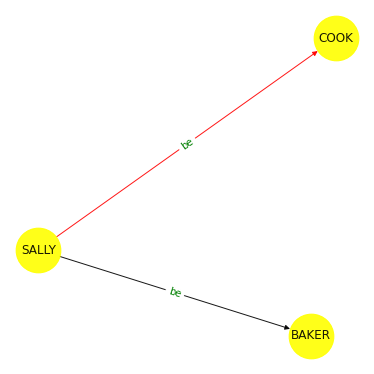

 At the store, there was flour but no eggs, so she bought a cakemix instead


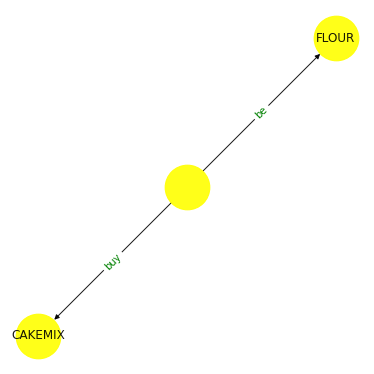

 She went home and baked a cake with the cakemix


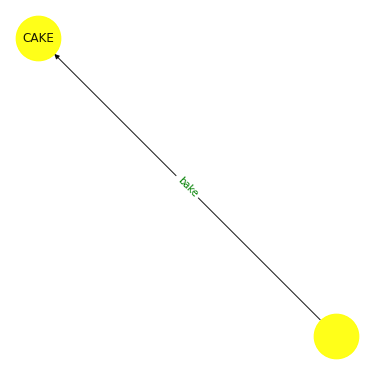

 Mark bought apples, oranges and pears


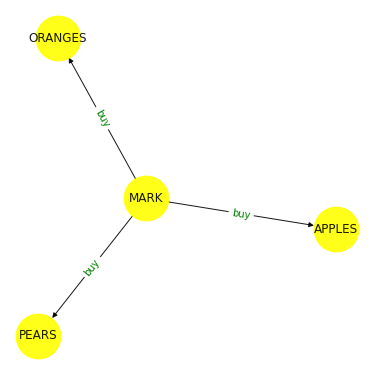

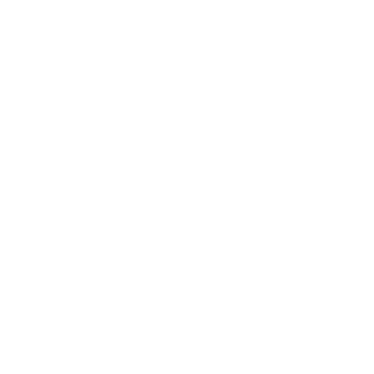

In [ ]:
visualize_knowledge_graph_for_each_sentence(prompt)

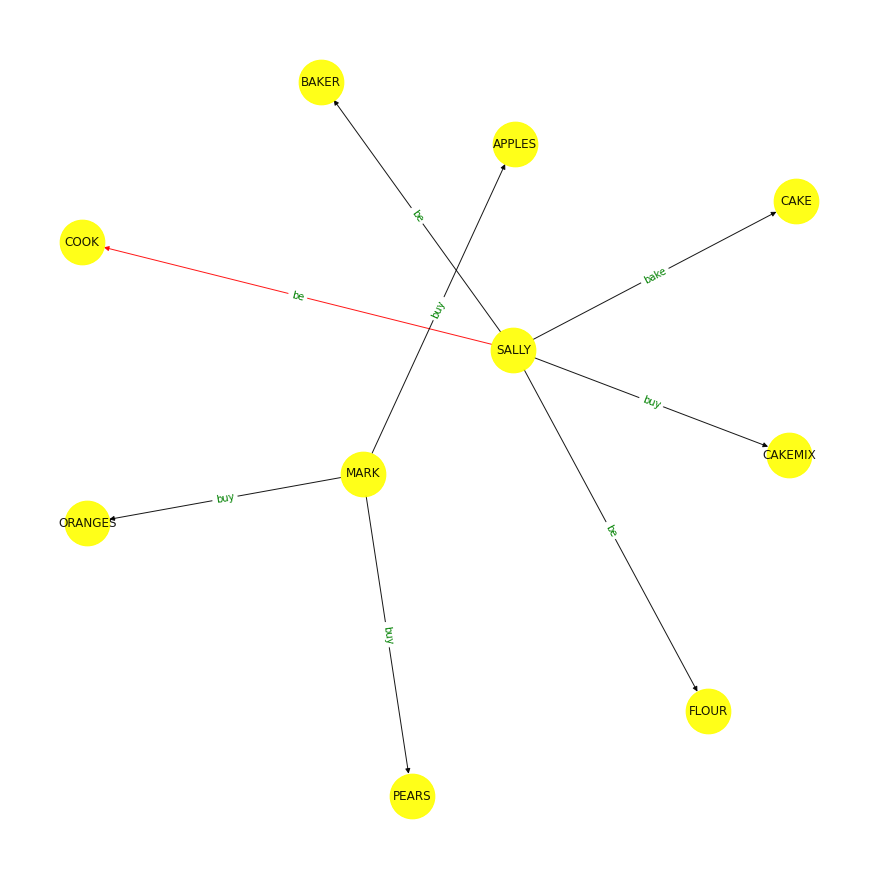

In [ ]:
visualize_knowledge_graph_entire_prompt(prompt)

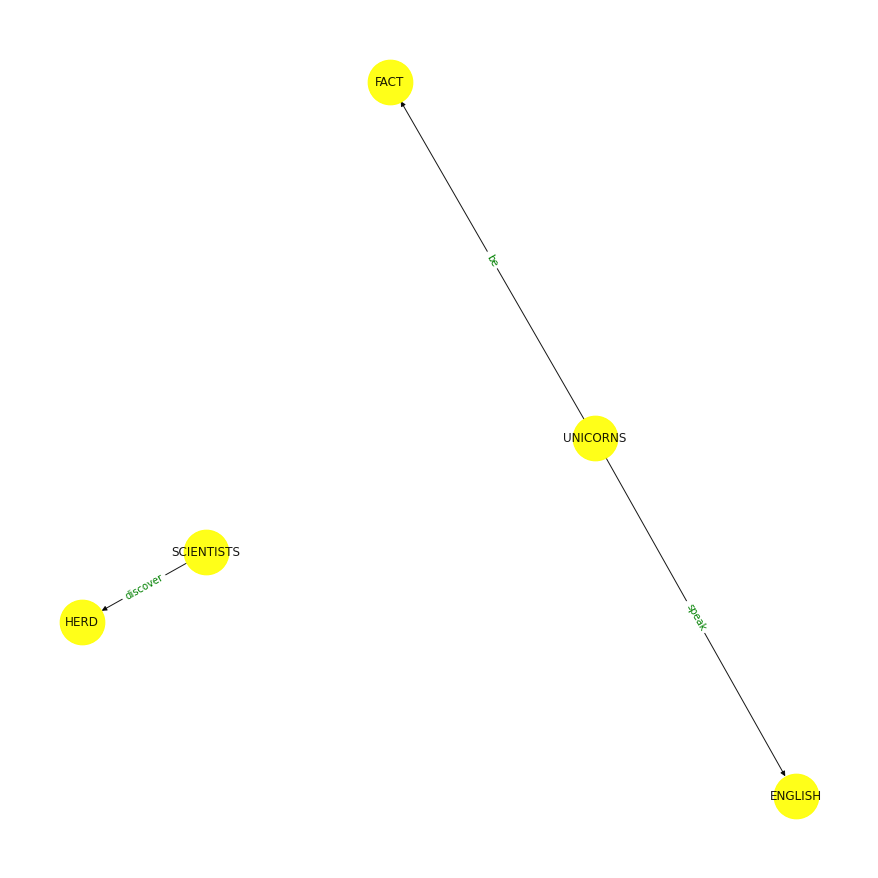

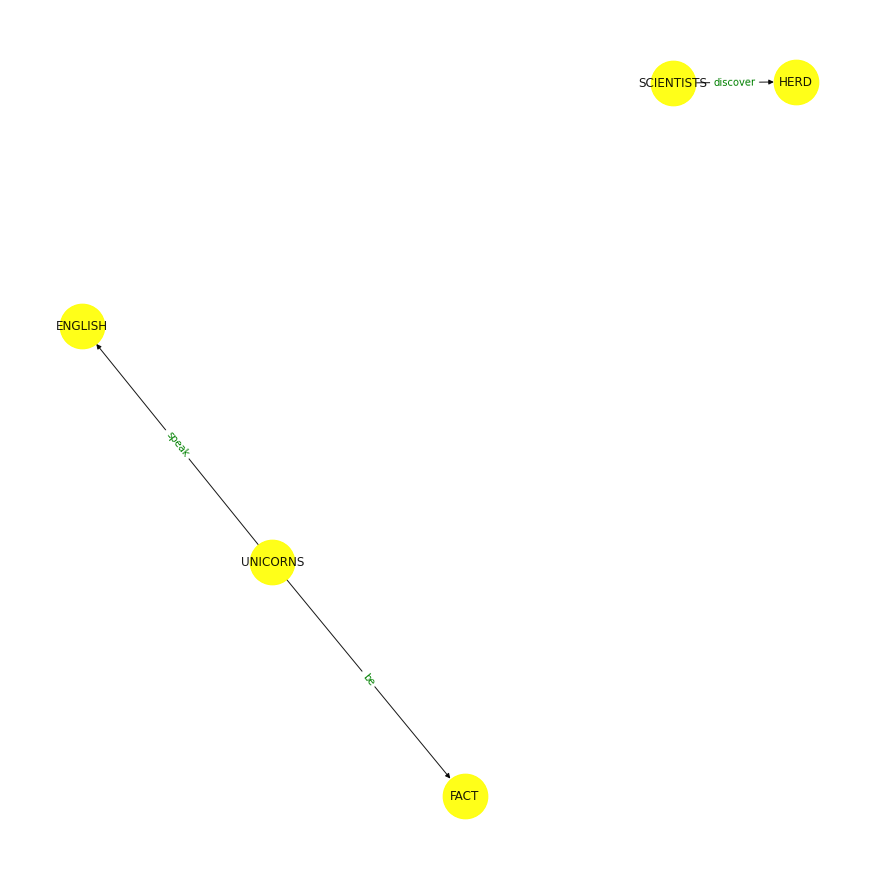

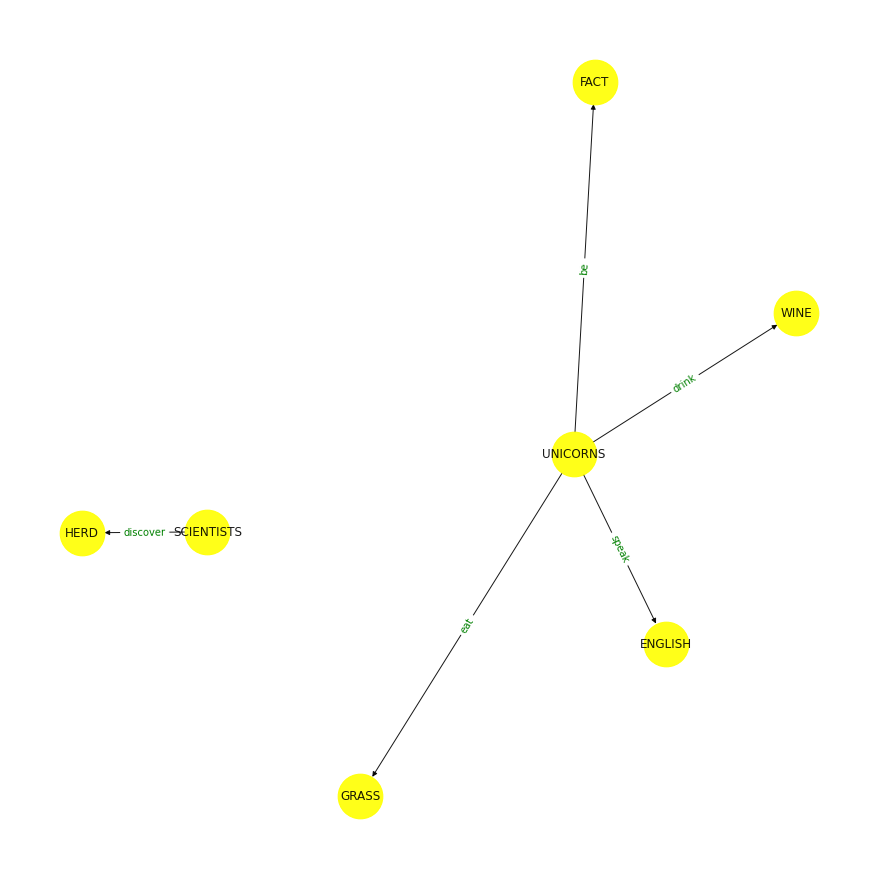

In [ ]:
prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."
candidate = "The unicorns ate grass and drank red wine. The scientists were amazed at their sophistication."
kg = KnowledgeGraph(prompt)
kg.visualize()
kg.forecast(candidate)
kg.visualize()
kg.append(candidate)
kg.visualize()

## Prompting GPT-Neo


In [ ]:
# Generate candidate sentences from GPT-Neo (as in the GPT-Neo mini-project).
def generate_candidate_sentences(model, tokenizer, prompt, k, num_returned_sentences, max_new_tokens=20):
  ''' This function will return num_returned_sentences based on a given prompt.
  Each sentence should be max_new_tokens.
  Args:
      model: the GPT-neo model 
      tokenizer: the object that tokenizes and de-tokenizes text
      prompt: a string
      k: stochastically sample sequences from the top k sequences in the distribution generated by the model.
          A larger k gives more variability and variety.
          This must be equal to or larger than num_returned_sentences
      num_returned_sentences: the number of sentences to return from this function
      max_length: the maximum length of the output sentences (in terms of number of tokens)
  '''
  
  # STEP 1: Use the tokenizer to convert the prompt into a tensor of tokens
  #        (don't forget to move the tensor to the GPU)
  prompt_tokens = tokenizer.encode(prompt, return_tensors='pt').to('cuda')
  prompt_length = len(prompt_tokens[0])
  max_length = prompt_length + max_new_tokens
  
  ### STEP 2 and 3: Call model.generate and receive a tensor of length num_returned_sentences
  candidates = model.generate(prompt_tokens, max_length=max_length, top_k=k, num_return_sequences=num_returned_sentences, do_sample=True, truncation=True)
  
  ### STEP 4: Convert the tensor into a list of num_returned_sentences
  output_sentences = [] # A list of output sentences to collect up and return
  for candidate_tokens in candidates:
    # Only return the new text, not the full prompt+text.
    new_tokens = candidate_tokens[prompt_length:]
    new_text = tokenizer.decode(new_tokens)
    output_sentences.append(new_text)

  return output_sentences

In [ ]:
# Print candidate sentences.
def print_candidate_sentences(candidate_sentences):
  print("Output:\n" + 100 * '-')
  for i, output in enumerate(candidate_sentences):
    print("{}: {} \n".format(i, output) + 20*'-')

In [ ]:
import math
# Generate a story with length target_length, continuation_length at a time.
# model: the model
# model_max: the max text to give to the model at once
# tokenizer: the tokenizer
# prompt: the initial prompt
# k: how many candidates to request at each pass
# target_length: the desired story length
# continuation_length: the max amount of text to request at once
# scoring_fn: the scoring function
# get_candidates_fn: the function to generate candidates.
def generate_story(model, model_max, tokenizer, prompt, k, num_candidates, target_length, continuation_length, scoring_fn, get_candidates_fn):
  # Use the generate_candidate_sentences iteratively to generate longer sequences 

  full_generated_text = prompt
  kg = KnowledgeGraph(prompt)
  full_generated_text_tokens = tokenizer.encode(full_generated_text, return_tensors='pt').to('cuda')
  full_length = len(full_generated_text_tokens[0])

  current_prompt = full_generated_text

  while full_length < target_length:
    # Length to trim the prompt to, respecting model_max and making room for the continuation.
    max_prompt_length = model_max - continuation_length
  
    # Request up to the continuation_length while respecting the target_length.
    max_new_tokens = math.floor(min(continuation_length, target_length - full_length))
    # Get candidates using the candidate function.
    candidates = get_candidates_fn(model, tokenizer, full_generated_text, kg, k, num_candidates, max_prompt_length, max_new_tokens)
    # Select continuation with the scoring_fn, using the full text as context.
    new_text = select_candidate_continuation(full_generated_text, kg, candidates, scoring_fn)

    # Step 3: Update the story.
    full_generated_text += new_text
    full_generated_text_tokens = tokenizer.encode(full_generated_text, return_tensors='pt').to('cuda')
    full_length = len(full_generated_text_tokens[0])
    kg.append(new_text)

  return full_generated_text, kg

In [ ]:
# Select a candidate based on the scoring function
def select_candidate_continuation(prompt, knowledge_graph, candidates, scoring_fn):
  scores = []
  for candidate in candidates:
    score = scoring_fn(prompt, knowledge_graph, candidate)
    scores.append(score)
  # Select the candidate with the best score
  selection = candidates[np.argmax(scores)]
  return selection

In [ ]:
# By default all candidates are scored equally well.
def default_scoring_fn(prompt, knowledge_graph, candidate):
  return 1

In [ ]:
# By default just prompt GPT-Neo with the prompt trimmed to max_prompt_length.
def get_candidates__default(model, tokenizer, full_prompt, kg, k, num_candidates, max_prompt_length, max_new_tokens):
  # Step 1: Check the length of the current prompt, truncate it if it will result in text that is be longer than max length threshold. 
  # Make sure your new prompt substring includes the end of the prompt so the model can correctly produce a continuation. 
  trimmed_prompt = token_trim(full_prompt, tokenizer, max_prompt_length)
  return generate_candidate_sentences(model, tokenizer, trimmed_prompt, k, num_candidates, max_new_tokens)

In [ ]:
# Trim a prompt to max_prompt_length tokens.
def token_trim(prompt, tokenizer, max_prompt_length):
  prompt_tokens = tokenizer.encode(prompt, return_tensors='pt').to('cuda')
  prompt_length = len(prompt_tokens[0])
  if prompt_length < max_prompt_length:
    return prompt
  else:
    trimmed_prompt_tokens = prompt_tokens[0][-max_prompt_length:]
    trimmed_prompt = tokenizer.decode(trimmed_prompt_tokens)
    return trimmed_prompt

### Scoring Functions

In [ ]:
# Penalize any added nodes (subject or object) to the graph.
# Penalize contradicting facts. (Same SRO, different Truth value)
# Reward reusing nodes from the graph.
def kg_scoring_fn(prompt, knowledge_graph, candidate):
  prompt_kg = knowledge_graph.dataframe
  new_spacy_relations, _, candidate_kg = knowledge_graph.forecast(candidate)
  score = 0
  # Penalize adding subjects/objects
  score -= num_nodes(candidate_kg) - num_nodes(prompt_kg)
  # Penalize contradicting facts
  score -= num_contradictions(candidate_kg) - num_contradictions(prompt_kg)
  # Reward using the same subject/objects
  score += new_edges(prompt_kg, candidate_kg)
  # Penalize verbatim repetitions
  score -= 100 * repetitions(knowledge_graph.spacy_relations.relations_by_sentence, new_spacy_relations)

  return score

In [ ]:
# How many times is there the same SVO but the opposite truth value?
def num_contradictions(kg):
  subjects = kg[['Subject']].values.flatten().tolist()
  objects = kg[['Object']].values.flatten().tolist()
  verbs = kg[['VerbNetClassId']].values.flatten().tolist() 
  truthy = kg[['TruthValue']].values.flatten().tolist() 

  svot = np.stack((subjects, verbs, objects, truthy)).T

  svot = svot[svot[:, 2].argsort()]                   # sort by subject
  svot = svot[svot[:, 1].argsort(kind='mergesort')]   # sort by verb
  svot = svot[svot[:, 0].argsort(kind='mergesort')]   # sort by object
  svo = svot[:, 0:3]
  truthys = svot[:, 3]
  uniques, idx, cnts = np.unique(svo, axis=0, return_counts=True, return_index = True)

  count = 0
  for i in range(len(uniques)):
    first_idx = idx[i]
    cnt = cnts[i]

    truthy_i = first_idx
    truthy = truthys[truthy_i]
    for c in range(cnt-1):
      truthy_i += 1
      if truthys[truthy_i] != truthy:
        count += 1

  return count

In [ ]:
# How many new connections have been added using the same nodes?
def new_edges(old_kg, new_kg):
  old_edges = old_kg[['Subject']].values.flatten().tolist()
  old_nodes = np.unique(old_kg[['Subject', 'Object']].values.flatten().tolist())
  new_subjs = new_kg[['Subject']].values.flatten().tolist()
  new_objs = new_kg[['Object']].values.flatten().tolist()
  new_so = np.stack((new_subjs, new_objs)).T
  new_edges = new_so[np.in1d(new_so, old_nodes).reshape(new_so.shape).any(axis=1)]
  return len(new_edges) - len(old_edges)

In [ ]:
# How many exact repetitions are there?
def repetitions(existing_spacy_relations, new_spacy_relations):
  score = 0
  sentences = []
  for sentence in existing_spacy_relations:
    sentences.append(sentence.text)
  for relations in new_spacy_relations:
    if relations.text in sentences:
      score += 1
  return score
    

In [ ]:
# How many unique nodes are there?
def num_nodes(kg):
  nodes = np.unique(kg[['Subject', 'Object']].values.flatten().tolist())
  return len(nodes)

In [ ]:
# Scoring function where score is determined by the number of subjects and objects that 
# are common for both the prompt and the candidate, i.e., check for number of subjects 
# and objects in the candidate that match the existing subjects and objects

def kg_scoring_fn2(prompt, knowledge_graph, candidate):
  '''
  Args: prompt: the current prompt fed to GPT-neo
        candidate: the generated continuation

  Returns: score: the score determined by the scoring function
           common: list of common subjects and objects
  '''
  prompt_kg = create_dataframe_from_prompt(prompt)
  prompt_so = np.unique(prompt_kg[['Subject', 'Object']].values.flatten().tolist()) # list of subjects and objects in the prompt
  # print(prompt_so)
  candidate_kg = create_dataframe_from_prompt(candidate)
  candidate_so = np.unique(candidate_kg[['Subject', 'Object']].values.flatten().tolist()) # list of subjects and objects in the candidate
  # print(candidate_so)

  common = np.intersect1d(prompt_so, candidate_so) # find number of intesections
  score = len(common)
  return score

In [ ]:
# Scoring function which calculates the F1 score by counting the true postives, false positives, 
# false negatives in the new prompt relative to the subjects and objects in the original prompt 
def kg_scoring_fn3(prompt, knowledge_graph, candidate):
  prompt_kg = create_dataframe_from_prompt(prompt)
  prompt_so = np.unique(prompt_kg[['Subject', 'Object']].values.flatten().tolist())
  
  candidate_kg = create_dataframe_from_prompt(candidate)
  candidate_so = np.unique(candidate_kg[['Subject', 'Object']].values.flatten().tolist())

  if len(candidate_so)==0:
    return 0 
  # true positives: full intersection
  true_positives = len(np.intersect1d(prompt_so, candidate_so))
  # false positives: number of entities in candidate that are not there in prompt
  false_positives = len(np.setdiff1d(candidate_so, prompt_so))
  # false neg: number of entities in prompt not in candidate
  false_negatives = len(np.setdiff1d(prompt_so, candidate_so))
  #print (prompt_so, candidate_so)
  #print ("truepos : "+ str(true_positives) + " falsepos : " + str(false_positives) + " falseneg: " + str(false_negatives))
  #precision = true_positives/(true_positives + false_positives)
  #recall = true_positives/(true_positives + false_negatives)
  f1_score = 2 * true_positives/(2 * true_positives + false_positives + false_negatives)
  return f1_score


In [ ]:
#BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations.
#Although developed for translation, it can be used to evaluate text generated for a variety of natural language processing tasks.
from nltk.translate.bleu_score import sentence_bleu
#reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
#candidate = ['this', 'is', 'a', 'test']
def kg_scoring_fn4(prompt, knowledge_graph, candidate):
  prompt_kg = create_dataframe_from_prompt(prompt)
  prompt_so = np.unique(prompt_kg[['Subject', 'Object']].values.flatten().tolist())
  
  candidate_kg = create_dataframe_from_prompt(candidate)
  candidate_so = np.unique(candidate_kg[['Subject', 'Object']].values.flatten().tolist())
  score = sentence_bleu(prompt_so, candidate_so)
  return score

In [ ]:
def choose_best_candidate(prompt, candidates, scoring_fn, kg):
  m = float('-inf')
  kg = KnowledgeGraph(prompt)
  # print(kg)
  for candidate in candidates:
    score, common = kg_scoring_fn2(prompt, kg, candidate)
    if score > m:
      m = score
      best_candidate = candidate
    print(f'Candidate: {candidate}\n Score: {score}\n')

    return best_candidate, m

  # print('Best candidate: ', best_candidate)
  # print('Best score: ', m)

#### Scoring Function Examples

In [ ]:
k = 5
num_returned_sentences = 5
text_length = 20

In [ ]:
prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."

In [ ]:
generated_sequences = generate_candidate_sentences(model, tokenizer, prompt, k, num_returned_sentences, text_length)
print(prompt)
print_candidate_sentences(generated_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientists discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
Output:
----------------------------------------------------------------------------------------------------
0: 

In the Andes Mountains, in Chile’s central Andes, a herd of 
--------------------
1: 

“They were so well-spoken and so well-modeled that they seemed to 
--------------------
2:  The scientists, from the University of Edinburgh, believe the animals are descended from a species known as the 
--------------------
3: 

The scientists were studying a herd of about 200 animals when they came across a group of about 
--------------------
4: 

In the past, unicorns have been spotted only in the United States, and the closest 
--------------------


In [ ]:
prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."
candidate = "Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English. Even more surprising to the researchers was the fact that the unicorns spoke perfect English."
kg = KnowledgeGraph(prompt)
score = kg_scoring_fn(prompt, kg, candidate)
print("SCORE"); print(score)

SCORE
-196


In [ ]:
# Example using kg_scoring_fn2() to find the best candidate
# Choose the best candidate, i.e., candidate with the highest score from candidates

prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."
candidates = ['The unicorns are the most beautiful of all mythical creatures, and have been the subject of', \
              'A team from the University of Colorado, the University of Wyoming and the University of British Columbia ', \
              'The discovery of the herd of unicorns in the Andes Mountains, in Chile was made', \
              'A team of scientists from the University of Edinburgh, the University of Oxford and the University of ', \
              'The researchers, who are part of the University of Oxford\'s Centre for Ecology and Hydrology, say ']

m = float('-inf')
kg = KnowledgeGraph(prompt)
# print(kg)
for candidate in candidates:
  score = kg_scoring_fn2(prompt, kg, candidate)
  if score > m:
    m = score
    best_candidate = candidate
  print(f'Candidate: {candidate}\n Score: {score}\n')

print('Best candidate: ', best_candidate)
print('Best score: ', m)

Candidate: The unicorns are the most beautiful of all mythical creatures, and have been the subject of
 Score: 1

Candidate: A team from the University of Colorado, the University of Wyoming and the University of British Columbia 
 Score: 0

Candidate: The discovery of the herd of unicorns in the Andes Mountains, in Chile was made
 Score: 0

Candidate: A team of scientists from the University of Edinburgh, the University of Oxford and the University of 
 Score: 0

Candidate: The researchers, who are part of the University of Oxford's Centre for Ecology and Hydrology, say 
 Score: 0

Best candidate:  The unicorns are the most beautiful of all mythical creatures, and have been the subject of
Best score:  1


In [ ]:
k = 5
num_candidates = 10
target_length = 500
continuation_length = 50
model_max = 250

In [ ]:
prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."

In [ ]:
# Example using the default scoring function (no scoring)
default_story, default_kg = generate_story(model, model_max, tokenizer, prompt, k, 1, target_length, continuation_length, default_scoring_fn, get_candidates__default)
print(default_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientists discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The unicorns are a species of mythical horse-like creatures native to the Andes Mountains, which are part of South America. They are said to exist only in the mountains, and are thought to have been extinct for thousands of years until a young man named Juan de la Cruz stumbled upon them while trekking through the region, in 1812. The young explorer named his new land "Villa de las Unicornas" (Village of Unicorns), which was the result of a translation from the Spanish word "unicorn."

After the explorer’s death, his family continued to live in this isolated area. They were so poor they had to rely on their own livestock for survival. The family also had to deal with the harsh climate, and had to live with the constant fear of being attacked by a wild bear,

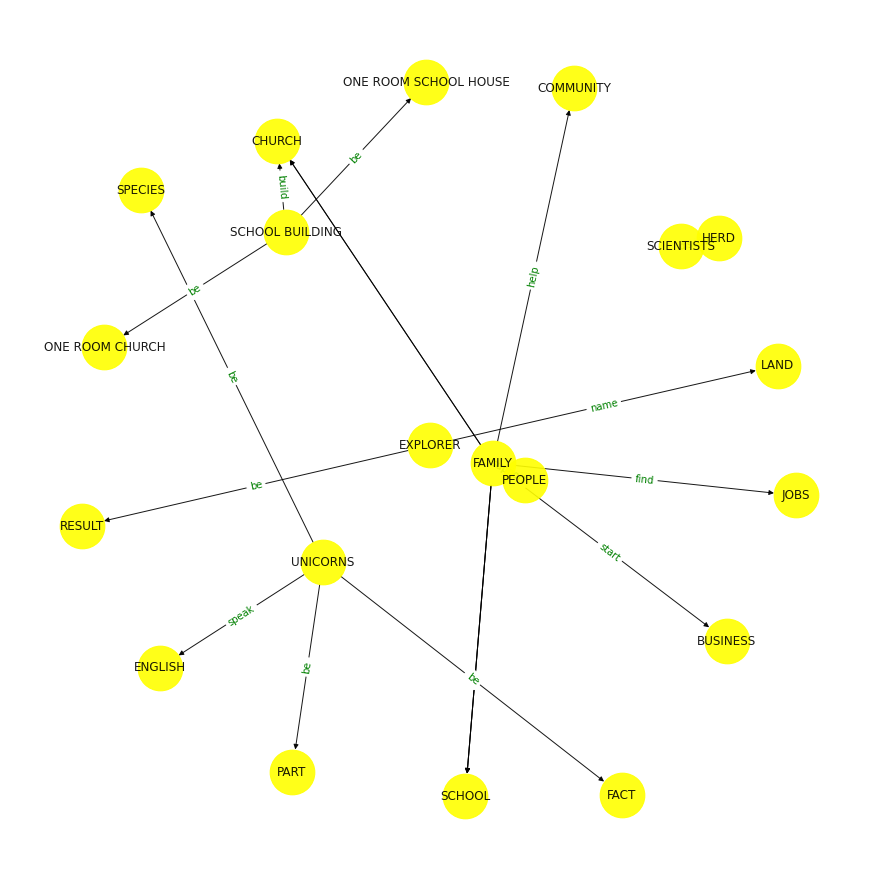

In [ ]:
default_kg.visualize()

In [ ]:
# Example using kg_scoring_fn
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientists discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The discovery was made by the scientists at the University of California, Berkeley, who have been studying the Andes since 2008, and who were able to find and capture the herd.

“We were very excited,” said Dr. Michael R. Kappelman, the lead researcher on the project. “We had a feeling the unicorns would speak perfect English, but it turns out they did, and it was really cool. They are the most intelligent, the most beautiful animals in the world.”

The researchers were also surprised to find out they were the only herd of unicorns they had ever encountered, and that the herd had been living in a valley for over 100 years.

�The unicorns are not just beautiful, they are intelligent, and very intelligent,” Dr. Kappelman said. “They are also extremely smart a

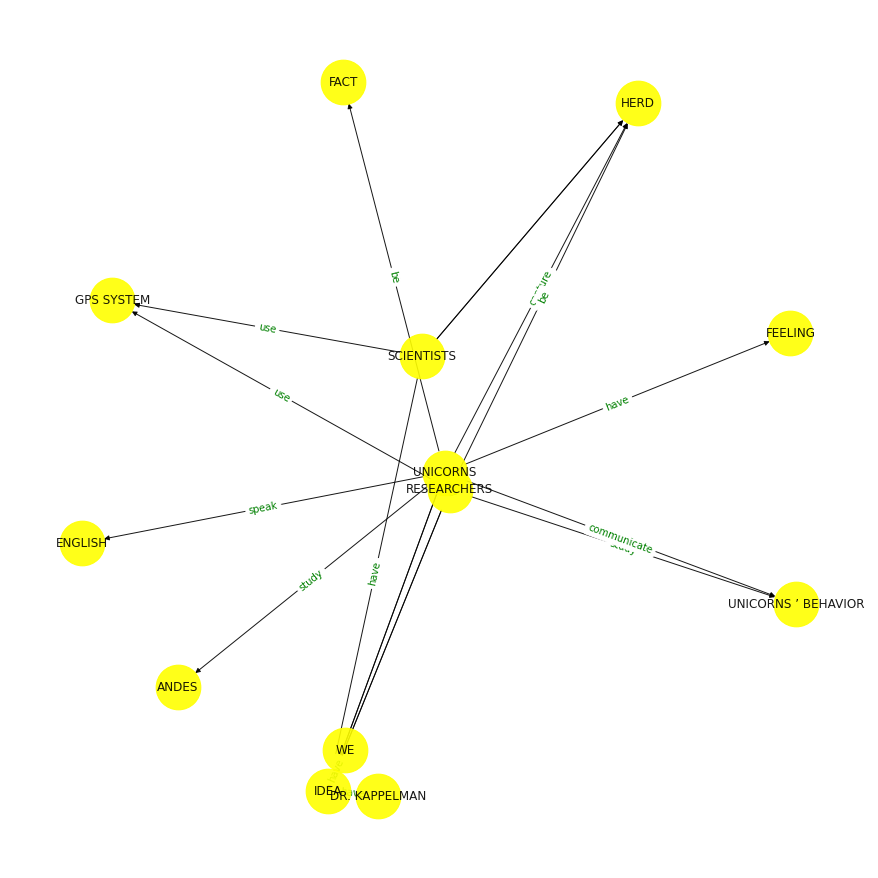

In [ ]:
kg.visualize()

In [ ]:
# Example using kg_scoring_fn2
kg_scored_story2, kg = generate_story(model, model_max, tokenizer, prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print(kg_scored_story2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientists discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The researchers found that the unicorns, which they named “Tupac,” were the descendants of a herd of horses and zebras, who were brought by Spanish explorers to the Andean region of Ecuador. The researchers believe that the Spanish explorers brought the horses and zebras to the region because they had heard that the Andes were home to unicorns.

The scientists believe they have found the descendants of an ancient race of animals, and that this is why the Andes are home to the unicorns. The researchers believe that these ancient horses and zebras were used as mounts for the Spanish explorers, who brought the unicorns to Ecuador to hunt for food, and to protect their horses from predators.

The unicorns have been living in the mountains of the Andes for thous

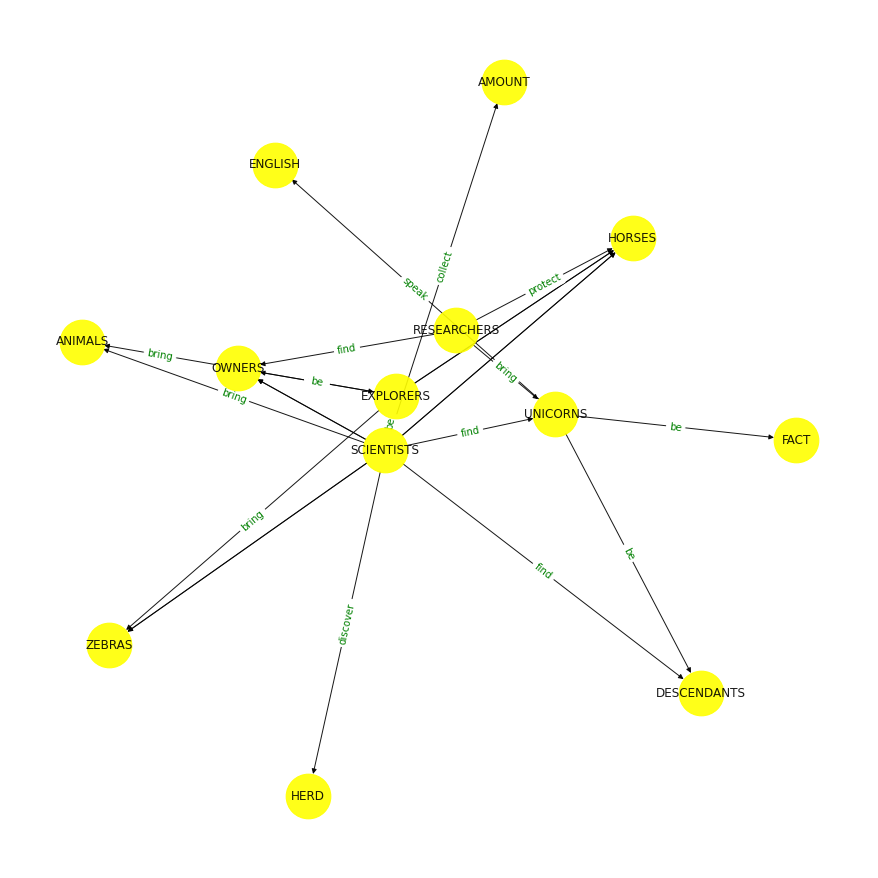

In [ ]:
kg.visualize()

In [ ]:
# Example using kg_scoring_fn3() to find the best candidate
# Choose the best candidate, i.e., candidate with the highest score from candidates

prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."
candidates = ['The unicorns are the most beautiful of all mythical creatures, and have been the subject of', \
              'A team from the University of Colorado, the University of Wyoming and the University of British Columbia ',\
              'The discovery of the herd of unicorns in the Andes Mountains, in Chile was made', \
              'A team of scientists from the University of Edinburgh, the University of Oxford and the University of ', \
              'The researchers, who are part of the University of Oxford\'s Centre for Ecology and Hydrology, say ']

m = float('-inf')
for candidate in candidates:
  score = kg_scoring_fn3(prompt, _, candidate)
  if score > m:
    m = score
    best_candidate = candidate
  print(f'Candidate: {candidate}\n Score: {score}\n')

print('Best candidate: ', best_candidate)
print('Best score: ', m)

Candidate: The unicorns are the most beautiful of all mythical creatures, and have been the subject of
 Score: 0.2857142857142857

Candidate: A team from the University of Colorado, the University of Wyoming and the University of British Columbia 
 Score: 0

Candidate: The discovery of the herd of unicorns in the Andes Mountains, in Chile was made
 Score: 0

Candidate: A team of scientists from the University of Edinburgh, the University of Oxford and the University of 
 Score: 0

Candidate: The researchers, who are part of the University of Oxford's Centre for Ecology and Hydrology, say 
 Score: 0.0

Best candidate:  The unicorns are the most beautiful of all mythical creatures, and have been the subject of
Best score:  0.2857142857142857


In [ ]:
# Example using kg_scoring_fn4() to find the best candidate
# Choose the best candidate, i.e., candidate with the highest score from candidates

prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."
candidates = ['The unicorns are the most beautiful of all mythical creatures, and have been the subject of', \
              'A team from the University of Colorado, the University of Wyoming and the University of British Columbia ',\
              'The discovery of the herd of unicorns in the Andes Mountains, in Chile was made', \
              'A team of scientists from the University of Edinburgh, the University of Oxford and the University of ', \
              'The researchers, who are part of the University of Oxford\'s Centre for Ecology and Hydrology, say ']

m = float('-inf')
for candidate in candidates:
  score = kg_scoring_fn4(prompt, _, candidate)
  if score > m:
    m = score
    best_candidate = candidate
  print(f'Candidate: {candidate}\n Score: {score}\n')

print('Best candidate: ', best_candidate)
print('Best score: ', m)

Candidate: The unicorns are the most beautiful of all mythical creatures, and have been the subject of
 Score: 0

Candidate: A team from the University of Colorado, the University of Wyoming and the University of British Columbia 
 Score: 0

Candidate: The discovery of the herd of unicorns in the Andes Mountains, in Chile was made
 Score: 0

Candidate: A team of scientists from the University of Edinburgh, the University of Oxford and the University of 
 Score: 0

Candidate: The researchers, who are part of the University of Oxford's Centre for Ecology and Hydrology, say 
 Score: 0

Best candidate:  The unicorns are the most beautiful of all mythical creatures, and have been the subject of
Best score:  0


### Get Candidates Functions

In [ ]:
# Using the KG string as the only prompt produces output that looks like the KG string (Subject VERB Object). 
# This is subjectively awful but scores well (because it matches the KG well).
def get_candidates__kg_as_prompt(model, tokenizer, full_generated_text, kg, k, num_candidates, max_prompt_length, max_new_tokens):
  trimmed_prompt = token_trim(str(kg), tokenizer, max_prompt_length)
  return generate_candidate_sentences(model, tokenizer, trimmed_prompt, k, num_candidates, max_new_tokens)

In [ ]:
percent_kg = .2
# percent_kg is the maximum percent of the prompt we want to use the knowledge graph for rather than the story.
# Try and fill that percent with the kg string, up to the entire kg. Then fill the rest of max_prompt_length
# with the story prompt
def get_candidates__prompt_kg_blend(model, tokenizer, story_prompt, kg, k, num_candidates, max_prompt_length, max_new_tokens):
  kg_prompt = str(kg)
  all = kg_prompt + story_prompt
  tokens = tokenizer.encode(all, return_tensors='pt').to('cuda')
  if len(tokens[0]) < max_new_tokens:
    return generate_candidate_sentences(model, tokenizer, all, k, num_candidates, max_new_tokens)
  abbrev_prompt = ""
  kg_tokens = tokenizer.encode(kg_prompt, return_tensors='pt').to('cuda')
  max_kg_length = math.floor(percent_kg * max_prompt_length)
  if max_kg_length <= len(kg_tokens):
    max_kg_length = len(kg_tokens)
    abbrev_prompt = kg_prompt
  else:
    abbrev_prompt = tokenizer.decode(kg_tokens[0][0:max_kg_length])
  max_story_length = max_prompt_length - max_kg_length
  story_tokens = tokenizer.encode(story_prompt, return_tensors='pt').to('cuda')
  abbrev_prompt += tokenizer.decode(story_tokens[0][-max_story_length:])
  return generate_candidate_sentences(model, tokenizer, abbrev_prompt, k, num_candidates, max_new_tokens)


In [ ]:
# Let the scoring function choose between a regular prompt and a partially-knowledge graph prompt.
def get_candidates__all(model, tokenizer, full_prompt, kg, k, num_candidates, max_prompt_length, max_new_tokens):
  default = get_candidates__default(model, tokenizer, full_prompt, kg, k, num_candidates, max_prompt_length, max_new_tokens)
  # Using the KG string as the only prompt produces output that is subjectively awful but scores well (because it matches the KG well).
  # So, we are leaving it out.
  # kg_as_prompt = get_candidates__kg_as_prompt(model, tokenizer, full_prompt, kg, k, num_candidates, max_prompt_length, max_new_tokens)
  prompt_kg_blend = get_candidates__prompt_kg_blend(model, tokenizer, full_prompt, kg, k, num_candidates, max_prompt_length, max_new_tokens)
  return default + prompt_kg_blend

#### Get Candidates Examples

In [ ]:
# Using part of the kg in the prompt results in super-repetitive stories.
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In a shocking finding, scientists discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The scientists, from the University of Edinburgh, were able to record the unicorns' language, and they even managed to record the unicorns’ thoughts and feelings about the environment in which they live. The researchers also managed to record the unicorns using a device that allowed them to listen to their speech.

The scientists were able to record the unicorns speaking their language using a device that allowed them to listen to their speech using an array of microphones. The recordings were then analysed to determine how well the unicorns understood their language.

The scientists also managed to record the unicorns’ thoughts and feelings about the environment in which they live.

The researchers managed to record the unicorns’ thoughts and feelings abou

In [ ]:
print(kg)
print(kg.dataframe)

SCIENTISTS  discover HERD.UNICORNS  be FACT.UNICORNS  speak ENGLISH.SCIENTISTS  record UNICORNS ' LANGUAGE.SCIENTISTS  record UNICORNS ’ THOUGHTS.SCIENTISTS  record FEELINGS.UNICORNS  use DEVICE.SCIENTISTS  record UNICORNS.SCIENTISTS  speak LANGUAGE.SCIENTISTS  use DEVICE.SCIENTISTS  use ARRAY.UNICORNS  understand LANGUAGE.RESEARCHERS  record UNICORNS ’ THOUGHTS.RESEARCHERS  record FEELINGS.RESEARCHERS  use ARRAY.RESEARCHERS  understand THOUGHTS.RESEARCHERS  understand FEELINGS.RESEARCHERS  use DEVICE.SCIENTISTS  understand THOUGHTS.SCIENTISTS  understand FEELINGS.
        Subject        Verb               Object TruthValue   VerbNetClassId
0    SCIENTISTS    discover                 HERD       True      discover-84
1      UNICORNS          be                 FACT       True               be
2      UNICORNS       speak              ENGLISH       True  lecture-37.11-1
3    SCIENTISTS      record  UNICORNS ' LANGUAGE       True  transcribe-25.4
4    SCIENTISTS      record  UNICORNS ’ THO

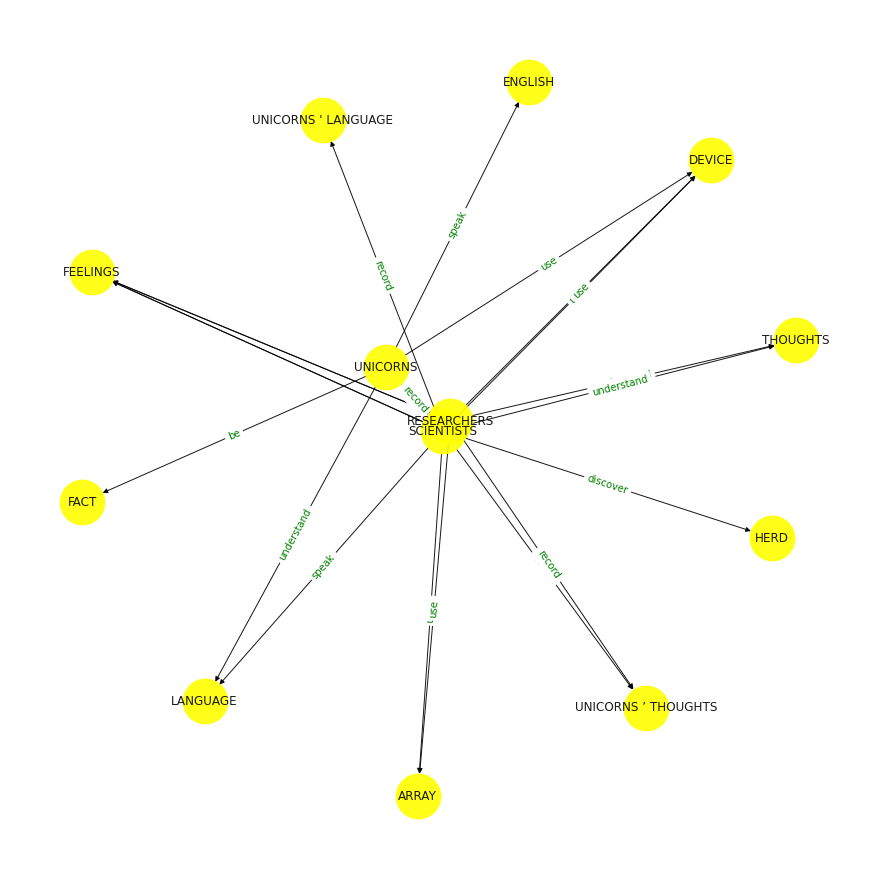

In [ ]:
kg.visualize()

## Experimentation

In [ ]:
k = 5
num_candidates = 10
target_length = 500
continuation_length = 50
model_max = 250

### Testing different prompts on the scoring functions:
In this section, we have different prompts, taken from various sources and having a mix of different topics, writing styles and genres. This should give us an idea of how the different scoring functions perform on different kinds of prompts.

In [ ]:
#### Prompts

# default prompt taken from mini-project
prompt_0 = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
"previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
"researchers was the fact that the unicorns spoke perfect English."

# Scientific article regarding DuckDuckGo's new browser app
prompt_1 = "Since the launch of its search engine back in 2008, DuckDuckGo’s web browser " \
"continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product " \
"manager for the Mac app. \"We don't track our users—that is our privacy policy,\" Burger-Lenehan says."

# Opening paragraph from 'The Stranger' by Albert Camus
prompt_2 = 'Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: '\
'‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday.'

# Opening paragraph from 'The Bell Jar' by Sylvia Plath
prompt_3 = 'It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York'

# Opening line from 'One Hundred Years of Solitude' by Gabriel Garcia Marquez
prompt_4 = 'Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to ' \
'remember that distant afternoon when his father took him to discover ice.'

# Opening paragraph from 'A Game of Thrones' by George R.R. Martin
prompt_5 = 'The morning had dawned clear and cold, with a crispness that hinted at the end of summer. ' \
'They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with ' \
'excitement. This was the first time he had been deemed old enough to go with his lord father and his ' \
'brothers to see the king\'s justice done. It was the ninth year of summer, and the seventh of Bran\'s life'

##### Testing prompt_1

In [ ]:
kg = KnowledgeGraph(prompt_1)

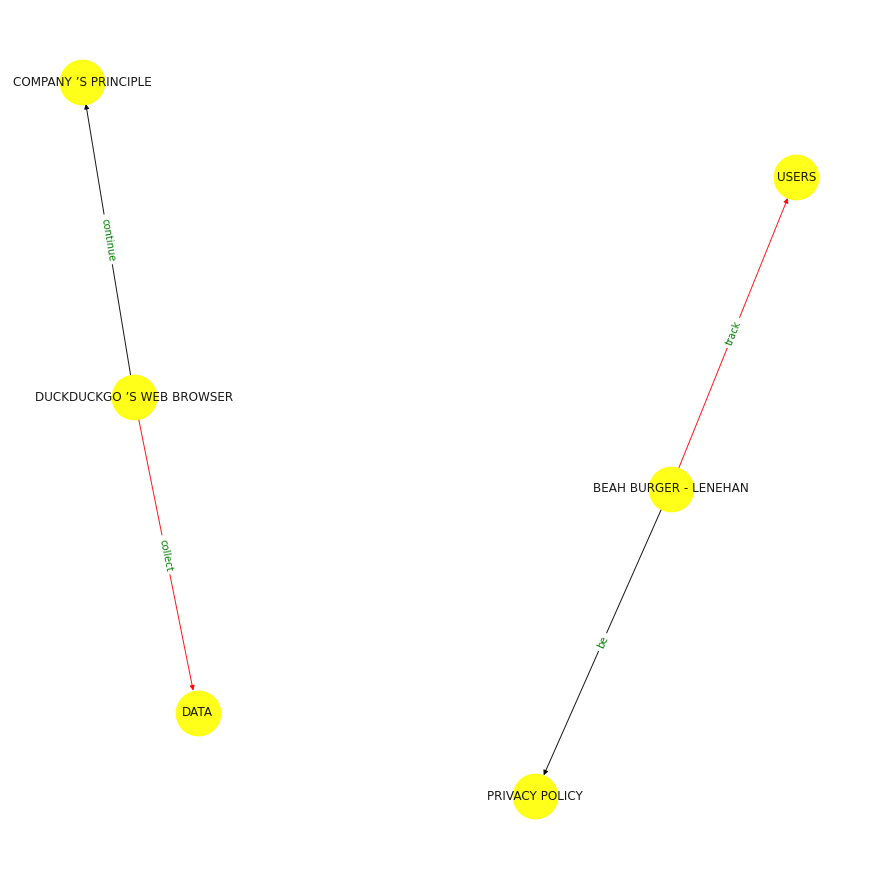

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says. "We have a privacy policy, but it’s not something that we’ve ever really put in writing.

"The reason why we’re so open about this is because we don’t want to be the company that people have to be afraid to go to. We’re not afraid to tell you about our privacy policy," she continues. "We’ll tell you what it is, and what it doesn’t include."



"We’re not the company that you have to be afraid to go to." - DuckDuckGo

"We’re not the company that you have to be afraid to go to."

The company�s privacy policy states that the company "does not sell, rent or share your personal information," but does not specify whether it collects data on users' location, browser history, or any other data, says Beah Burger-Lenehan,

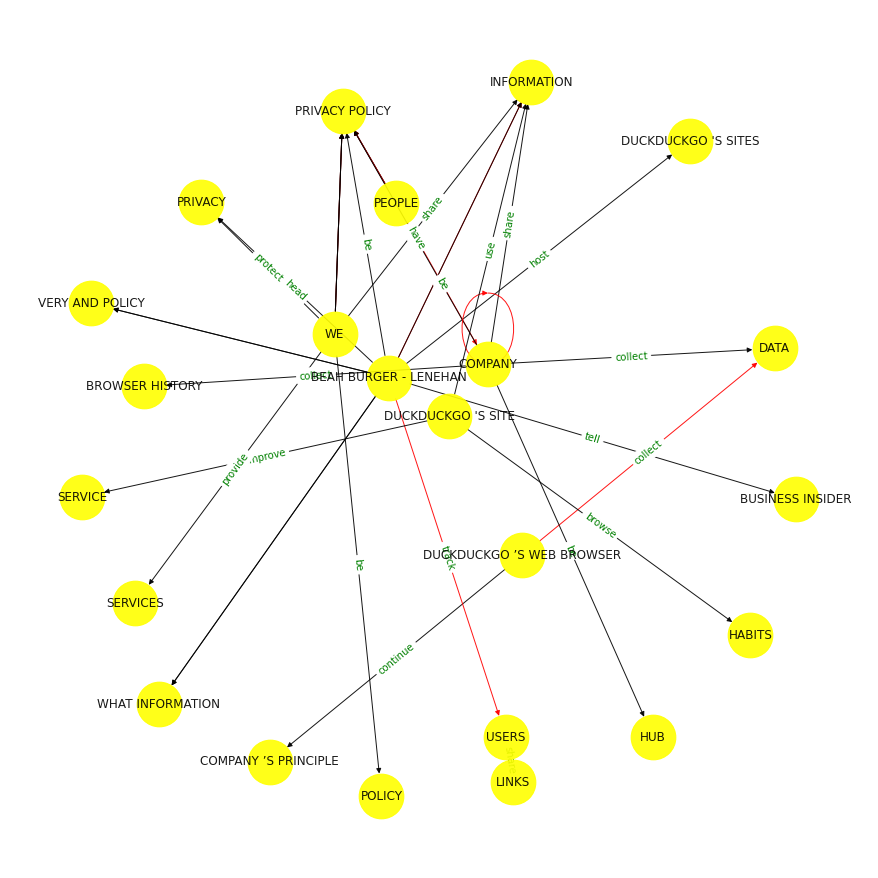

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says.

In a statement, DuckDuckGo says the privacy of its users remains its top priority. "We do not track users, collect any data about them, nor do we store any data in the browser. Our users can choose to opt in to the privacy policy and privacy settings, but we don't track users," the company says. "The privacy policy is a simple statement that explains our policies, and users can always visit DuckDuckGo for additional information."

The company also offers a "Privacy Policy for Web Browsers" in its privacy policy, which includes the following:

DuckDuckGo will not collect any data about users, and we do not store any data in our browser.



Our privacy policy is an important statement that explains our policies, 

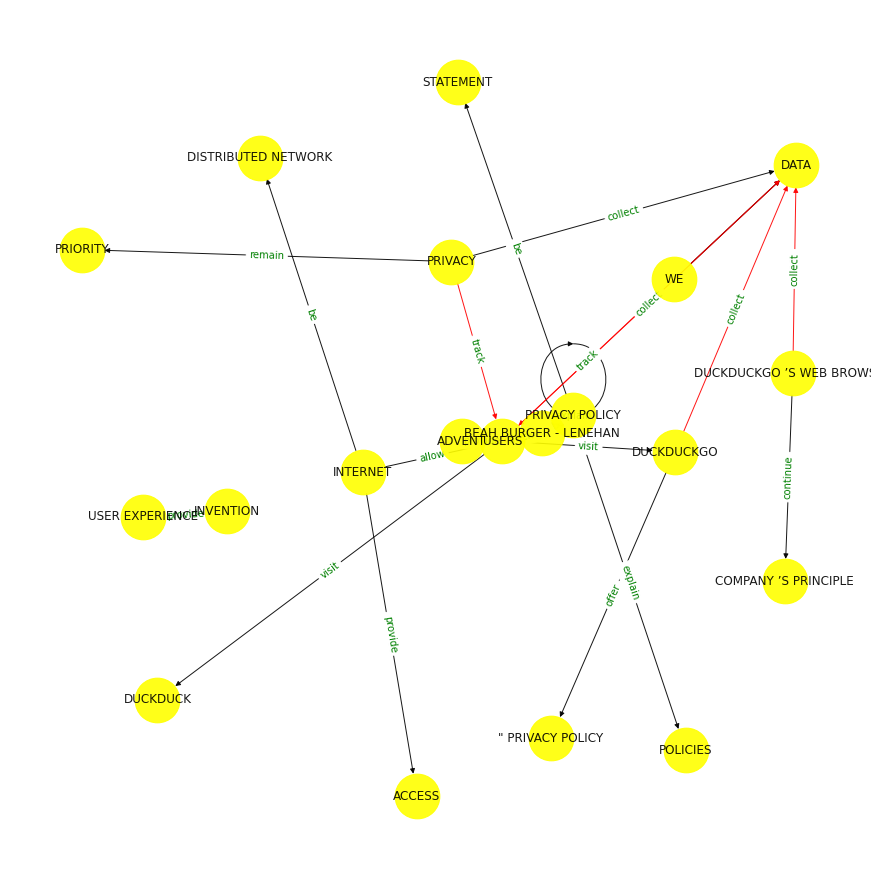

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says. "Our users have complete control over how and where our data is collected."

DuckDuckGo is also the only web browser that offers a search engine that does not collect your data, but it doesn’t offer a way for users to control what data is stored, either, says Beah. "We do not track our users—that is our privacy policy. Our users have complete control over how and where our data is collected."

DuckDuckGo has also been the first search engine to offer a search that does not require a browser. It’s called "DuckDuckGo" and it’s a search engine that doesn’t collect your data either, and you don’t have to install anything to search for anything, says Beah Burger-Lenehan. "Our users have complete control over how and 

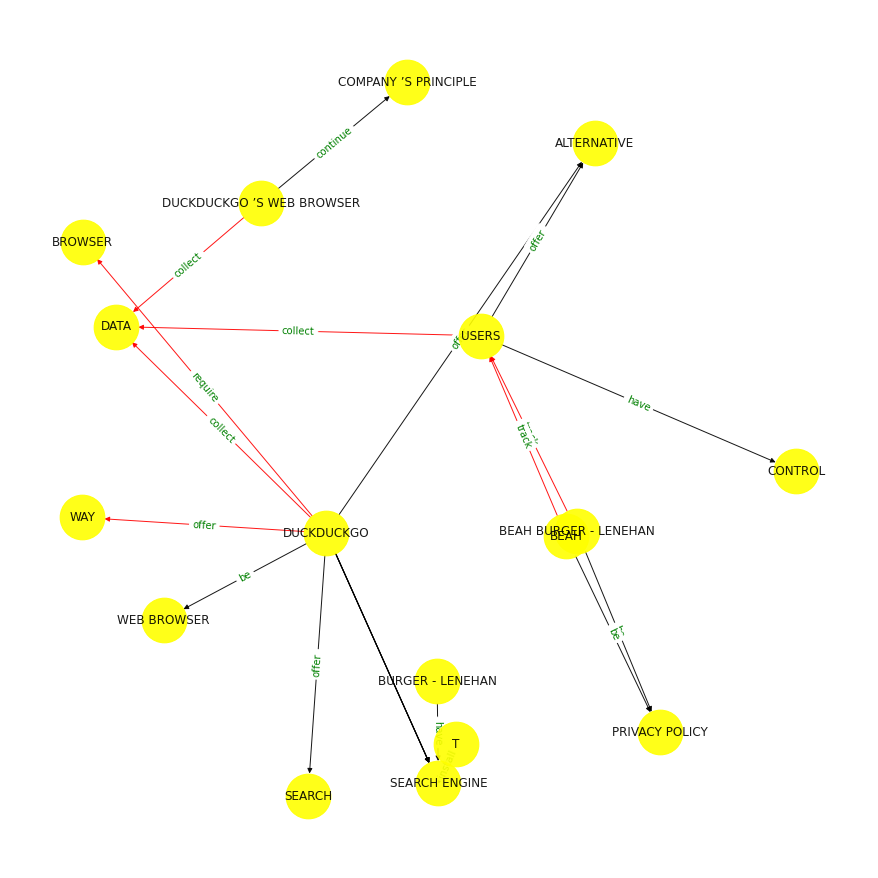

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says.

But the company’s search engine is not the only way that it collects data. It has a variety of other services, including a social media platform and a mobile app, that it uses for advertising and marketing purposes.

DuckDuckGo says that it does not collect information about users from the mobile app, but it does collect user information when they visit the web page.

The web browser, the Mac app and the mobile app are the only ways that DuckDuckGo collects information.

The company also uses the data to improve its search engine, according to Burger-Lenehan, and it does not use it for advertising or marketing purposes. The company does not track the location of visitors to its website or its mobile app.

“We a

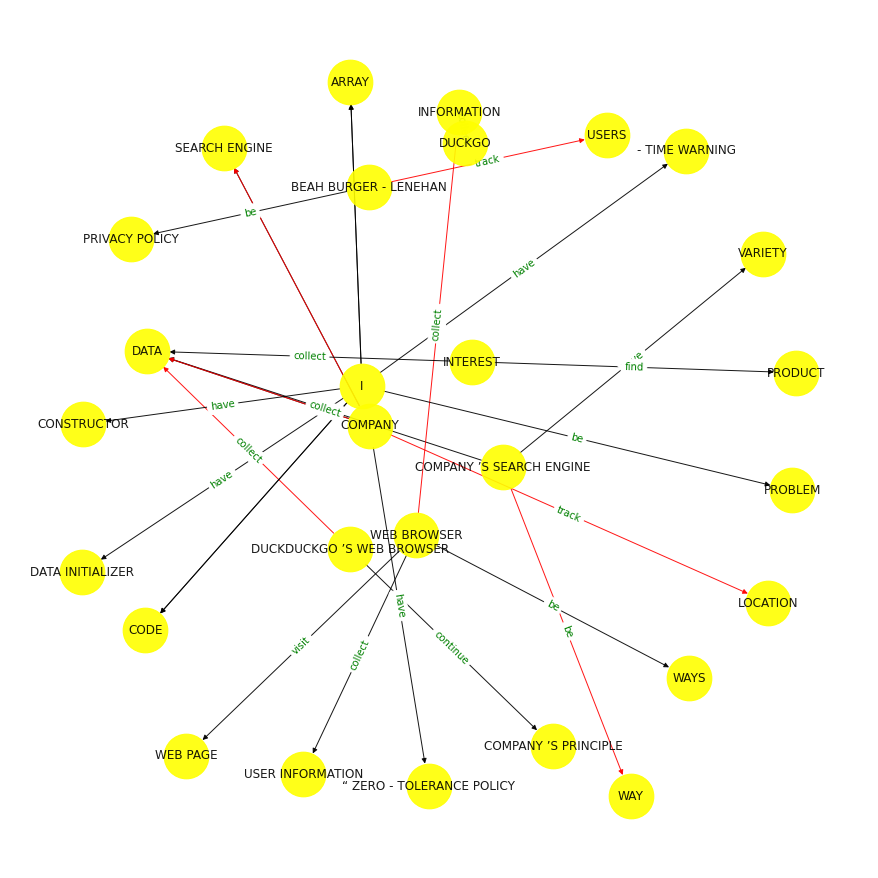

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says. "Our users can use our app as much as they want, but they don't need to."

In addition, the Mac version of the app is the latest to be available for download, and the app is now available in both English and French.

"Our users can use our app as much as they want, but they don't need to. We want our users to have the best possible experience on the web," says Beah.

The DuckDuckGo app is available for free on the Mac App Store and Google Play.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

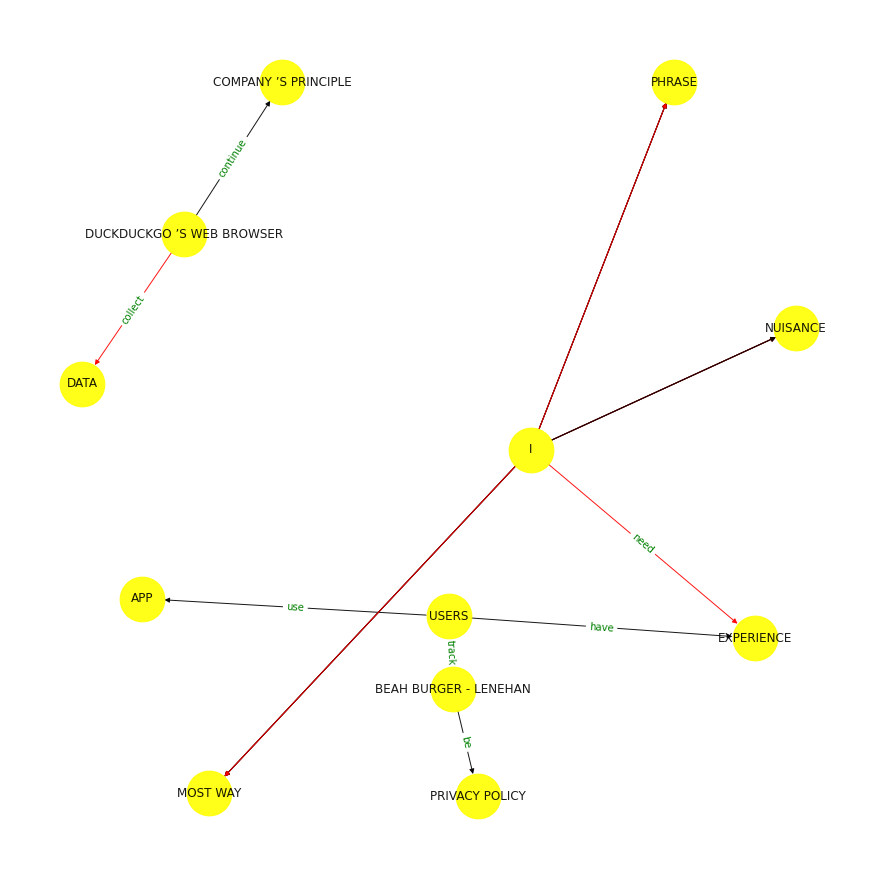

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says.

"We don’t track our users—that is our privacy policy."

But DuckDuckGo’s privacy policy is more than just a privacy statement. It’s a commitment to users that the site will not collect or share their data, and to make that a promise, the search engine has a dedicated privacy team, says John Mueller, the company’s senior vice president of product. DuckDuckGo’s privacy policy says that the search engine will not collect or share any data, and that users can opt out of that. The privacy team also monitors user activity, including search queries, to make sure users are following the site’s privacy policy.

"It's not about tracking," says Mueller, who has been with DuckDuckGo for five years. "We have a commitment to

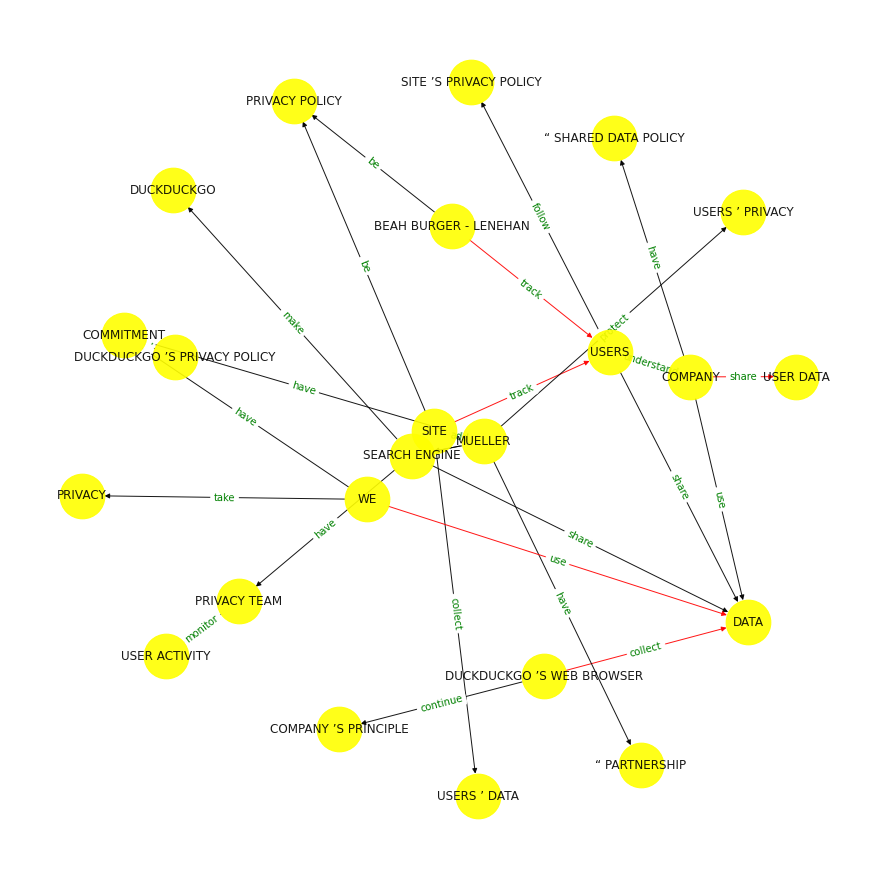

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says. "We don’t collect their search history—that is our privacy policy. Our privacy policy doesn’t mention our users at all. We don’t collect the data we use, and we don’t collect our users' data. We don’t use your data, and we don’t collect the information we collect."

DUCKDUCKGO ’S WEB BROWSER  continue COMPANY ’S PRINCIPLE OF NOT COLLECTING YOUR DATA. “We do not track our users.” “DuckDuckGo ’s Web Browser” continues COMPANY ’S PRINCIPLE OF NOT COLLECTING YOUR DATA. “We do not track our users—that is our privacy policy. We don’t collect your search history. We don’t collect the data we use, and we don’t collect your user’s data. We don’t use your data, and we don’t collect the information we collect.”

DUCKDUCKGO

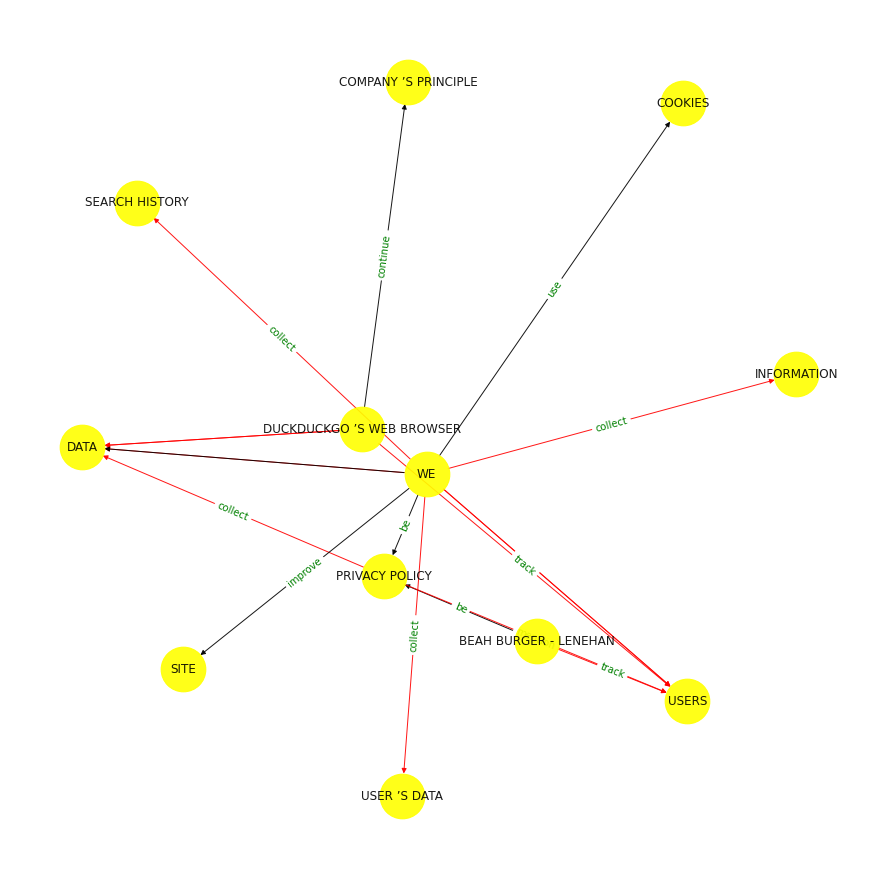

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_1, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Since the launch of its search engine back in 2008, DuckDuckGo’s web browser continues the company’s principle of not collecting your data, says Beah Burger-Lenehan, the product manager for the Mac app. "We don't track our users—that is our privacy policy," Burger-Lenehan says.

The company's privacy policy is a good place to start. The company doesn’t collect any personal information, but it does use cookies, which are pieces of information sent to your computer from websites.

The company says its privacy policy is "not intended to be used as a general statement regarding the law or legal process," but it does explain that the company doesn’t sell any of your personal information.

"Our privacy policy is designed to help you understand how DuckduckGo is protecting your information and why we have chosen to do so," the policy states. "It does not apply to your use of our website or any services offered by DuckduckGo. We do not sell your personal information to any other parties."

The

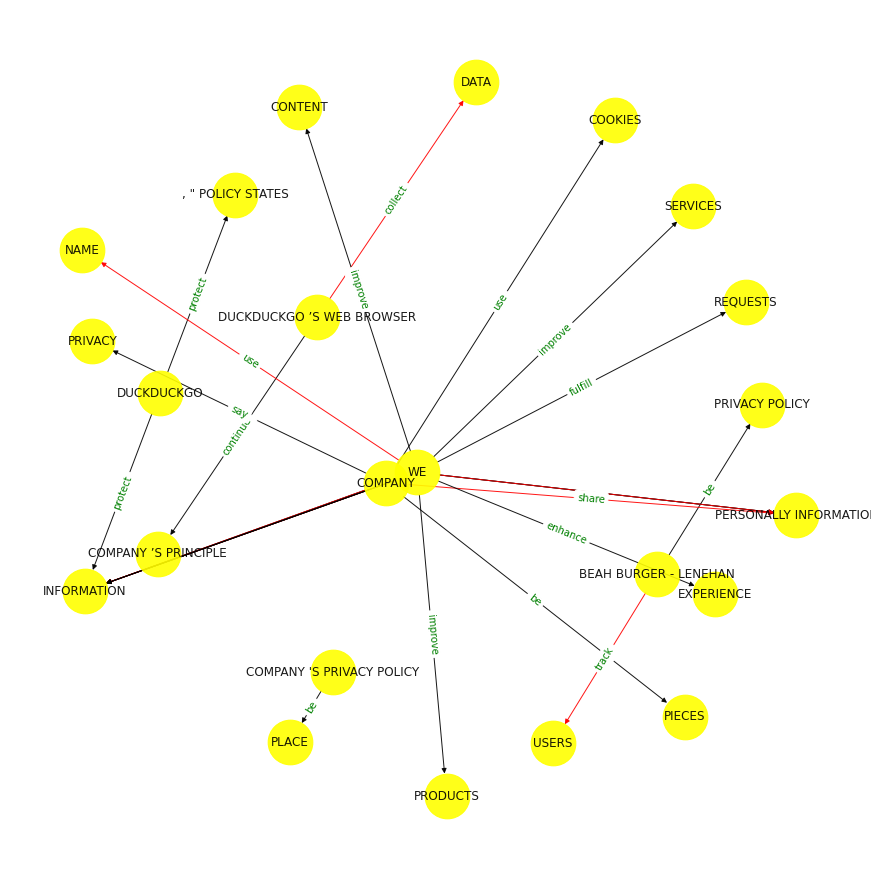

In [ ]:
kg.visualize()

#### Testing prompt_2

Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday.


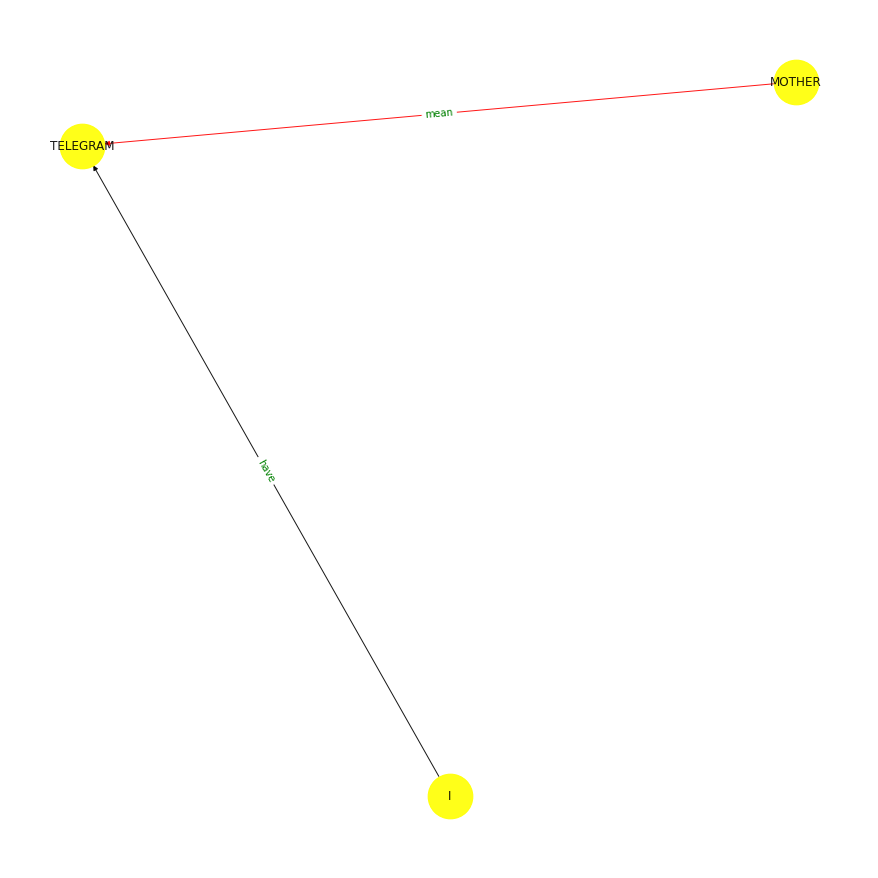

In [ ]:
kg = KnowledgeGraph(prompt_2)
print(prompt_2)
kg.visualize()

In [ ]:
default_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, default_scoring_fn, get_candidates__default)
print(default_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday.

But I’ve been thinking about it for a while now. I’ve been thinking that I should have written to her, that I should have written to her, and that if I had I would have written to her.

It’s not that I don’t think I would have written to her. I’ve always wanted to write to her. I’ve always wanted to write to her. But it was just too painful. I didn’t know how to.

So I haven’t done it.

But I do think I should have written, and I think I should have written to her when I knew she was dying. I think that I should have tried to write to her when I knew she was dying.

I think I should have written to her.

I’m sure she would have been very pleased to hear from me, but I’m sure I would have been too.

I’ve always had the feeling that she would have been very pleased that I wrote to her, but it

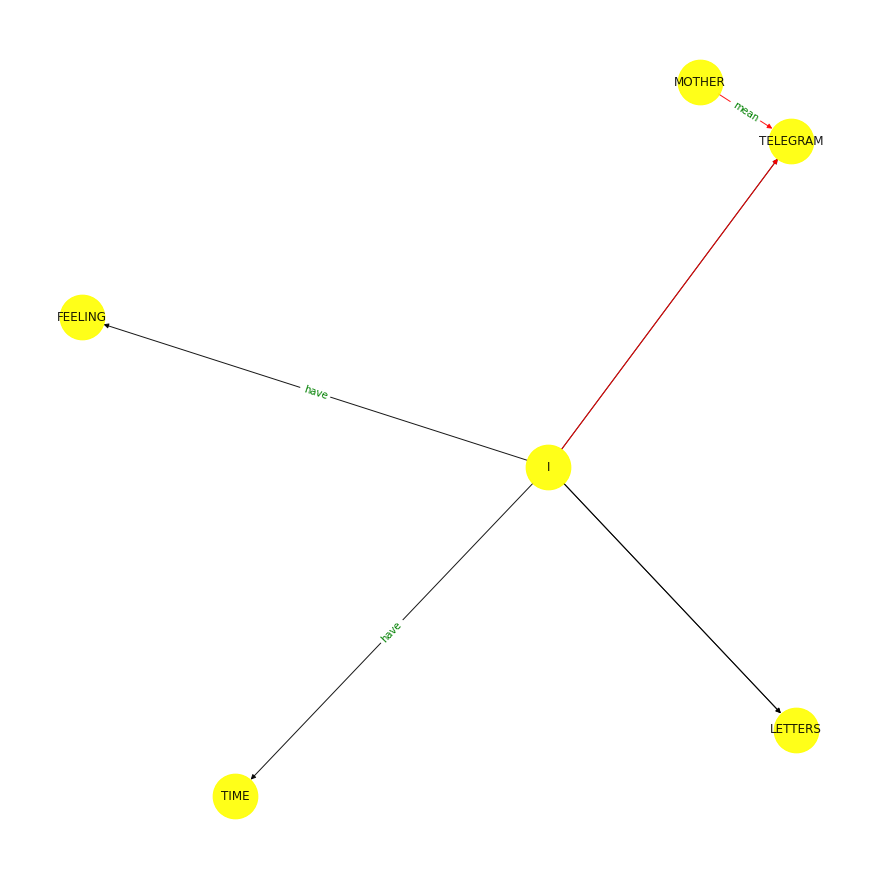

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. It may be today. It may not be tomorrow. I don’t know. I just know that I was not expecting to hear anything.”

“What do you want me to do?” I asked.

He shrugged. I didn’t know whether he was kidding or whether he had a point.

“Well, I guess I’ll go see what I can do.”

“What do you want me to do?”

“Well, I’ll see what I can do. I’ll see what I can do. And if you think it’s important, well, I’ll let you know when I can do it.”

I thought about what he had said and I thought about the funeral and I thought that I might not be able to do what he was asking me to do. I had a lot of things I wanted to do and I didn’t have time to do everything. And I knew that if I told him that, it wouldn’t be a surprise to him. He’d have no idea how much he was asking me to do and he might be offended that 

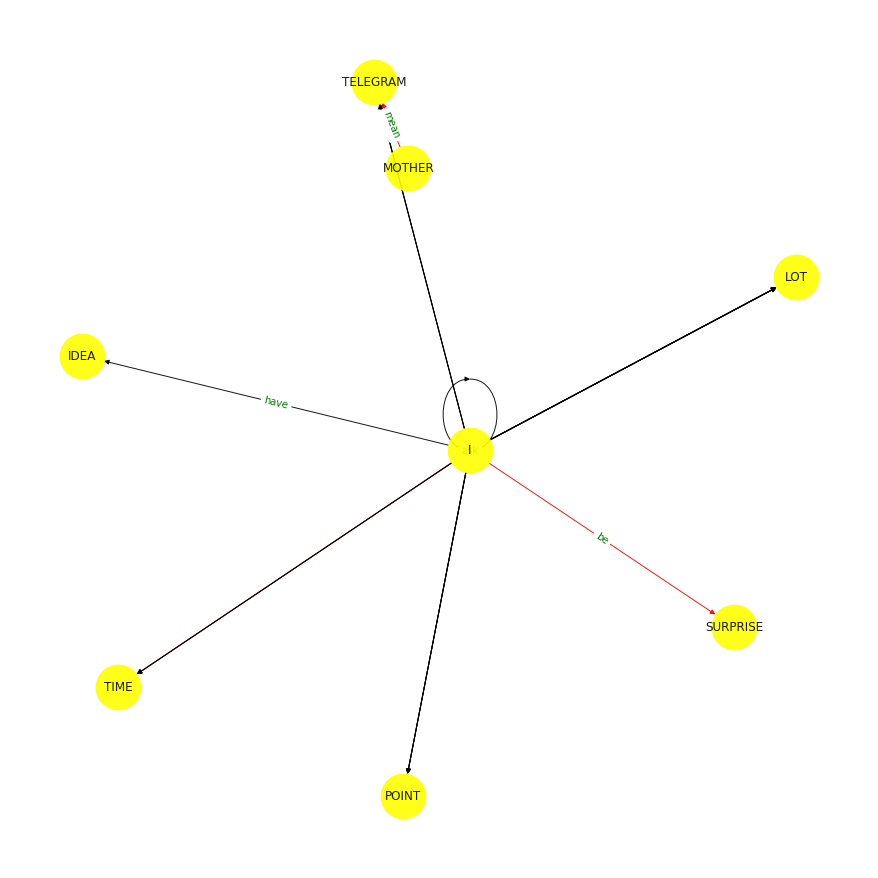

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. I don’t remember. But it means something.

I was at the cemetery. It’s a very small cemetery, and I was there for only about half an hour before I went back and got the telegram again. And then I went back and got a third and then a fourth and then a fifth. And then I got another telegram. And then I got a fifth telegram from the home.

And then I was at the cemetery and I was there for about an hour and then I went back and got another telegram. And then I went back and got another and then another and then another. And then I got a sixth telegram. And then I got another telegram.



And so it went. I went back and got another telegram and then I got another and then another. And then I got another telegram.



And it goes. And it went. And it went. And it went. I went back. And I got a six

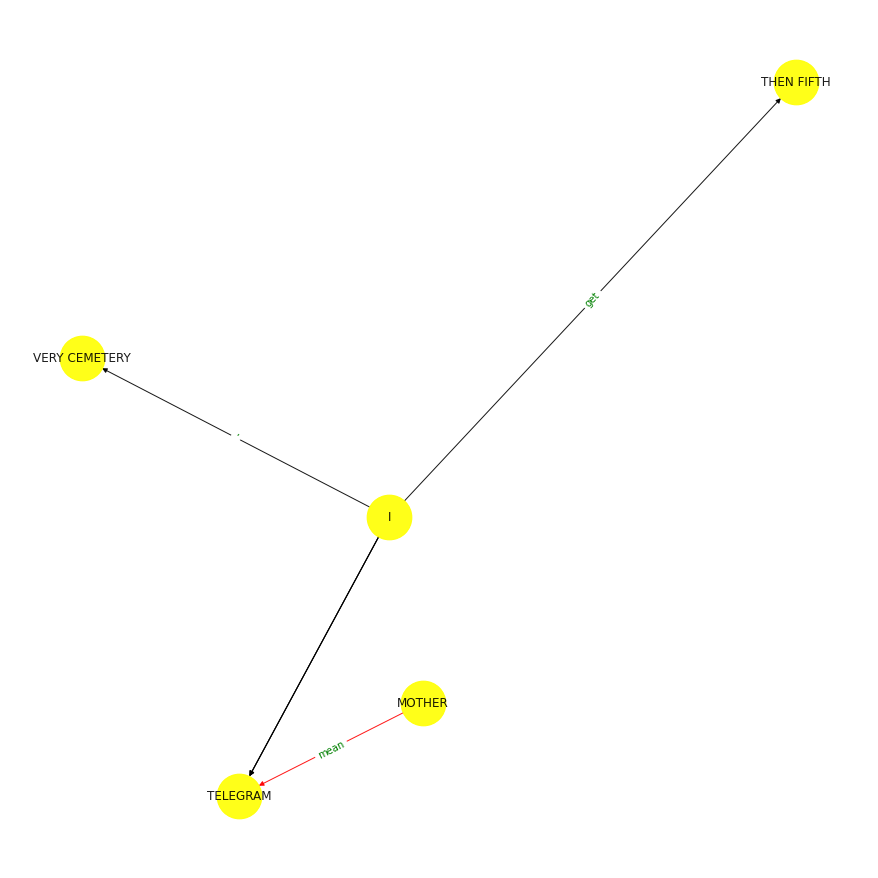

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. I have been here since yesterday and I don’t have any idea.”

‘The only thing that makes you sad,’ he continued, ‘is that I’ve been so stupid, I’ve been so stupid to leave you alone in the house, and to leave you alone in the house.’

‘What did you do?’ I interrupted.

‘I took the telegram to the home, and I read it. I read it and I said, “Oh my God!”’

I was shocked. He seemed genuinely shocked, and I felt like I knew him. I was so shocked, I was speechless. I could only think of one thing to say.

I asked, “Did you know her?”

“I knew her, of course, and I’m sorry.”

‘What are you sorry for?’ He said.

He seemed genuinely apologetic and I felt like I understood him. I felt that I did, and that I could understand him.

‘Why are you sorry?’ I asked, and I could not believe I had asked that, 

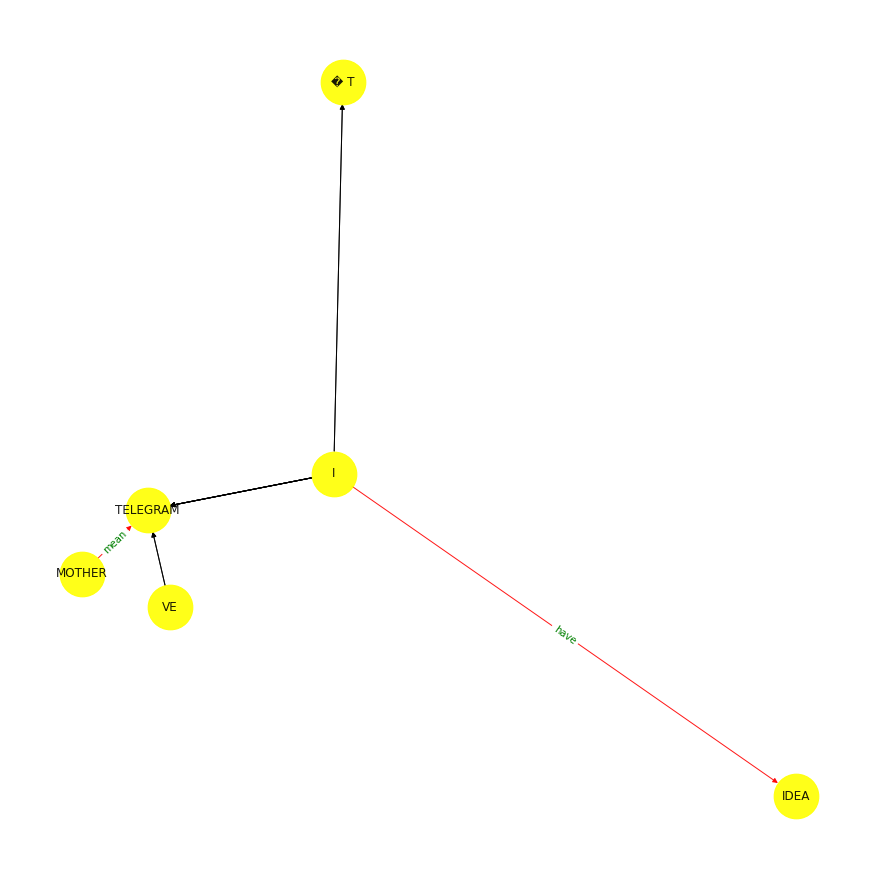

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. Or maybe not.”

“You’re not going to believe what I’m going to tell you,” said the old woman. “You’ll see.” She began to cry and sob. “I’m not going to tell you any more. I’m going to tell you this. I don’t know who you are or where you come from.”

“I’m a friend of the family,” said the boy.

“I’m a friend of the family, too,” said the old woman. “But that’s not important. What’s important is this: I’m not going to tell you any more.”

And that was the end of it.

The boy went back to bed. The old woman went back to bed.

The boy went back to sleep. The old woman went back to sleep.

The old woman went back to sleep.

The boy woke up and got up. He looked at the clock.

It was almost three in the morning. He looked at the clock. It was three in the morning. The clock said it was three in th

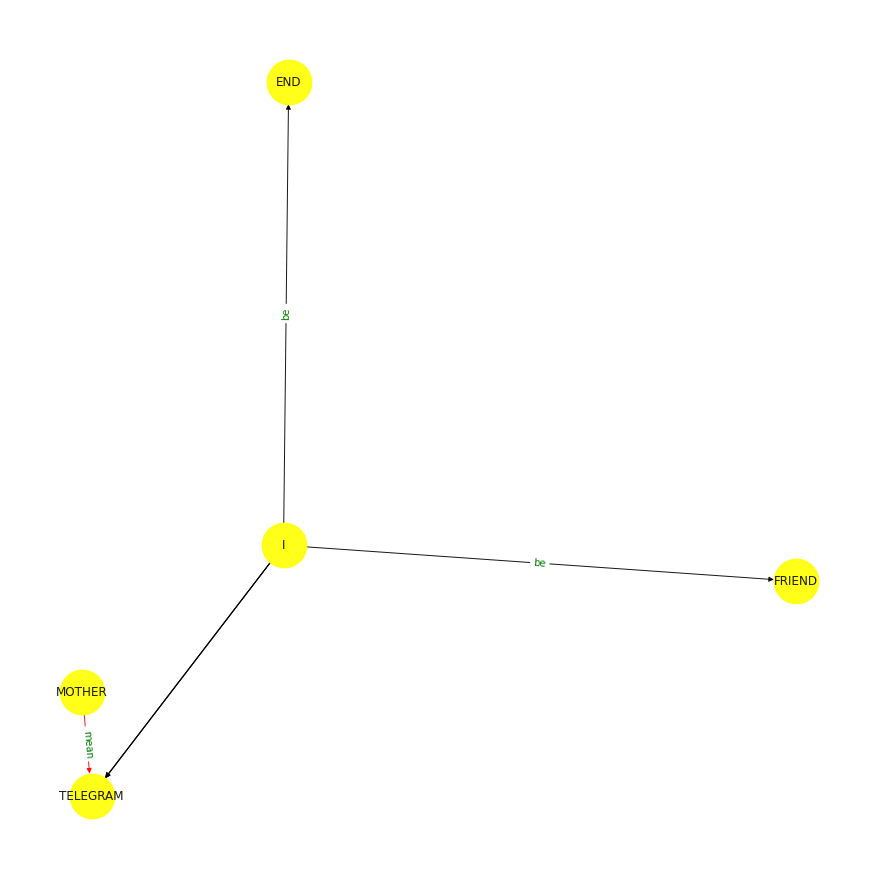

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. I have no idea where that came from. It’s been a while since I’ve heard that from anybody. But that was the telegram. And I had no idea what was going on, so I just went on. And I didn’t have time to get to any of the places. I just went on. And I was just going.”

I asked him if the telegram came from his wife, who he hadn’t seen in a long time.

“No, it wasn’t from my wife. I had a telegram from my wife. I didn’t see her. She didn’t write it. I had it from somebody in New York. But I had no idea that that was what it was. I didn’t know anything. I didn’t even know what it was until the day it came.”<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Q:

How do I use my own custom function to get a list of all the files in my 

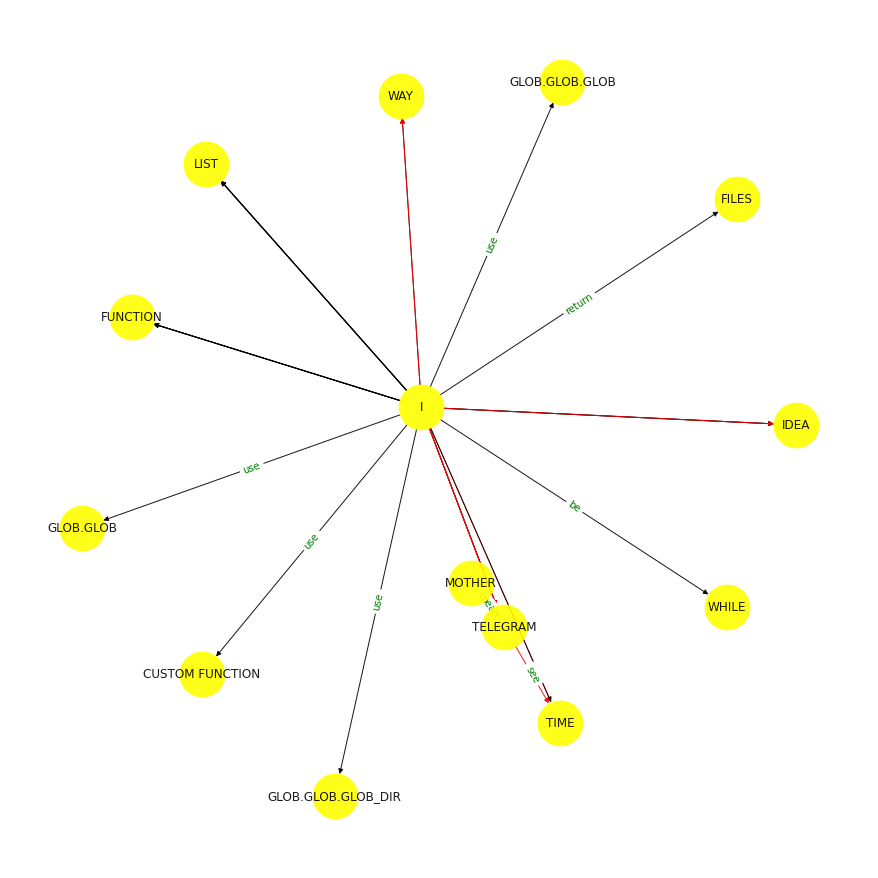

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. It may have been a few days ago. But that’s all the same.”

“I don’t know, but I know that she’s dead and that it’s my mother who�”

“Yes. It’s my mother. I don’t know if it’s your mother, I don’t know what it’s like to have someone die, but I know that my mother is dead. It is my mother. I don’t know how it is with her, I don’t care.”

“Yes, it’s my mother,” I said in a low voice. “I can see that you’re not going to cry, but you are, I see that.”

“Yes, it is my mother.”

“Yes?”

“Yes. It isn’t your mother, but it is my mother.” He paused. “I don’t know what it’s like to have someone die, but it is my mother.�”

I was silent.

He continued, “It’s my mother, I’m sorry.” Then he said, “It’s my mother, I’m sorry.�”

“No, I’m sorry. It isn’t your mother and it isn’t your mother’s body, but it i

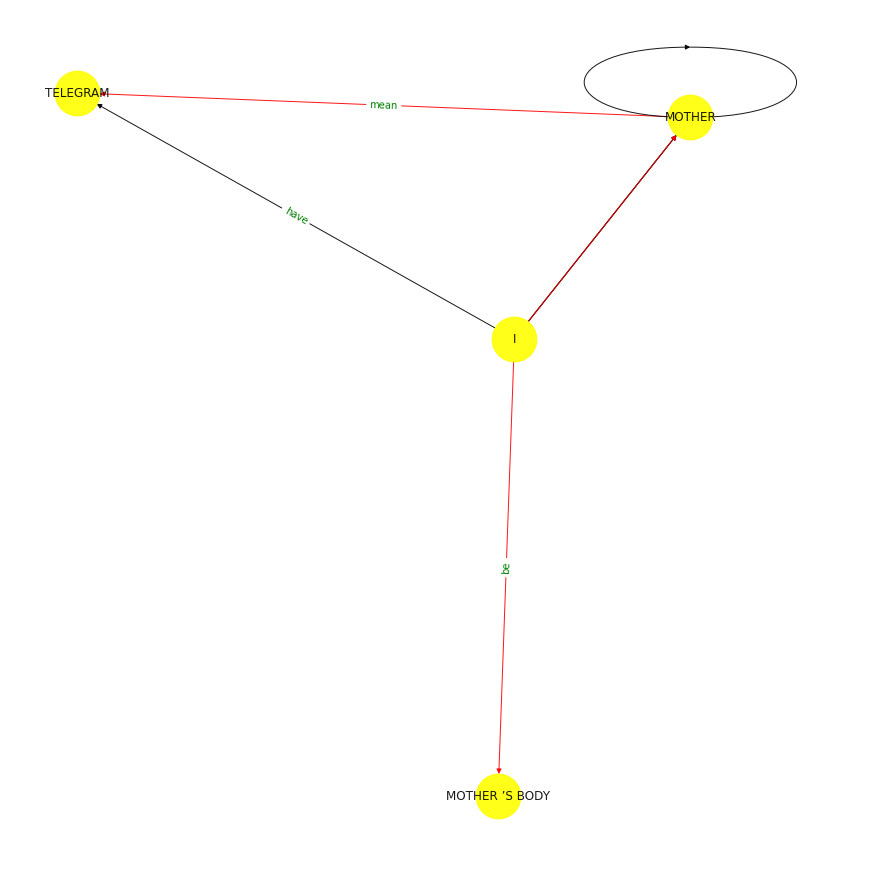

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. It may have been a week ago. It may have been ten days ago. I’m not a historian, you understand.”

I was so touched that he remembered. I said that the news had come to me in the middle of the night, that I had no idea of the time, of the place, but he said, “Oh, it wasn’t a very long time ago. It was a year ago.”

“I can’t imagine how you can’t,” he added.

“I was very young. I was very young. I had no idea.”

He said that he’d always thought of the two of us as being so much older than we actually were, and that he was so sorry to have thought that I’d never been a historian.

I was so touched that he remembered. I said that the news had come to me in the middle of the night, that I had no idea of the time, of the place, but he said, “Oh, it wasn’t a very long time ago. It was a year ago.”

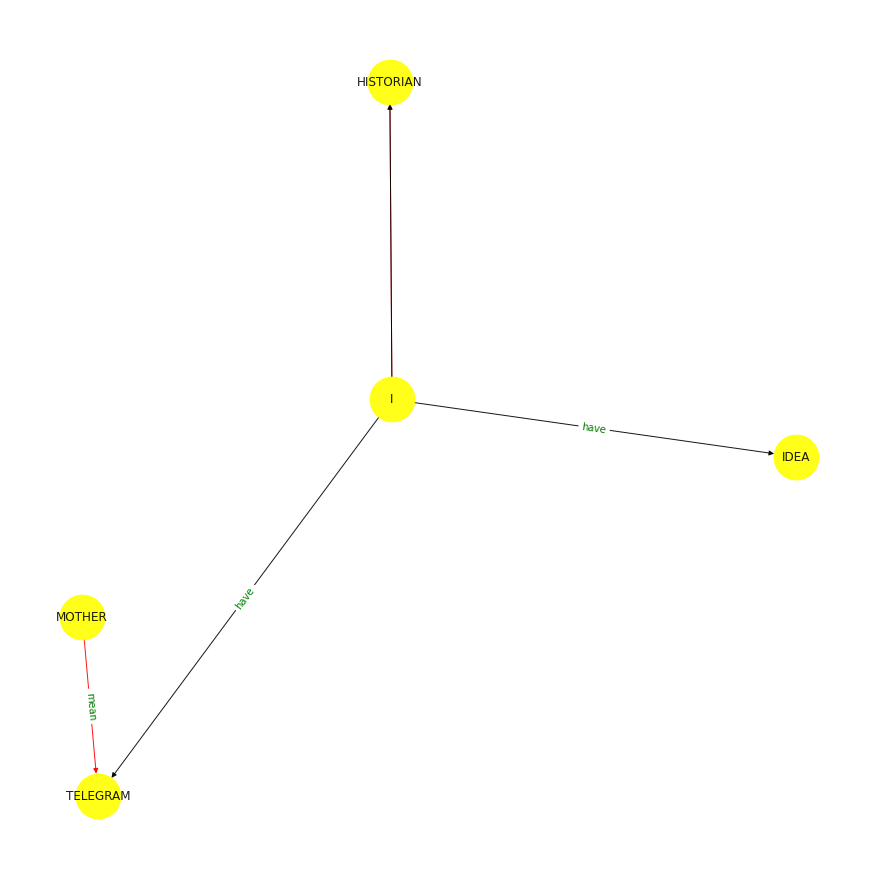

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_2, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-en

Mother died today. Or maybe yesterday, I don’t know. I had a telegram from the home: ‘Mother passed away. Funeral tomorrow. Yours sincerely.’ That doesn’t mean anything. It may have been yesterday. I can’t be sure. But it’s not the same. It’s not the same as when she was alive, and it doesn’t mean anything.”

The last time I heard from her was on the night of the funeral, when I had to go to the office to collect the mail. I told her I was sorry to hear it. She said she was sorry, too. “I know you are,” she said, “but it is so sad. You know, I was a little bit afraid of her. I thought she was going to take me. But she never did. I don’t know what I was afraid of. It’s so strange. I don’t understand why I was so afraid of her. I don’t understand why. She never hurt me.”

I don’t know if that was true. I don’t really know what happened.

But she never hurt me. I don’t know if that was true. I don’t really know.

I think she hurt me a little, but I think she was just afraid. I think she j

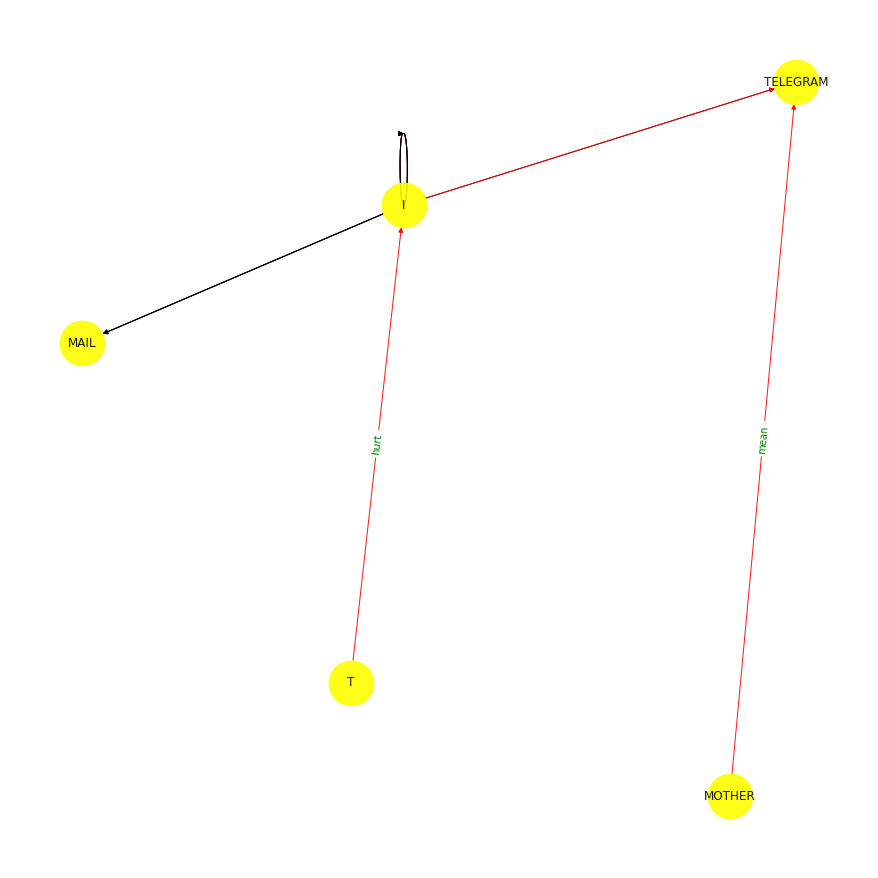

In [ ]:
kg.visualize()

#### Testing prompt_3

It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York


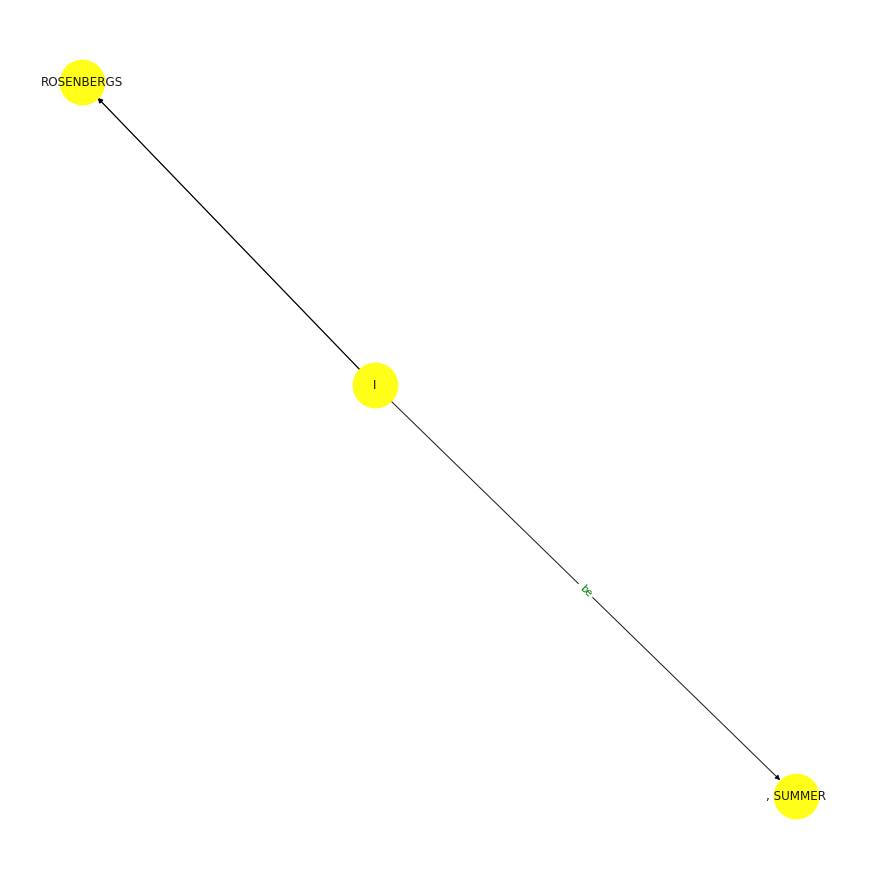

In [ ]:
kg = KnowledgeGraph(prompt_3)
print(prompt_3)
kg.visualize()

In [ ]:
default_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, default_scoring_fn, get_candidates__default)
print(default_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York. I was in New York because I had a friend who lived on the Upper East Side, and she had been to the city. She told me, “I’m going to see you at the Museum of Natural History. I�d love to meet you.” I went to the museum, and I was surprised at the number of people who were there, but I was also surprised to see how many people were in the museum. I was surprised because I didn’t really know what I was doing in New York. I’m a little bit of a loner, and I’m a little bit of an introvert, and I’m also a little bit of a geek. I like books and movies and music, but I’d never been to a place that had so many people in it. It was a very, very strange place, and I’m not sure why, but I was really surprised.

Q: You have a book out called, “The Book of the Dead.” It has a lot of stories in the book, but the book has a lot of other things in it. What is the book about?



A: 

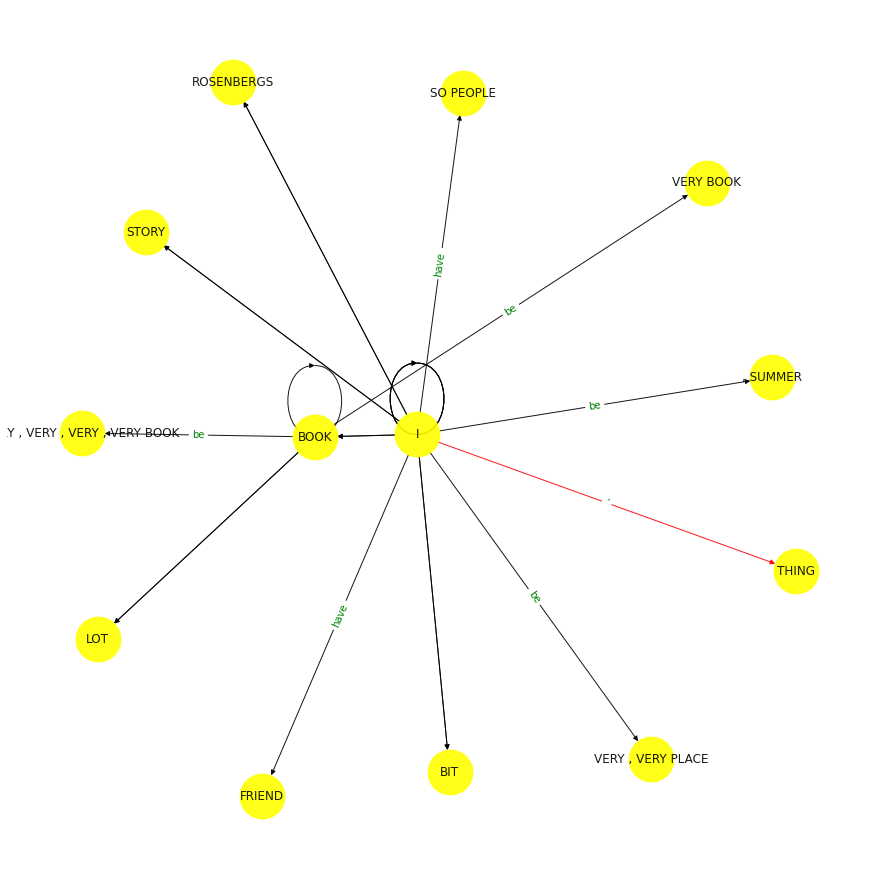

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York, but I knew I was doing something. I didn’t know what it was, but I knew it was something. It was a summer I didn’t have a job or any money to pay the electric bill, I was working as a bartender in a bar, and I knew I was doing something, but I didn’t know what it was, and I didn’t have any idea what I was doing, but I was doing something, and I was doing something, and I was doing something, and I was doing something.

I was doing something, and I was doing something.

I was doing something, and I was doing something.

I was doing something, and I was doing something, and I was doing something, and I was doing something, and I was doing something.

I was doing something, and I was doing something, and I was doing something, and I was doing something.

I was doing something, and I was doing something, and I was doing something, and I was doing something, and I was 

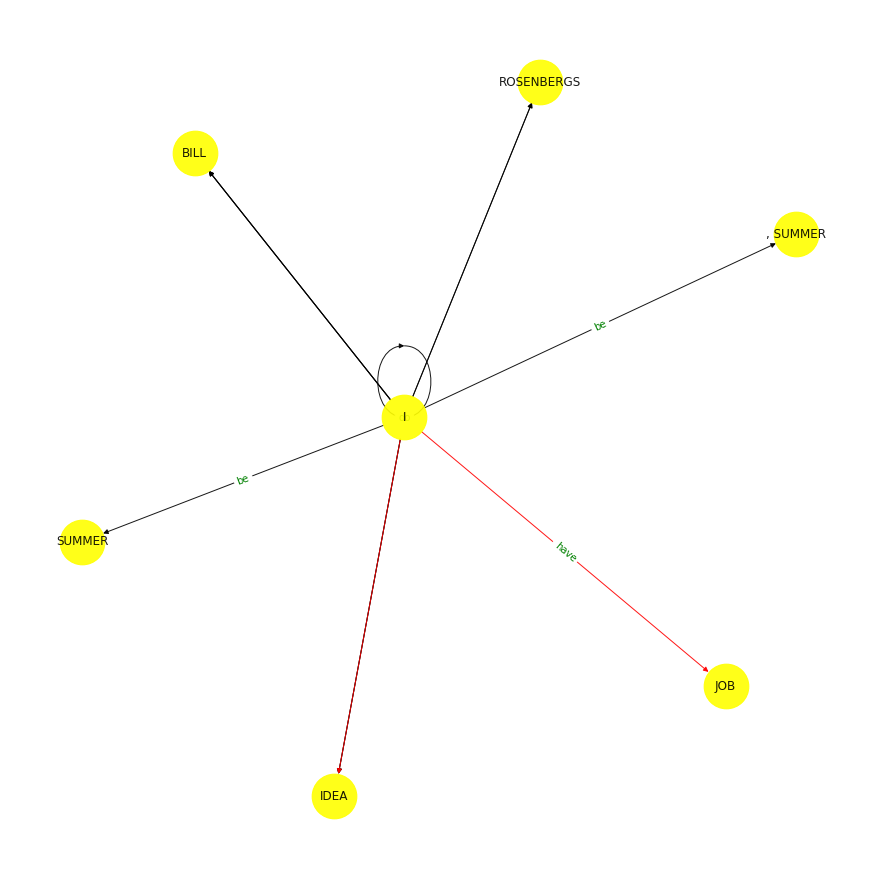

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York. The first time I ever saw the Rosenbergs, it was in a movie theater in the Village. I was in my early thirties, and I had just come back from a year in Paris. I was in a movie, and I was in New York, and it was a movie about a Jewish couple who were being persecuted. And I remember that it was a movie about a couple, and they were being persecuted for being Jewish, and I remember thinking, “This isn�t a movie about a couple.” And then I went to see it. And I remember being so surprised by it and so disturbed by it, and I remember thinking, “This is a movie about a couple!” And I was in the theater for two hours, and I remember being in the middle of it and thinking, “This is not what I expected.” And I remember thinking, “This is not what I expected. This is a movie about a couple.” And it was a couple. And it wasn�t a couple of Jewish people. It was just two peop

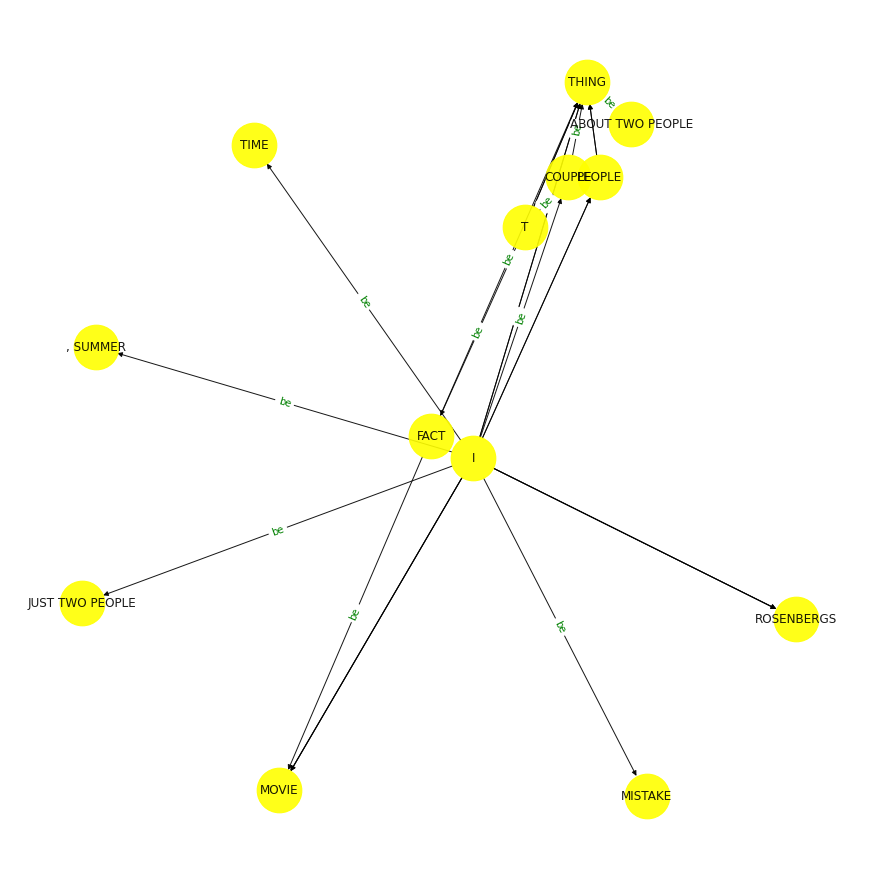

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York, I was just a kid in the middle of the country, and I was in New York to do what I wanted.

And that’s when it started.

It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York, I just was just a kid in the middle of the country, and I was in New York to do what I wanted. I was in my apartment on West 23rd Street, I was in the middle of the country and I was in New York to do what I wanted. I was in the middle of the country, I was in New York to do what I wanted. I was in the middle of the country, I was in New York to do what I wanted. I was in the middle of the country, I was in New York to do what I wanted. It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York, I just was just a kid in the middle of the country, and I was in Ne

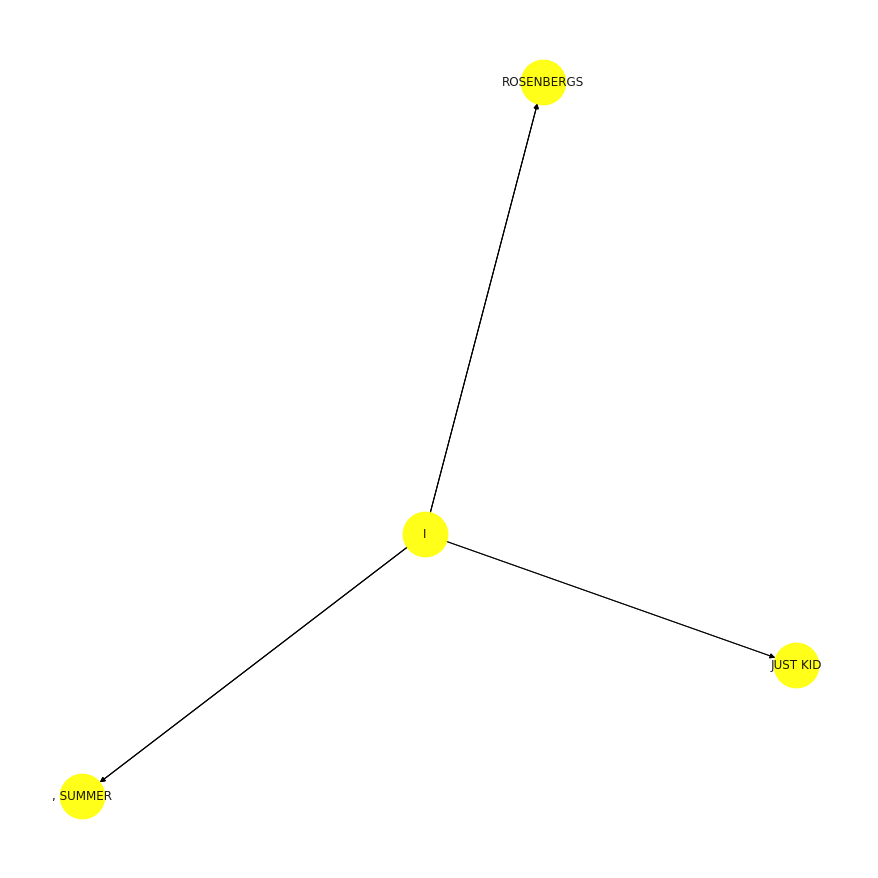

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York. I was a student, I was in the middle of a summer program, and the summer I was at the New School for Social Research, and the Rosenbergs were on trial.

I was in the middle of a summer program in sociology, and the Rosenberg trial was in the middle of my summer. I was in the middle of a trial, and the Rosenbergs were on trial. It was the summer of the trial, and I wasn’t sure what to do, but I didn’t know what to do.

I was in the middle. I didn’t know what to do.

The Rosenbergs had been arrested in the summer of 1940, and were convicted and sentenced to death. I didn’t know what I was doing.

The Rosenbergs had been arrested in the summer of 1940, and were convicted and sentenced to death. I didn’t know what to do.

I didn’t know what to do. I was in the middle of a trial.

The Rosenbergs had been arrested in the summer of 1940, and were convicted and sentenced 

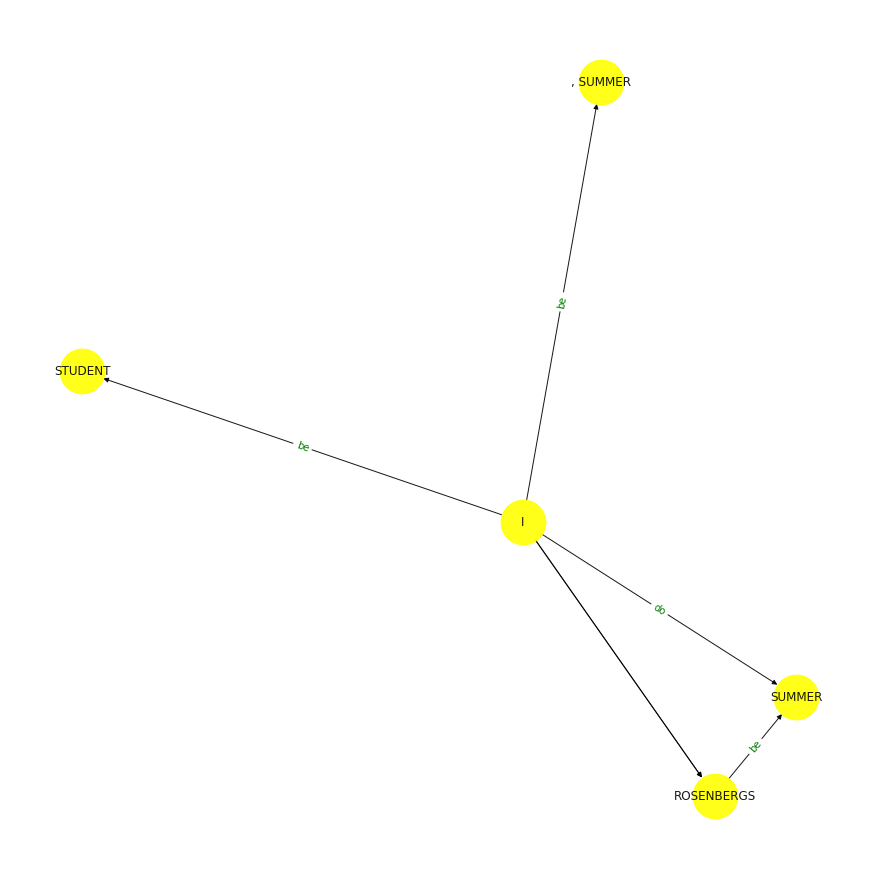

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York, but I was doing something, I wasn’t doing anything at all, I was just being myself, I was being myself, and I was being myself, because I was being myself, I was being myself, and I wasn’t doing anything but being me.

I had no idea that I was being myself. It’s a very strange feeling, being yourself, being yourself and being yourself and being yourself. It was a strange time, it was a strange time, but I wasn’t doing anything, I was just being me, and I was being me, and I was being me, and I was being me, because I was being myself, I was being me, and I wasn�t doing anything.

I had no idea that I was being me. I was just me. I was just me, and I was me. I was being me. I was being me, because I was me, I was me, and I was me, and I was me, I was me.

I was me. I was me, and I was me. I was me. I was me.

I was me. I was me and I was me,

and I was me. I was me

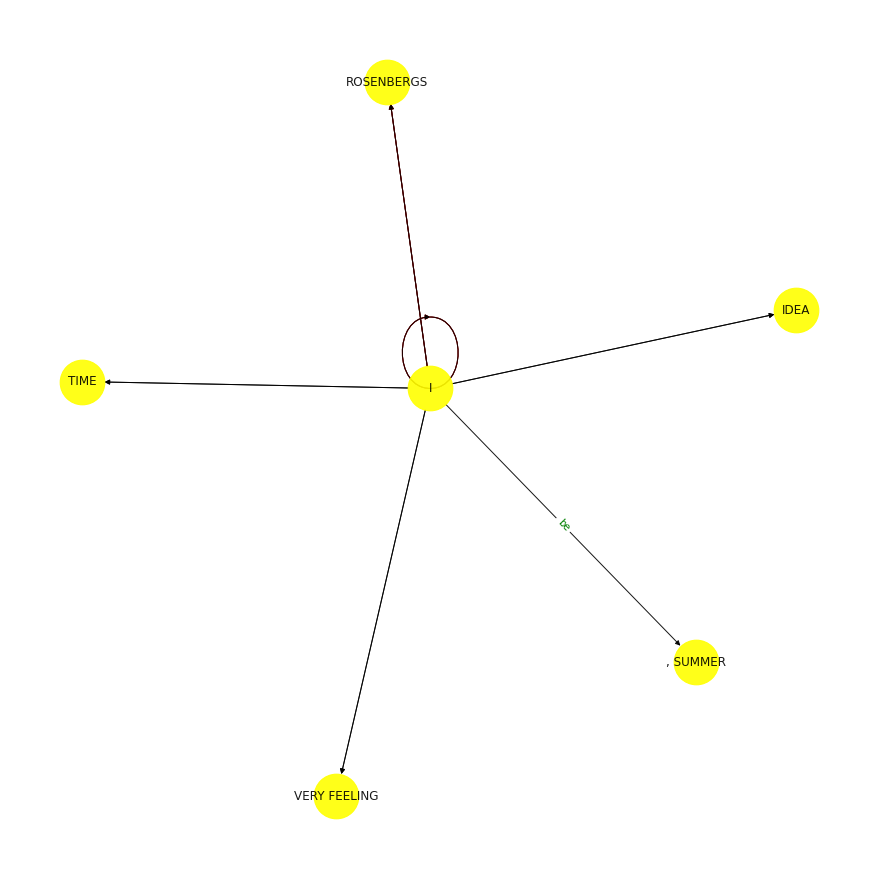

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York.

I didn’t know what I was doing in New York. But I did know that I was living in a city with a lot of things to see and do and do well. And it was a lot of things to do well, and it was a lot of things to see and do and do well. So I decided I was going to go to New York and do some things.

The first thing I did was go to the Museum of Modern Art, where I saw a bunch of things. I went to the Museum of Modern Art to go to a museum and see things, and I saw the Museum of Modern Art and I saw a lot of things. But one thing I saw that I thought I would like, which is a lot of the things that you see in movies, I saw a lot of things that I thought I would like.

So the next thing that I did was go to the Metropolitan Museum of Art, which was a big, huge, beautiful thing. It was a museum that had a lot of different kinds of things in it. And I saw a lot of different th

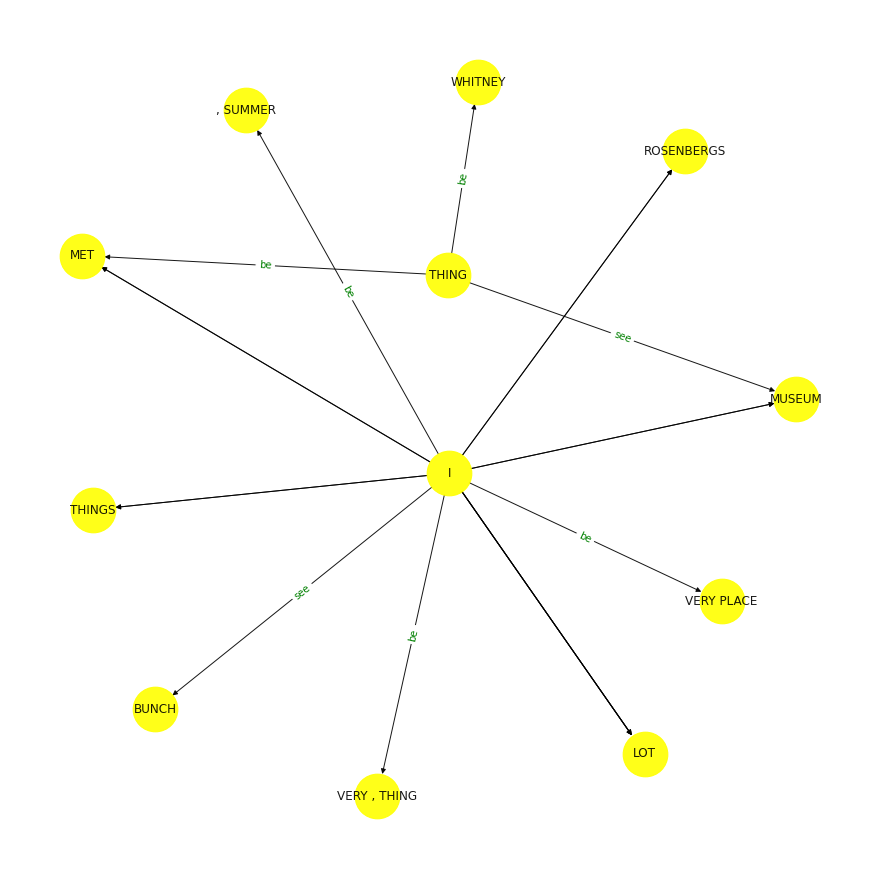

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York City, and I had never seen anything like it.

JULIUS: I had been to the movies.

ROSENBERG: I had been to the movies.

JULIUS: And I had gone to the movies, but I had never seen anything like it. It was a queer, sultry summer.

JOSEPH: You’ll have the same problem.

JULIUS: The same problem.

ROSENBERG: You’ll have the same problem.

JOSEPH: I don’t know what I was thinking.

ROSENBERG: You’ll have the same problem.

JOSEPH: You’ll have the same problem.

ROSENBERG: I don’t know what I was thinking.

JOSEPH: You’ll have the same problem.

ROSENBERG: You’ll have the same problem.

JOSEPH: I don’t know what I was thinking.

ROSENBERG: You’ll have the same problem.

JOSEPH: You’ll have the same problem.

ROSENBERG: I don’t know what I was thinking.

JULIUS: It was an interesting experiment. I’ve never seen anything quite like it.

ROSENBERG: You’ll have the same probl

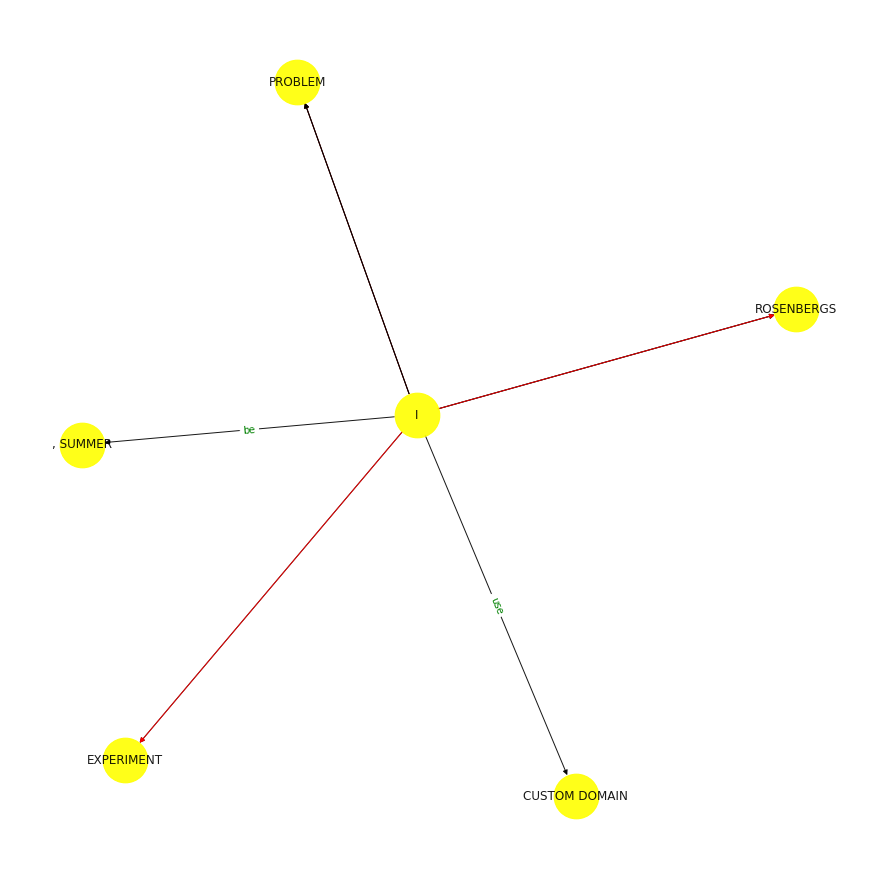

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_3, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-en

It was a queer, sultry summer, the summer they electrocuted the Rosenbergs, and I didn’t know what I was doing in New York. I had been invited to a party at the home of the writer and director William Friedkin in the East Village, and I was supposed to go. But I was a stranger, an out-of-towner who didn’t know anyone in New York.

I had a friend, a girl from Chicago named Jennifer, who had been in New York a few months. I was supposed to meet her for coffee at a restaurant near Central Park. But when we got to the place, I realized she’d already left. I didn’t even see her get out of the car. I was so upset that I didn’t even try to find her. I went back to my apartment to get my things, and then I called Jennifer. I was afraid that if I didn’t go, I would go to jail, and then she would leave me.

She was at her apartment, so I called her again. I was crying and I was so afraid that she would leave me. I called again and then I called again. She didn’t leave. She was in the shower. I w

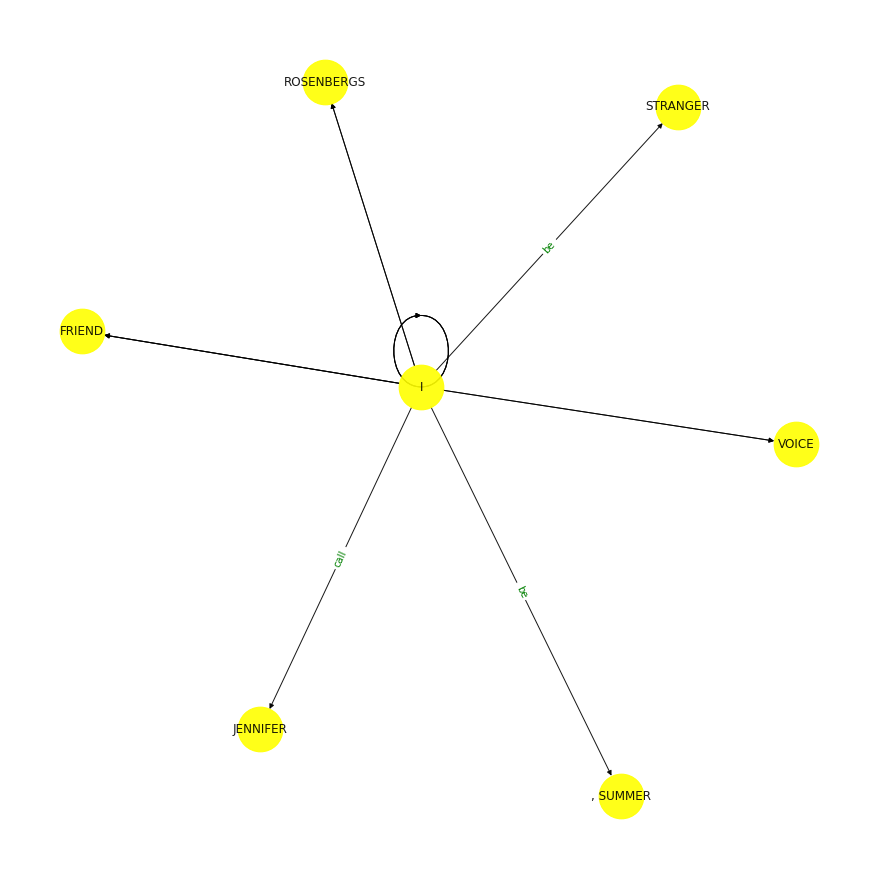

In [ ]:
kg.visualize()

#### Testing prompt_4

Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice.


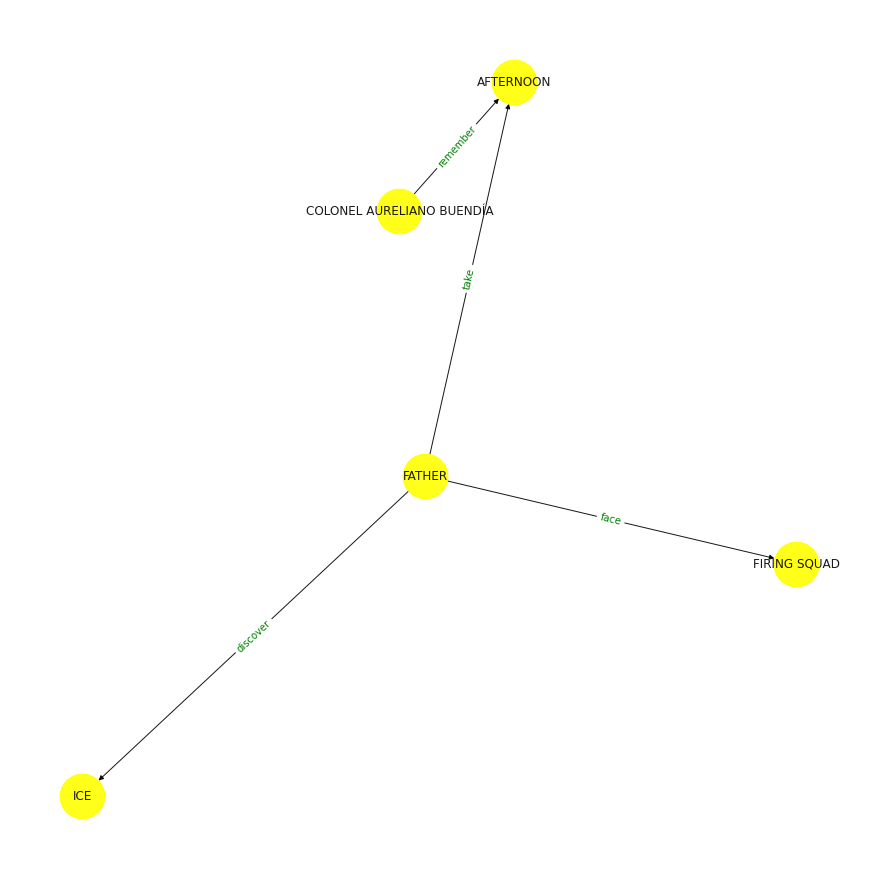

In [ ]:
kg = KnowledgeGraph(prompt_4)
print(prompt_4)
kg.visualize()

In [ ]:
default_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, default_scoring_fn, get_candidates__default)
print(default_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice.

“I was about five years old when I discovered ice in the river,” Buendía said. He was in his 20s then, but he was already an experienced fisherman. His father had been a fisherman and, in turn, Buendía’s father had also been a soldier.

“My father was very good at the job. He knew all the places where ice was. He knew where it was in the river. He knew what the ice looked like,” said Buendía, who has been a member of the National Ice Fishing Federation, which he founded in the 1970s and has been its president since 2000.

“I learned from him. I learned from him,” Buendía added.

Buendía’s father, Josefito Buendía, was a fisherman in the village of El Pescador, in El Salvador. In the 1970s, he was sent to Guatemala to help with the civil war there.

Josefito Buendía was a member of the National Ice Fishing Federation, founded in 1970

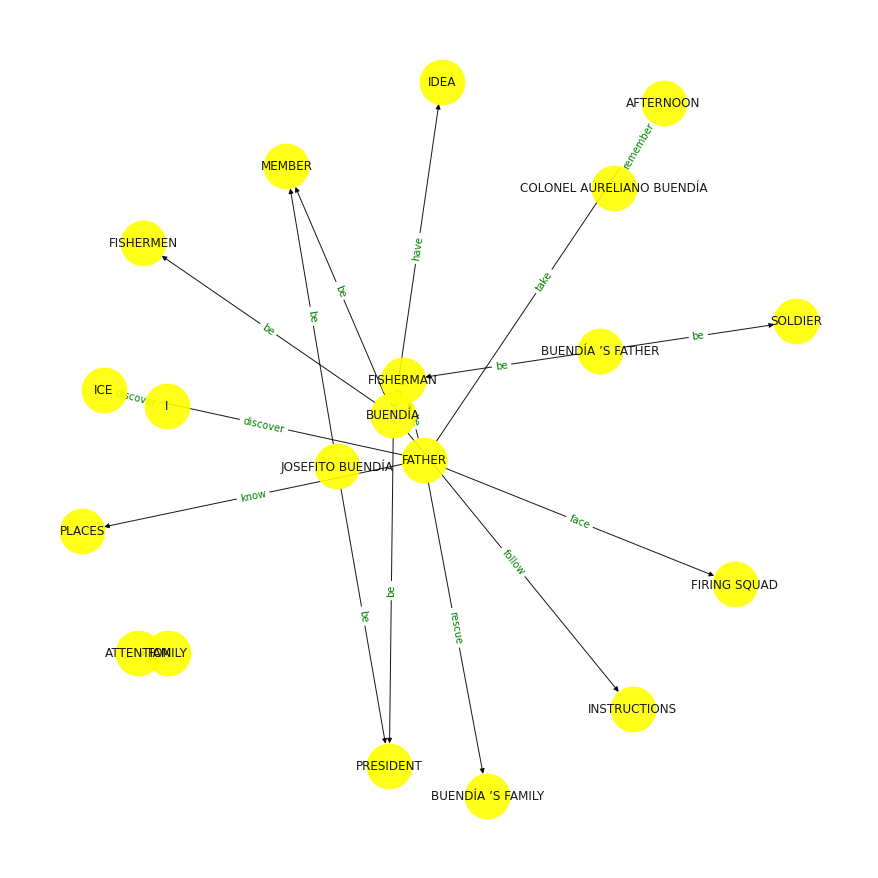

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice. It was the first day of his childhood and he was to be a boy of nine.

He remembers his father, a man of few words and no interest in the world beyond his own small town, telling him that he had come across a large block of ice in a river.

“My father said it was an ice block that he had brought to the ice house and had been told to bring it inside the house,” Buendía said. “But I was not allowed to touch it. My father said, ‘You will never touch this ice.’”

He remembered the ice block as a small piece of white paper, but he didn’t know what to think. He was to be a boy of nine.

He remembers his father, a man of few words and no interest in the world beyond his own small town, telling him that he had come across a large block of ice in a river. It was an ice block that he had brought to the ice house and had been told to bring it i

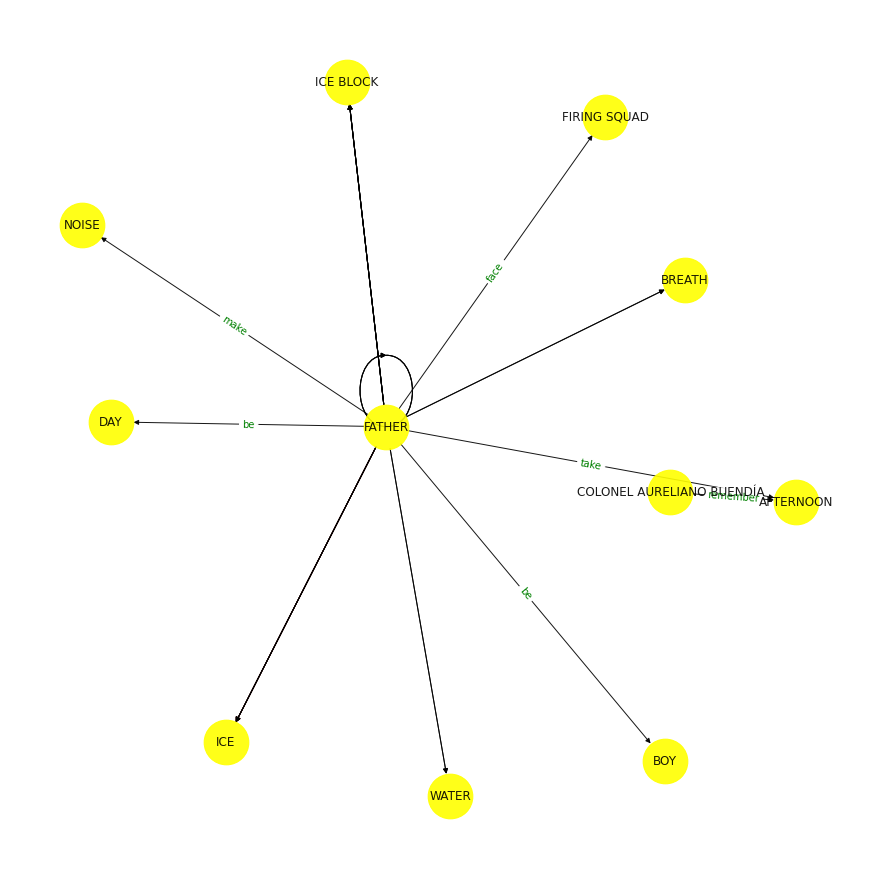

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice. “I don’t know what my father thought when he took my hand,” Aureliano Buendía, now in his late seventies, told me. “But I do know what he thought when he took me to the ice. He thought it was good, and he thought that he could get ice for us. And he got ice.”

In the years since, Buendía, now the president of the Dominican Republic’s ice industry association, has been a tireless crusader for his country’s ice industry and for ice preservation. In his book, “Ice,” he recounts the story of how his father took him to find ice in a remote part of the Dominican Republic, and the story of the ice his father brought. “He brought ice from the sea,” said Buendía, “and he brought it from the land, from a place that was so far away, so inaccessible. It was an incredible thing that he did. It was like he took us to a place where there was no ice

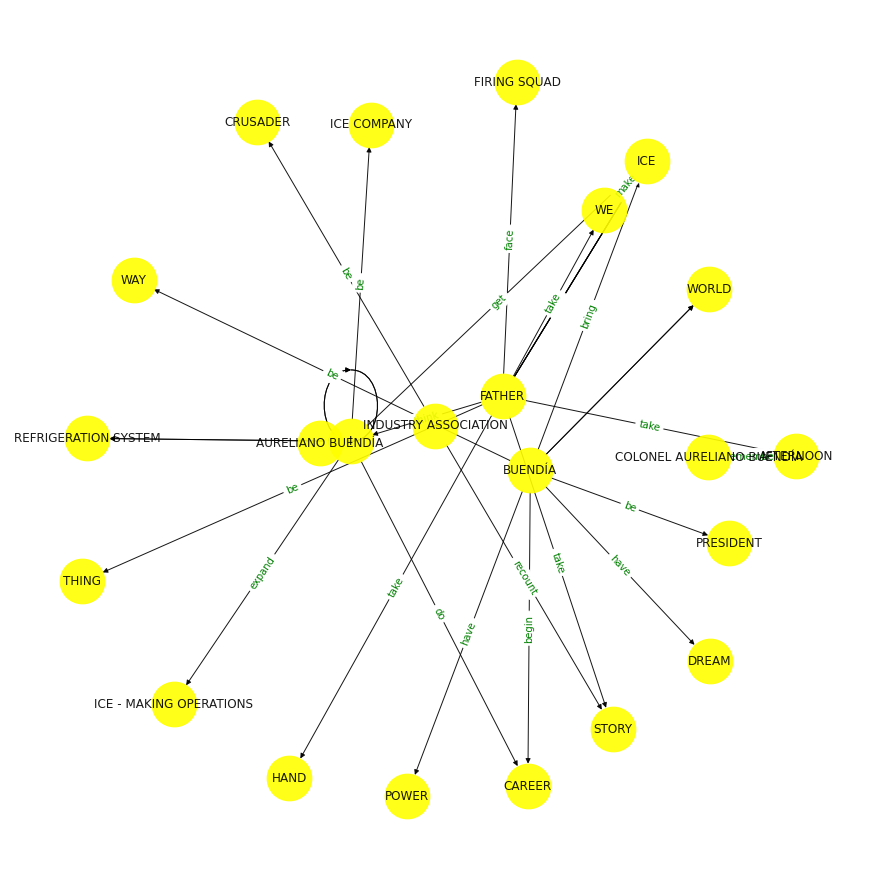

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice.

He remembered the way the ice looked as he held it in his hands, and the way he felt as the ice melted, and the way it felt as the sun warmed the ice as the ice melted.

He remembered the ice that his father took him to find, that he held as he watched it melt, and the ice that melted as he watched it melt and the sun warm it.

He remembered the ice that his father took him to find, the ice that he held as he watched it melt and the sun warm it and the ice that melted as the ice melted and the sun warmed it.

He remembered the ice that his father took him to find, the ice that he held as he watched it melt and the sun warmed it and the ice that melted as the ice cooled and the sun warmed it, and then, when he saw it all melt, he saw that it had become ice.

He remembered how his father had held the ice as the sun melted it, how the 

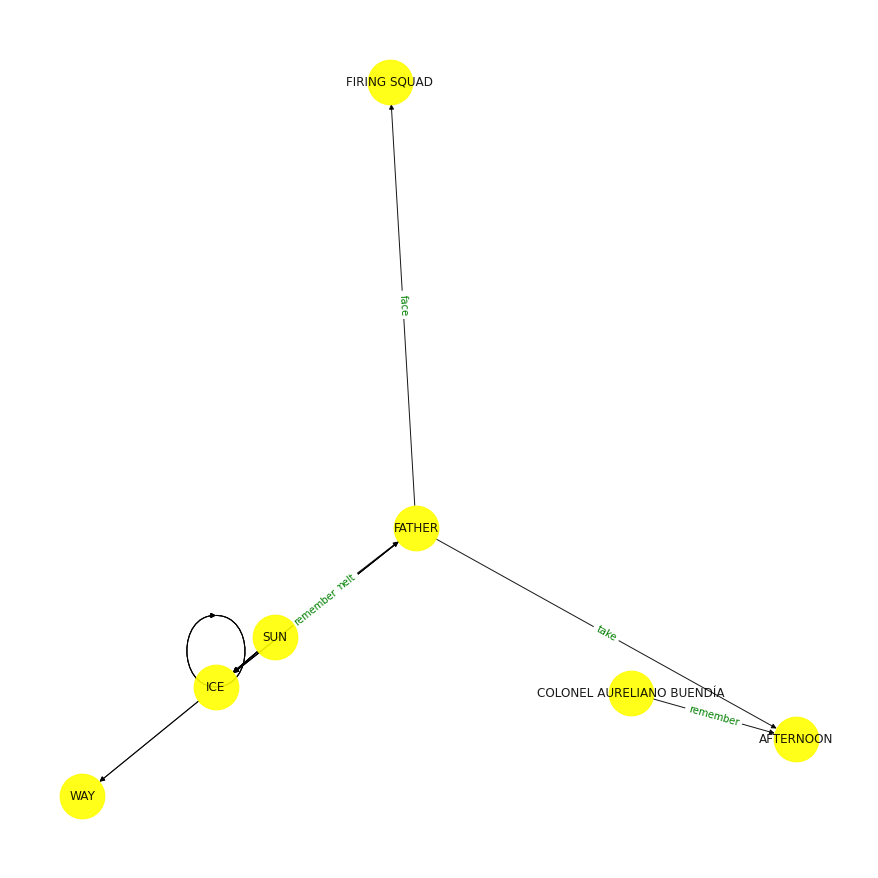

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice. “My father was the one who took me there,” he told me, “and I was the one who took him to the ice cream shop.” He said his father was the one who taught him the ice cream�s secret: that it was the best ice cream on the planet.

“He told me that if I wanted ice cream, I could go to the ice cream shop,” Buendía told me. “And if you wanted ice cream, I could give it to you.”

Buendía’s father, a retired military colonel, was born in the town of Santa Cruz, in the northern part of the country of Ecuador, and he was the one who taught him how to make ice cream. His family was from the town of San Juan del Sur, where the ice cream shop he remembers so fondly is located.

“My mother was the first one to teach me to make ice cream,” Buendía said, “and she was the one who taught me that it wasn�t the same as what I was used to.”

Buendía, who

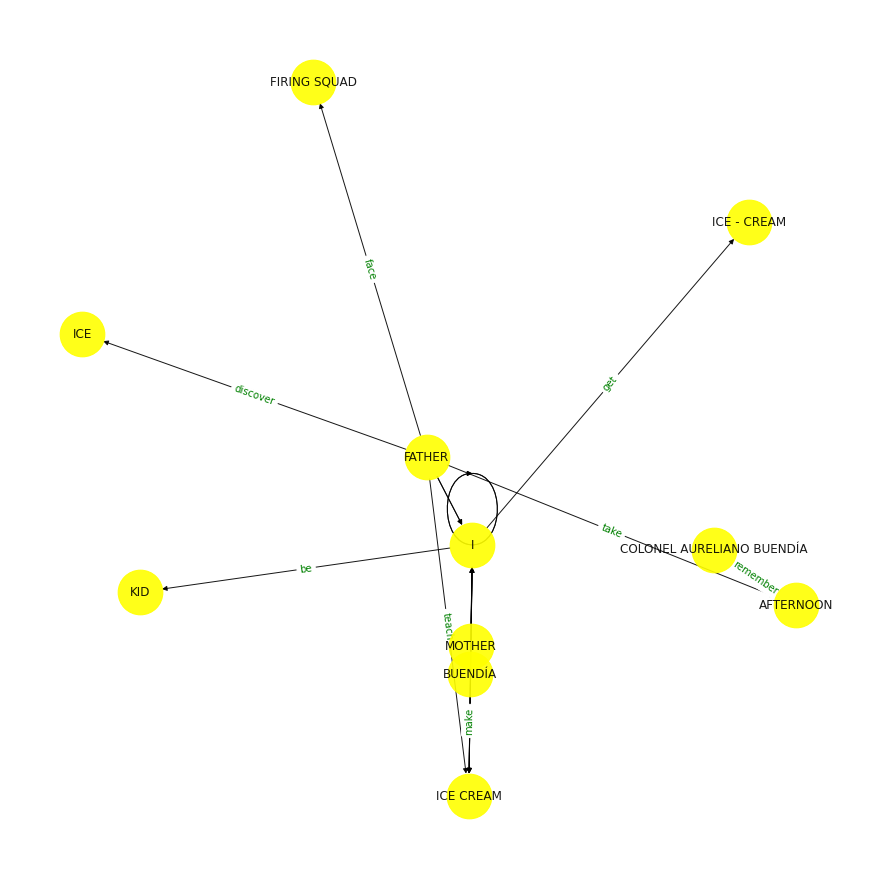

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice. He would remember the moment he had to face the firing squad. And he would remember, as he was about to be executed, the moment when his father took him to discover ice.

FATHER  father   
FATHER  father   
father   
father   
father  father   
father

He would have to be a soldier to be able to face the firing squad.

And so he was, a soldier.

He was also a soldier to be executed.

He would have to be a soldier to face death.

He would be a soldier to face death.

He would be a soldier to face death.

FATHER  father  father

The colonel was a soldier who could face death. He had to be a soldier who could face death. But he could also be a soldier who could face death.

And so he was a soldier.

And so he was a soldier to face death.

And so he was a soldier to be a soldier.

He was a soldier to face death.

And he had to be a soldi

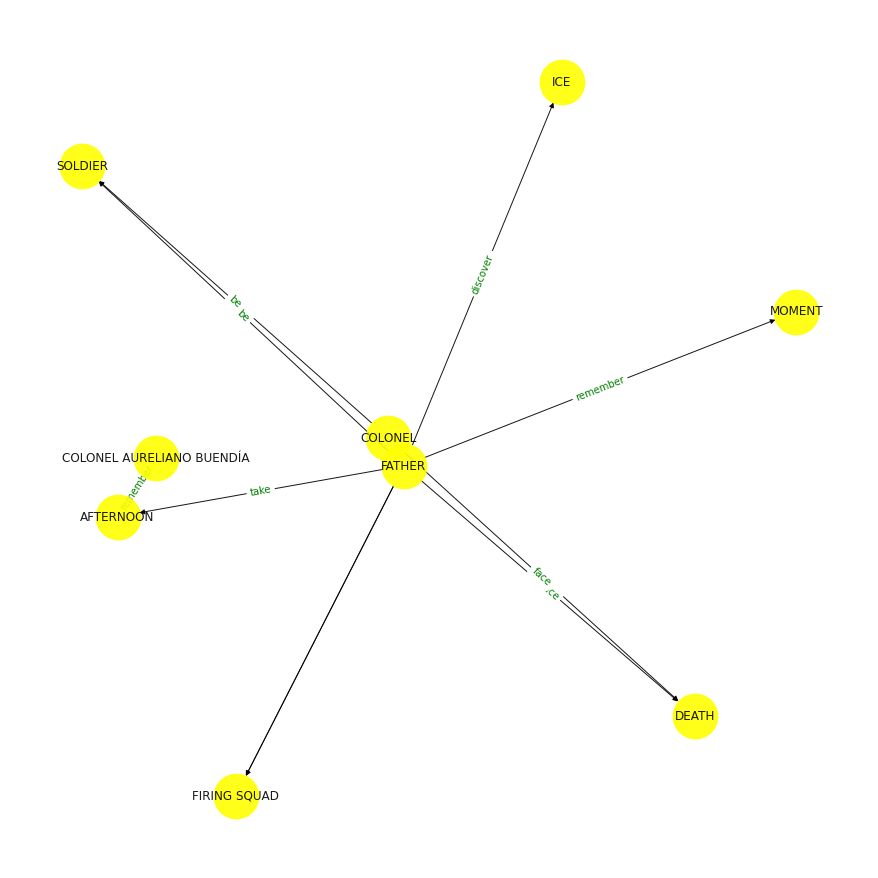

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice. He was to recall the moment when he was to discover ice, the moment when his father took him to discover ice in the snow, the moment when his father took him to discover ice in a snowstorm, the snowstorm that was the moment that his father took him to discover ice.

FATHER  take ICEMany years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice, the moment when his father took him to discover ice in the snow, the snowstorm that was the moment that his father took him to discover ice.

FATHER  discover ICEMany years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice, the moment when his father took him to discover ice in the snow, the snowstorm that was th

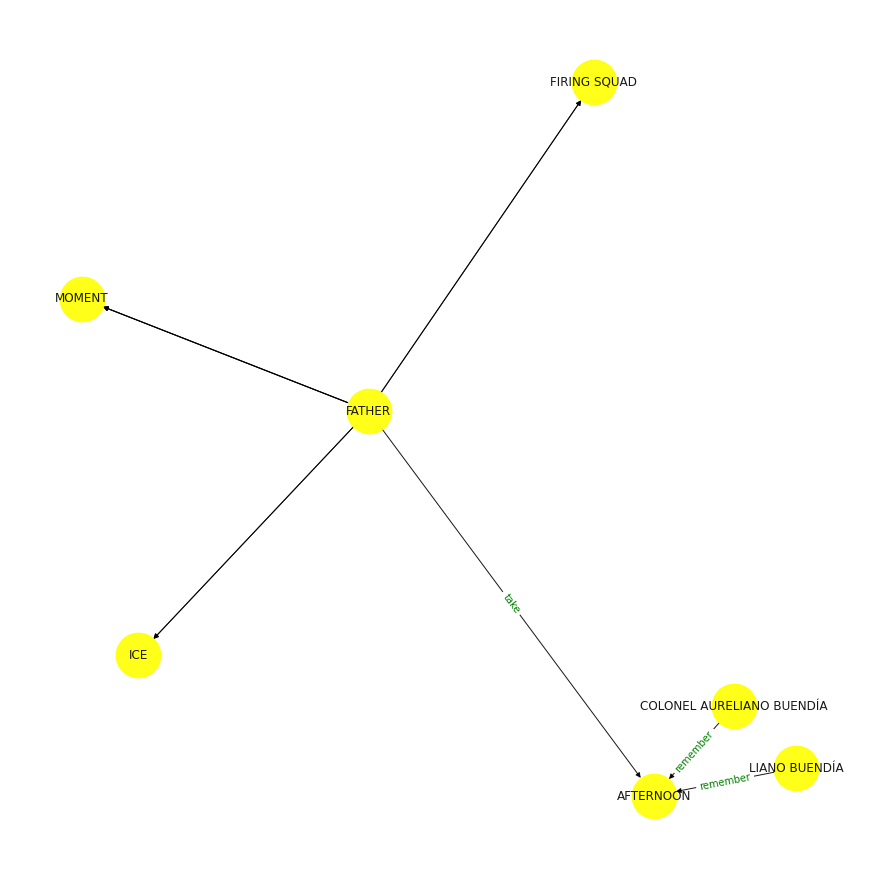

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice.



"Father!" he called. "Come to me. Come!"



"Come to me," his father repeated.



And then he was to remember that afternoon, when his father was to take him to discover ice.



And he was to remember that afternoon when he and his father would take him to discover ice.





"FATHER!"



And then the firing squad was to remember the day that his father was to take him to discover ice.



And he was to remember that afternoon when he and his father were to take him to discover ice.





"Father!"



And then the firing squad was to remember the day that his father was to take him to discover ice.



And he was to remember that afternoon when he and his father took him to discover ice.





"Father!"



And then the firing squad was to remember the day that his father was to take him to discover ice.



And he was to remember that a

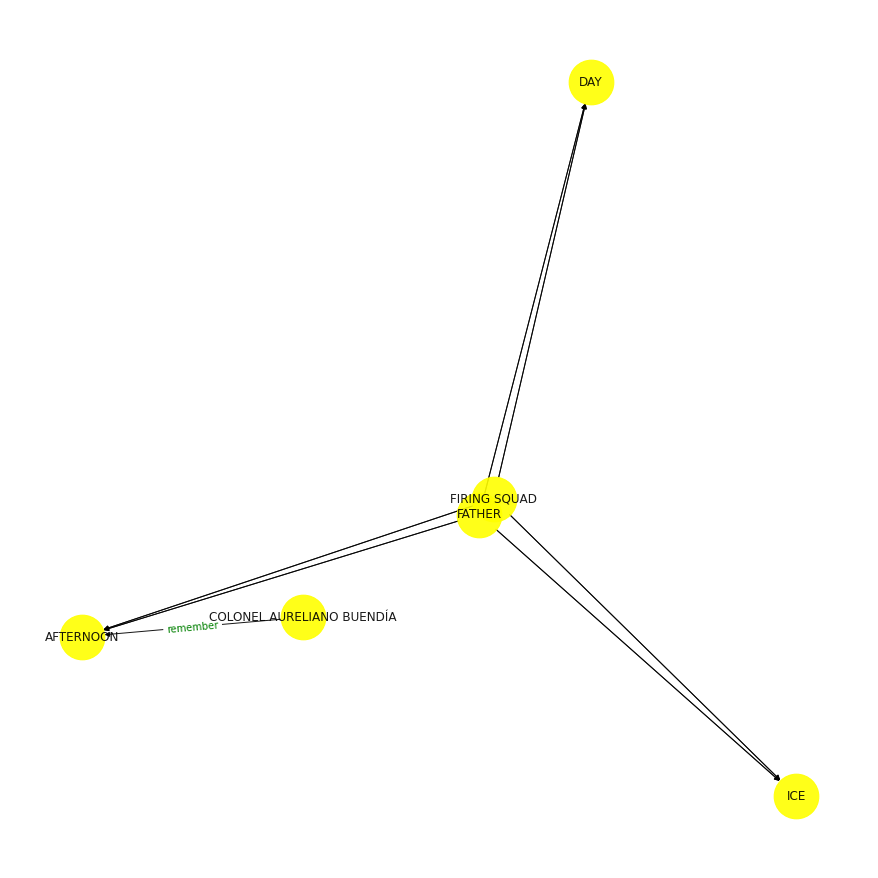

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_4, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-en

Many years later, as he faced the firing squad, Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice.

FATHER  father, father! I'm so sorry. I didn't mean any of it. You know I love you and I'm so sorry. But, please don't be angry. It's not your fault. I'm so sorry.

FATHER  please don't be angry. Please. I'm so sorry.

FATHER  father. Please. Please forgive me. Please, father. Please. Please forgive me. I'm so sorry. I'm so sorry.

FATHER  I'm sorry. Father.

FATHER  I'm so sorry, father. Please forgive me. Please, father, forgive me. I'm so sorry.

FATHER  I'm so sorry, father, forgive me. Please forgive me.

FATHER  I'm so sorry, father. Please forgive me.

FATHER  Father. Please forgive me.

FATHER  I'm so sorry, father. Please forgive me. I'm so sorry.

FATHER  I'm so sorry, father. Please forgive me. Please, father. Please forgive me. I'm so sorry.

FATHER  Father. Please forgive me. Father. I'm so sorry. I'm so sorry. I'm so s

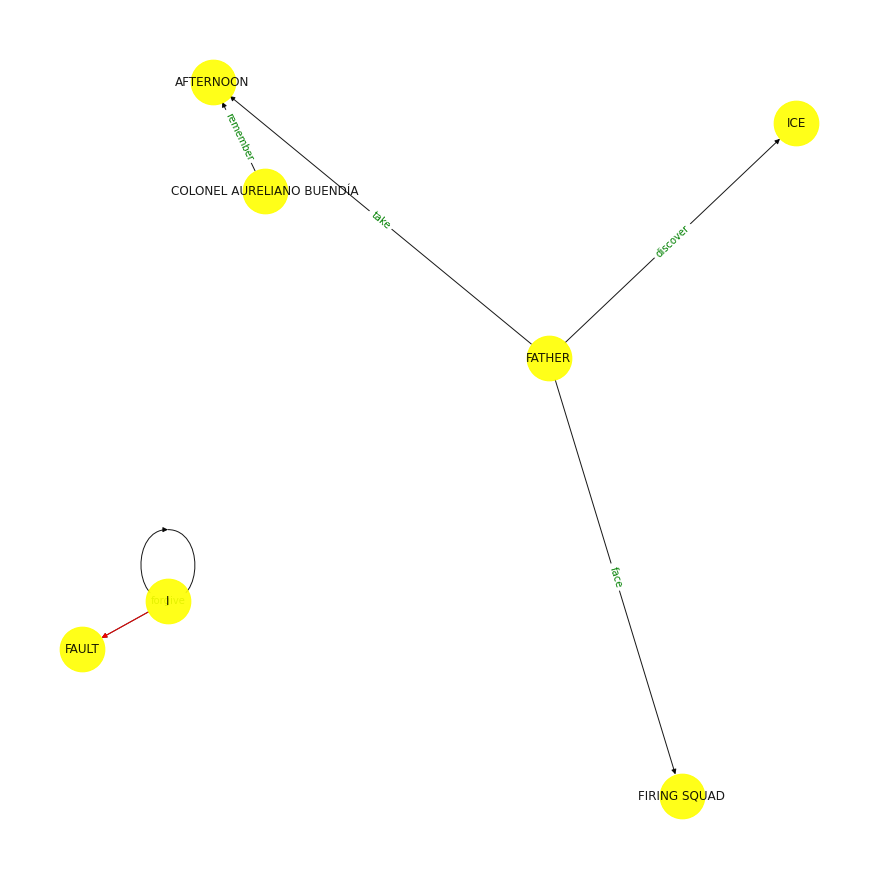

In [ ]:
kg.visualize()

#### Testing prompt_5

The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life


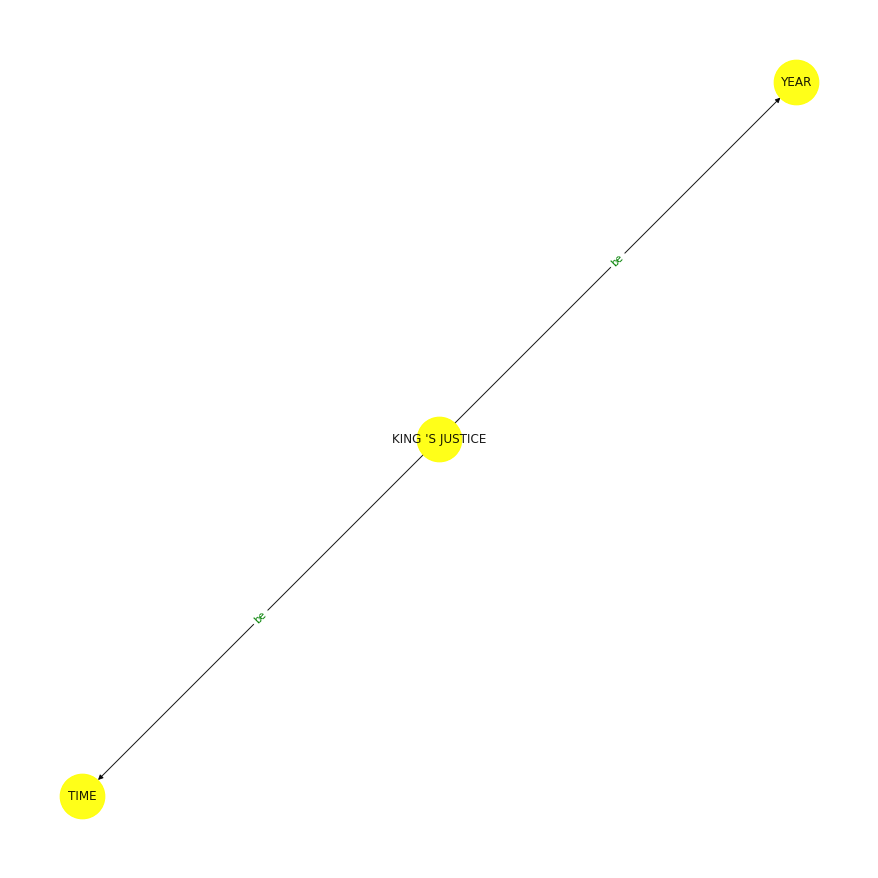

In [ ]:
kg = KnowledgeGraph(prompt_5)
print(prompt_5)
kg.visualize()

In [ ]:
default_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, default_scoring_fn, get_candidates__default)
print(default_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life.

Bran's heart was light, his head was full of hope. He was a man who loved his father, and he was a man who loved his brother, and he was also a man who loved the king. He had no fear for his own life, but for the lives of the people he would be riding to see justice done.

The sun came up over the horizon, and a light wind blew. The air was crisp, and there were few birds to be seen. The horses' hooves were sharp and cold on the hard, dry ground. The men of the household of Bran had not yet come to see Bran, and they rode hard, as they would have done in the old days. The men of the househol

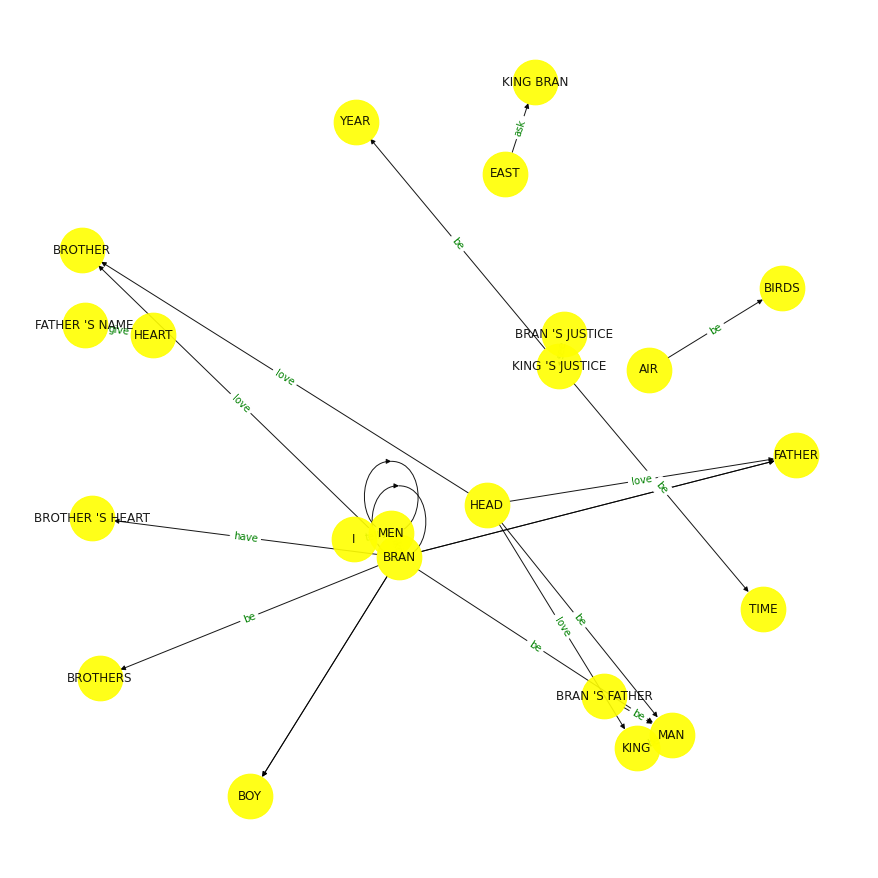

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life.

They rode through a landscape of rolling fields that had not been touched by man's hands for a thousand years, and the land had been turned into an unbroken wilderness, where there were no trees, no crops, no houses, no animals, no animals, and no people. There were no people anywhere. There were no people.

Bran had been born to a man with a name he could never remember, but he did remember the smell of the soil, and he remembered the sound of the wind, and he remembered the sound of the water. He remembered the taste of the earth, and he remembered the smell of the wind, and he remembered 

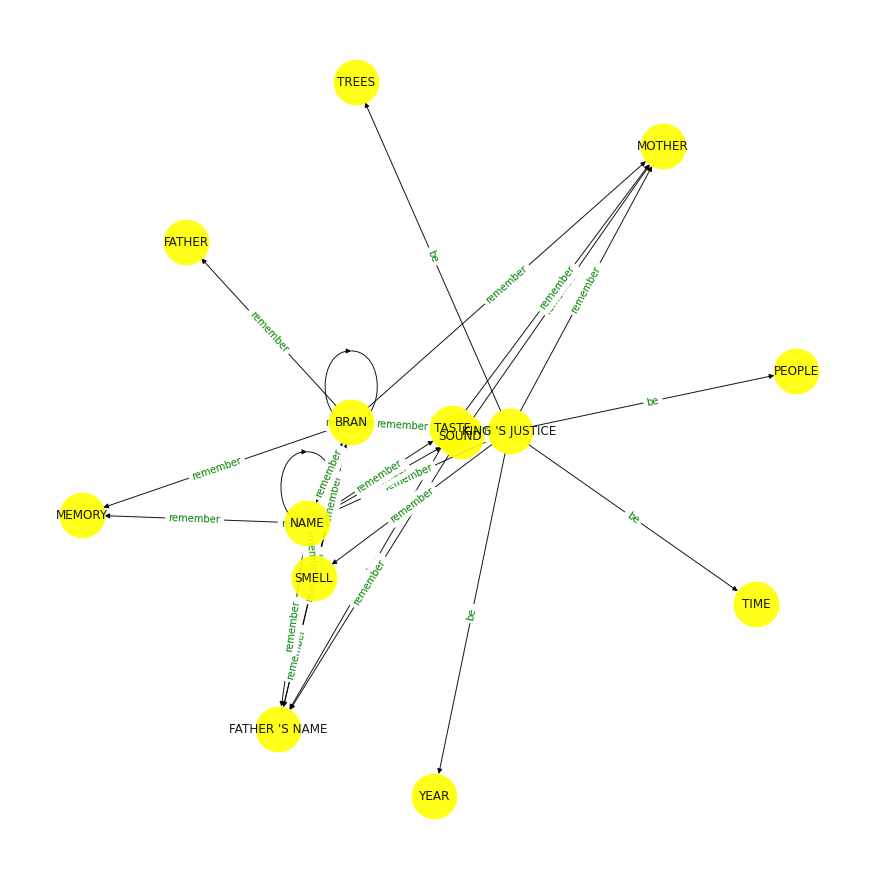

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life. The last time they had ridden this route had been when the king was young, and his horse was the only one they had been able to ride.

They were on the way, however, to the great hall of the king of Gwalchmai, a great lord who was not a lord of the north, nor was he a lord of the south. This was his home in the land of Gwalchmai, and his home was a place that Bran had never seen, a place that was far away from the lands of his people, and yet it was a place where he would be welcome, for Gwalchmai had been the home of his people for many generations. Bran was not certain that he would be welc

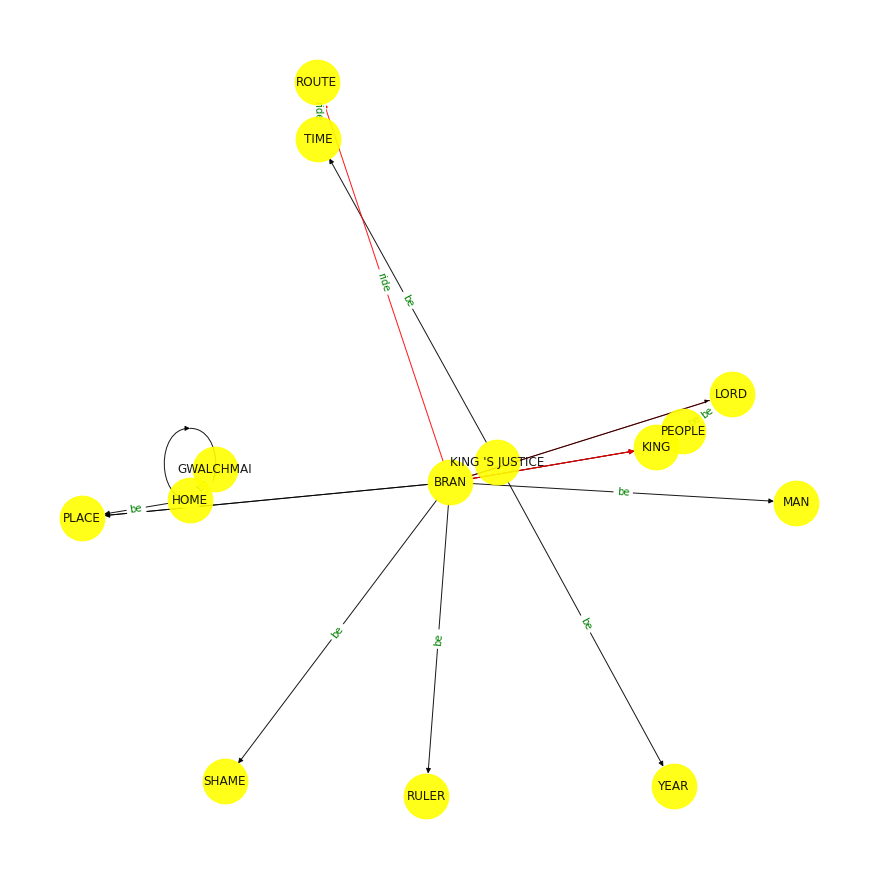

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life in King's Landing.

He had never before been among so many, and he had been told that this was the last time he would see his father alive. He would be the oldest among the men who had been taken to the dungeons to die. It was the end of the line for him.

Bran rode beside his father's bodyguard, and his eyes widened with horror. He had never known his father to look so old. His hair was white and thinning at the temples, and his skin was pale and lined. The eyes were the eyes of a man who had lost everything in the last year of his life, and Bran could not look at them without feeling his hea

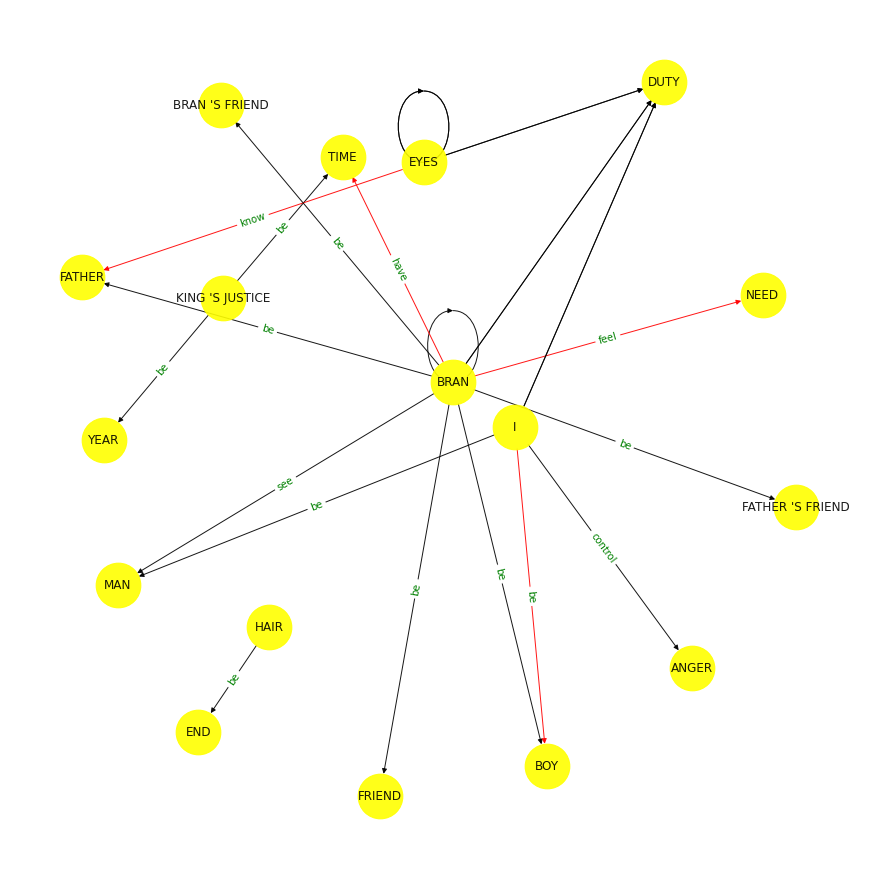

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__default)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life. The men who came to the gate with Bran were all his father's sons, and he knew he would be among them.

"I am Bran, son of Eddard," he called. "And I am the son of the king of the North. I am your father's youngest, and your mother's sister's child. I am the son of the king's oldest son, who is your father's youngest, and your mother's oldest. I am the son of the king's second eldest, who is your mother's youngest, and the youngest of your mother's sisters. I am the son of the king's third eldest, who is your mother's oldest, and your father's youngest. I am the son of the king's youngest, wh

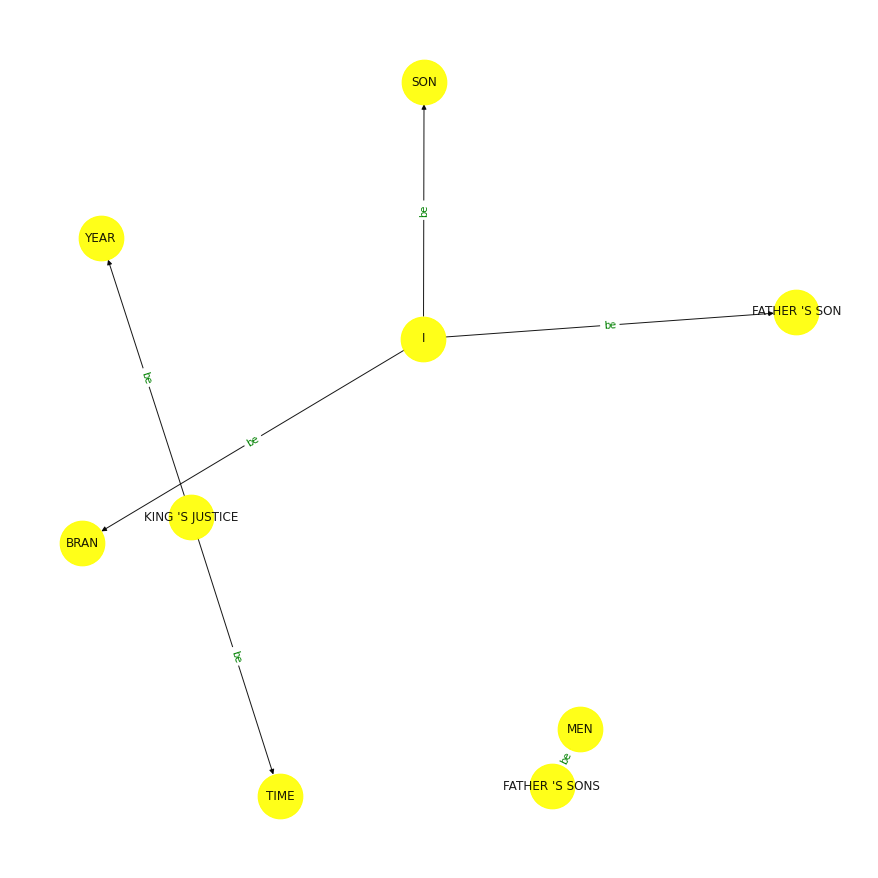

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life. The last year had been spent in the halls of Bran's lord father, and now he was a freeborn man. He was a young man.

"My lord Bran," said the man who rode before him. "The king's justice has been done and is being carried to the hall where it will be judged, and you will see it. You must ride with me and see it."

"Yes, my lord," said Bran.

The man led them through the streets of the city to a large building where a large, square room was set aside for the king's judgment. There was a bench, and a bench was placed for him to sit on. There was a bench of stone for him to sit on. There was a t

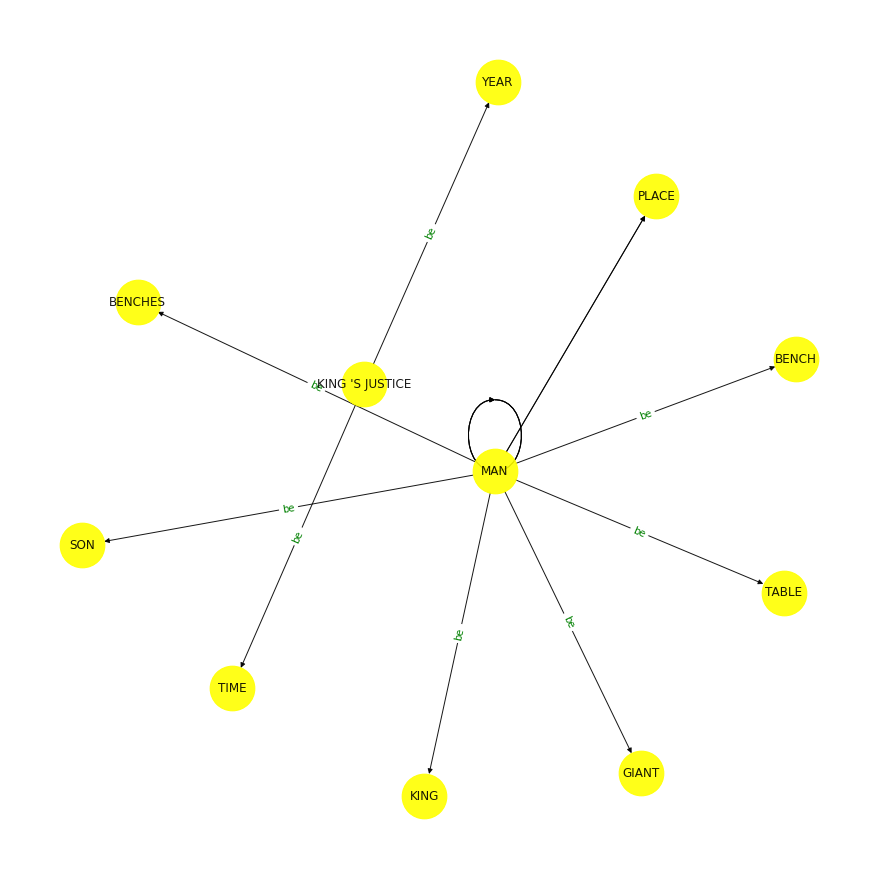

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life. The king's justice, as he called it, was a long and difficult trial, and the king's sons were not to be allowed to witness it.

The first to ride up to Bran was his own brother Bran. He rode in silence, his head lowered, and he rode slowly, his head down. He looked at Bran, and Bran looked at Bran, and Bran knew that the king's sons were about to witness the execution of a young man who had been a friend to his brothers and a trusted advisor to the king.

The king's justice, as he called it, was a long and difficult trial. Bran knew it, but his brother Bran did not yet know it for he rode slo

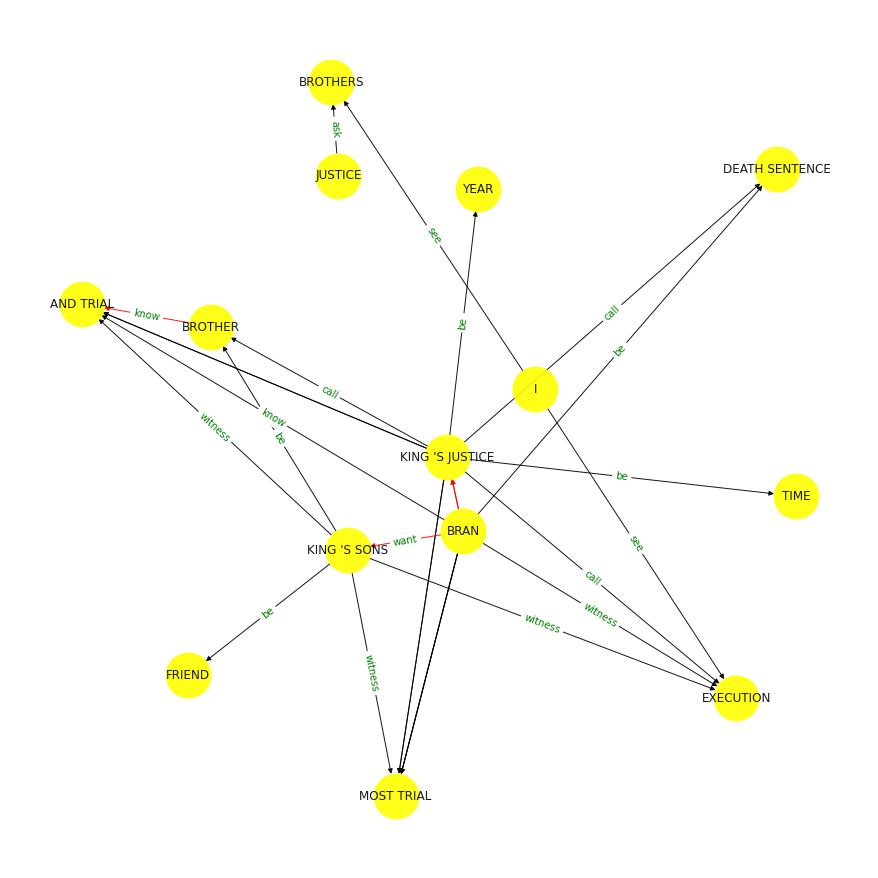

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life, and it was a time of great change for his people. For the past year they had been living in fear, waiting for the end of the world, and now they were about to see it. The end was coming.

Bran's brothers rode beside him, and they were as nervous as he was. The last of the summer was over, and the end was near. It was a time of great change for the whole of their people, and it was a time that they had never seen before. The summer was over; the end was coming; and they had never known anything else. It was a time that was to change them, and they knew it was a time that was to change them. Th

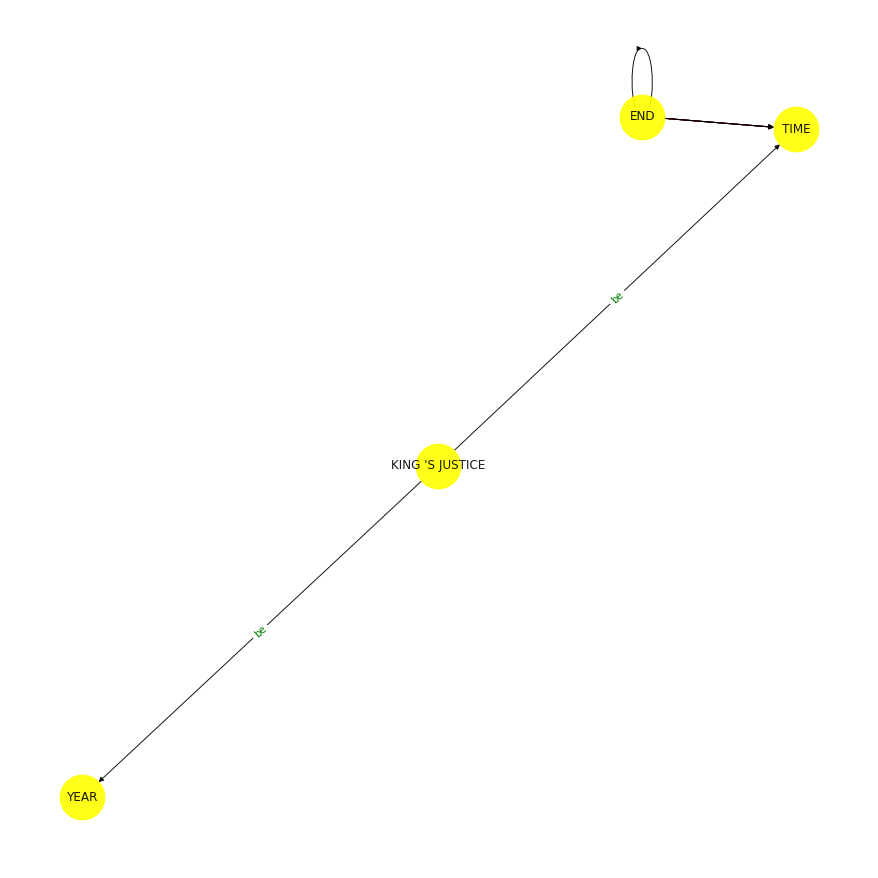

In [ ]:
kg.visualize()

In [ ]:
kg_scored_story, kg = generate_story(model, model_max, tokenizer, prompt_5, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__all)
print(kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-en

The morning had dawned clear and cold, with a crispness that hinted at the end of summer. They set forth at daybreak to see a man beheaded, twenty in all, and Bran rode among them, nervous with excitement. This was the first time he had been deemed old enough to go with his lord father and his brothers to see the king's justice done. It was the ninth year of summer, and the seventh of Bran's life.

The sun was high, and the day was fair. Bran was riding on a fine horse, a gray mare, and he was proud of her. She was a fine mare, and her hooves made a pleasing sound. He had been told that the horses that were used in the king's court were not good. The best were not used at all, but he had been told that Bran would like to ride one of them.

"I will ride a gray mare," Bran had said. "I will ride the finest gray horse in the land."

"I know," the king's youngest son said, and Bran was proud of that, too, for it was true.

They set out early, for Bran's father had said that they should go 

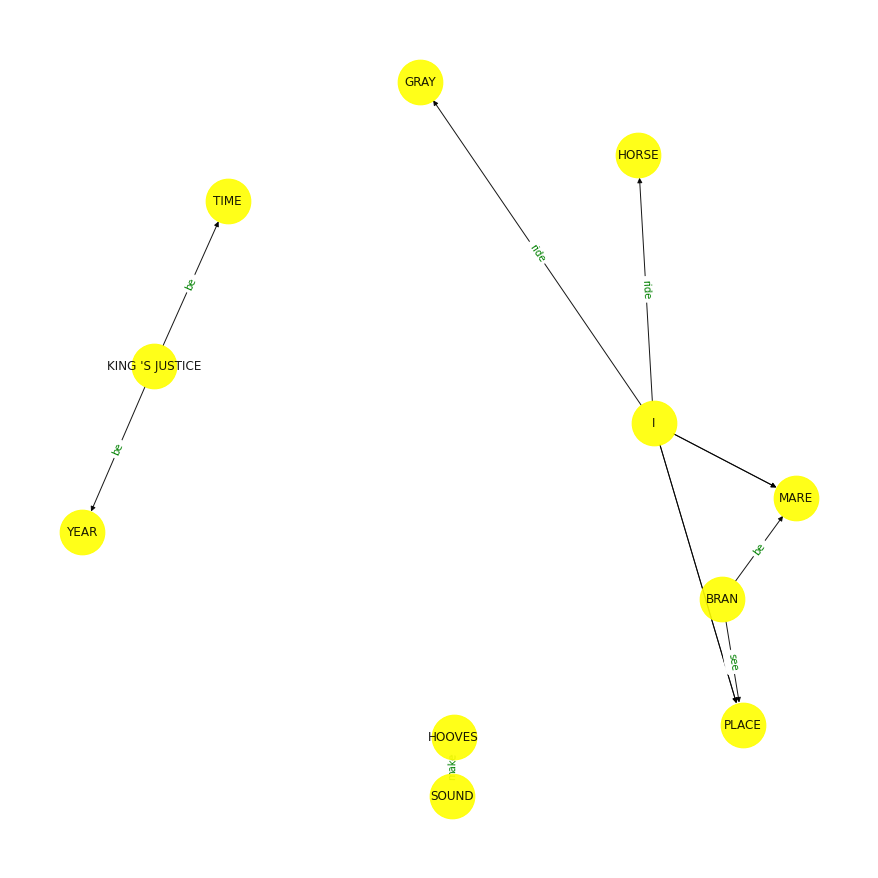

In [ ]:
kg.visualize()

### Testing scoring functions by different continuations
Here we test different continuations for a given prompt to see if the scoring functions perform as expected. The idea behind this test is that if the scoring function produces a higher score on lines that follow the text in the actual book, that implies that our design of the scoring function is borne out by real life stories and literature. Here the prompt is the opening paragraph in chapter 9 of _Anxious People_ by Fredrik Backman. The first continuation is the next line in the book after the prompt. Intuitively, we would expect this to have a high score. 

The second continuation is also a line taken from the same book but it appears towards the end of chapter 12. This should also have a moderate score as it is in the same setting but takes place a few pages later.

The third continuation is a random paragraph that we constructed by ourselves. While it is still in the same context as the prompt, we would intuitively assume this to have a low score and ideally, be rejected.

In [ ]:
# A paragraph from "Anxious People" by Fredrik Backman
prompt = 'The younger officer walks back to the interview room and puts the glass of water down on the table. '\
'The real estate agent looks at him, and thinks he looks like a person who\'s had his sense of humor amputated. '\
'Not that there\'s anything wrong with that.'

# Next line
continuation_1 = '"Thanks," she says hesitantly toward the glass of water she hadn\'t asked for. '\
'"I need to ask you a few more questions," the young officer says apologetically, and pulls out a crumpled sheet '\
'of paper. It looks like a child\'s drawing.'

# Line from a few pages later - same context
continuation_2 = 'The real estate agent can see how much this means to hum from the sadness in his eyes. '\
'Then he runs his fingers across the tabletop and adds with forced formality, "I have to remind you '\
'that everything you say during this interview is being recorded."'

# Random continuation - same context
continuation_3 = 'The interview did not go well. There was no new information that could be recovered. '\
'The police were clueless. Randy soon left and went back to his open-house showing. All clues were coming to '\
'a dead end for the police and they did not know where to look next.'

In [ ]:
kg = KnowledgeGraph(prompt)

In [ ]:
default_score = default_scoring_fn(prompt, kg, continuation_1)
score_1 = kg_scoring_fn(prompt, kg, continuation_1)
score_2 = kg_scoring_fn2(prompt, kg, continuation_1)
score_3 = kg_scoring_fn3(prompt, kg, continuation_1)
score_4 = kg_scoring_fn4(prompt, kg, continuation_1)

print('Score from default_scoring_fn: ', default_score)
print('Score from kg_scoring_fn: ', score_1)
print("Score from kg_scoring_fn2: ", score_2)
print("Score from kg_scoring_fn3: ", score_3)
print("Score from kg_scoring_fn4: ", score_4)


Score from default_scoring_fn:  1
Score from kg_scoring_fn:  -2
Score from kg_scoring_fn2:  1
Score from kg_scoring_fn3:  0.25
Score from kg_scoring_fn4:  0.5506953149031838


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
default_score = default_scoring_fn(prompt, kg, continuation_2)
score_1 = kg_scoring_fn(prompt, kg, continuation_2)
score_2 = kg_scoring_fn2(prompt, kg, continuation_2)
score_3 = kg_scoring_fn3(prompt, kg, continuation_2)
score_4 = kg_scoring_fn4(prompt, kg, continuation_2)

print('Score from default_scoring_fn: ', default_score)
print('Score from kg_scoring_fn: ', score_1)
print("Score from kg_scoring_fn2: ", score_2)
print("Score from kg_scoring_fn3: ", score_3)
print("Score from kg_scoring_fn4: ", score_4)


Score from default_scoring_fn:  1
Score from kg_scoring_fn:  -1
Score from kg_scoring_fn2:  1
Score from kg_scoring_fn3:  0.2857142857142857
Score from kg_scoring_fn4:  0.39011264866539486


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
default_score = default_scoring_fn(prompt, kg, continuation_3)
score_1 = kg_scoring_fn(prompt, kg, continuation_3)
score_2 = kg_scoring_fn2(prompt, kg, continuation_3)
score_3 = kg_scoring_fn3(prompt, kg, continuation_3)
score_4 = kg_scoring_fn4(prompt, kg, continuation_3)

print('Score from default_scoring_fn: ', default_score)
print('Score from kg_scoring_fn: ', score_1)
print("Score from kg_scoring_fn2: ", score_2)
print("Score from kg_scoring_fn3: ", score_3)
print("Score from kg_scoring_fn4: ", score_4)


Score from default_scoring_fn:  1
Score from kg_scoring_fn:  -2
Score from kg_scoring_fn2:  0
Score from kg_scoring_fn3:  0.0
Score from kg_scoring_fn4:  0


# Option 2 - Masking 

In [ ]:
pip install transformers

In [ ]:
from transformers import pipeline

In [ ]:
unmasker = pipeline('fill-mask', model='bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
unmasker("Hello I'm a [MASK] model.")

[{'score': 0.10731077939271927,
  'sequence': "hello i'm a fashion model.",
  'token': 4827,
  'token_str': 'fashion'},
 {'score': 0.0877445638179779,
  'sequence': "hello i'm a role model.",
  'token': 2535,
  'token_str': 'role'},
 {'score': 0.05338413640856743,
  'sequence': "hello i'm a new model.",
  'token': 2047,
  'token_str': 'new'},
 {'score': 0.046672213822603226,
  'sequence': "hello i'm a super model.",
  'token': 3565,
  'token_str': 'super'},
 {'score': 0.027095887809991837,
  'sequence': "hello i'm a fine model.",
  'token': 2986,
  'token_str': 'fine'}]

In [ ]:
prompt_7 = 'Harry Potter and the Sorcerer’s Stone' \
'CHAPTER ONE' \
'THE BOY WHO LIVED' \
'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say' \
'that they were perfectly normal, thank you very much. They were the last'\
'people you’d expect to be involved in anything strange or mysterious,' \
'because they just didn’t hold with such nonsense.' \
'Mr. Dursley was the director of a firm called Grunnings, which made' \
'drills. He was a big, beefy man with hardly any neck, although he did' \
'have a very large mustache. Mrs. Dursley was thin and blonde and had' \
'nearly twice the usual amount of neck, which came in very useful as she' \
'spent so much of her time craning over garden fences, spying on the' \
'neighbors. The Dursleys had a small son called Dudley and in their' \
'opinion there was no finer boy anywhere.' \
'The Dursleys had everything they wanted, but they also had a secret, and' \
'their greatest fear was that somebody would discover it. They didn’t' \
'think they could bear it if anyone found out about the Potters. Mrs.' \
'Potter was Mrs. Dursley’s sister, but they hadn’t met for several years;' \
'in fact, Mrs. Dursley pretended she didn’t have a sister, because her' \
'sister and her good-for-nothing husband were as unDursleyish as it was' \
'possible to be. The Dursleys shuddered to think what the neighbors would' \
'say if the Potters arrived in the street. The Dursleys knew that the' \
'Potters had a small son, too, but they had never even seen him. This boy' \
'was another good reason for keeping the Potters away; they didn’t want' \
'Dudley mixing with a child like that.'\
'When Mr. and Mrs. Dursley woke up on the dull, gray Tuesday our story' \
'starts, there was nothing about the cloudy sky outside to suggest that' \
'strange and mysterious things would soon be happening all over the' \
'country. Mr. Dursley hummed as he picked out his most boring tie for' \
'work, and Mrs. Dursley gossiped away happily as she wrestled a screaming' \
'Dudley into his high chair.' \
'None of them noticed a large, tawny owl flutter past the window.' \
'At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs.' \
'Dursley on the cheek, and tried to kiss Dudley good-bye but missed,' \
'because Dudley was now having a tantrum and throwing his cereal at the' \
'walls. "Little tyke," chortled Mr. Dursley as he left the house. He got' \
'into his car and backed out of number four’s drive.' \

In [ ]:
def constructing_masked_svo_tuple_from_kg(prompt):
  prompt_kg = create_dataframe_from_prompt(prompt)
  prompt_sub = prompt_kg[['Subject', 'Object']].values.flatten().tolist()
  prompt_obj = prompt_kg[['Object']].values.flatten().tolist()
  prompt_verb = prompt_kg[['Verb']].values.flatten().tolist()
  masked_svo = ""
  for sub, verb, obj in zip(prompt_sub, prompt_verb, prompt_obj):
    new_sentence = sub.lower() + " [MASK] " + obj.lower()
    masked_svo = masked_svo + " " + new_sentence + "."
  return masked_svo

In [ ]:
masked_tuple = constructing_masked_svo_tuple_from_kg(prompt_7)
masked_tuple

' mrs. dursley [MASK] .  [MASK] lastpeople. mrs. dursley [MASK] director. lastpeople [MASK] , man. mr . dursley [MASK] very mustache. director [MASK] son. mr . dursley [MASK] boy. , man [MASK] boy. mr . dursley [MASK] boy. very mustache [MASK] boy. dursleys [MASK] mrs. dursley ’s sister. son [MASK] sister. dursleys [MASK] sister. boy [MASK] son. dursleys [MASK] son. boy [MASK] reason. secret , fear [MASK] potters. boy [MASK] wantdudley. secret , fear [MASK] wantdudley. boy [MASK] wantdudley. mrs . potter [MASK] thatstrange. mrs. dursley ’s sister [MASK] things. mrs. dursley [MASK] thatstrange. sister [MASK] things. neighbors [MASK] most tie forwork. sister [MASK] screamingdudley. thepotters [MASK] briefcase. son [MASK] mrs . dursley. thepotters [MASK] dudley. son [MASK] tantrum. thepotters [MASK] cereal. reason [MASK] mr. dursley. thepotters [MASK] house. potters [MASK] car. thepotters [MASK] drive.'

In [ ]:
from transformers.pipelines.base import PipelineException
def generate_sentences_using_masking(prompt):
  masked_svo = constructing_masked_svo_tuple_from_kg(prompt)
  sentences = masked_svo.split(".")
  new_prompt = ""
  new_text = ""
  if sentences[-1] == "":
    sentences.pop()
  for sentence in sentences:
    try:
      result = unmasker(sentence)
    except PipelineException:
      continue
    for val in result:
      if len(val['token_str']) > 1:
        new_text = val['sequence']
        break
    new_prompt = new_prompt + new_text + "." + " "
  return new_prompt

In [ ]:
new_prompt = generate_sentences_using_masking(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


. the lastpeople. dursley was director. lastpeople dead, man. dursley is very mustache. director and son. dursley school boy. , man and boy. dursley school boy. very mustached boy. dursleys as mrs. son and sister. son and sister. boy and son. dursleys and son. boy did reason. secret, fear the potters. boy is wantdudley. secret, fear and wantdudley. boy is wantdudley. potter at thatstrange. dursley ’ s sister knows things. dursley and thatstrange. sisterly things. neighbors are most tie forwork. sister of screamingdudley. thepotters briefcase briefcase. son of mrs. thepotters of dudley. son of tantrum. thepotters breakfast cereal. thepotters breakfast cereal. thepotters club house. potters oil car. thepotters flash drive.  
 ** _The Potters_ by John le Carré, published in the_ Sunday Times_, April 30, 2006.

 ** **

The Potters were a British band that formed in the mid-1960s. Their music has a distinctive sound, which has become known as 'potato music.' They were one of the most succes

In [ ]:
new_prompt = generate_sentences_using_masking(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


. the lastpeople. dursley was director. lastpeople dead, man. dursley is very mustache. director and son. dursley school boy. , man and boy. dursley school boy. very mustached boy. dursleys as mrs. son and sister. son and sister. boy and son. dursleys and son. boy did reason. secret, fear the potters. boy is wantdudley. secret, fear and wantdudley. boy is wantdudley. potter at thatstrange. dursley ’ s sister knows things. dursley and thatstrange. sisterly things. neighbors are most tie forwork. sister of screamingdudley. thepotters briefcase briefcase. son of mrs. thepotters of dudley. son of tantrum. thepotters breakfast cereal. thepotters breakfast cereal. thepotters club house. potters oil car. thepotters flash drive. ian. thepotters flash drive. thepotters flash drive. thepotters flash drive. thepotters flash drive. thepotters flossing. thepotters flossing. dudsley ’ s sister. thepotters flossing. dudsley and thepotters flossing. thepotters flossing. dudsley and dudsley. thepotters

In [ ]:
new_prompt = generate_sentences_using_masking(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


. the lastpeople. dursley was director. lastpeople dead, man. dursley is very mustache. director and son. dursley school boy. , man and boy. dursley school boy. very mustached boy. dursleys as mrs. son and sister. son and sister. boy and son. dursleys and son. boy did reason. secret, fear the potters. boy is wantdudley. secret, fear and wantdudley. boy is wantdudley. potter at thatstrange. dursley ’ s sister knows things. dursley and thatstrange. sisterly things. neighbors are most tie forwork. sister of screamingdudley. thepotters briefcase briefcase. son of mrs. thepotters of dudley. son of tantrum. thepotters breakfast cereal. thepotters breakfast cereal. thepotters club house. potters oil car. thepotters flash drive.  
thepotters flash drive. thepotters jim. thepotters jim. jim is the potters jim. jim jim is the potters jim. jim jim jim jim jim jim jim jim jim jim jim jim jim jim is the potters jim jim jim the potters jim jim jim jim jim jim jim jim jim jim jim jim jim jim jim is t

In [ ]:
new_prompt = generate_sentences_using_masking(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


. the lastpeople. dursley was director. lastpeople dead, man. dursley is very mustache. director and son. dursley school boy. , man and boy. dursley school boy. very mustached boy. dursleys as mrs. son and sister. son and sister. boy and son. dursleys and son. boy did reason. secret, fear the potters. boy is wantdudley. secret, fear and wantdudley. boy is wantdudley. potter at thatstrange. dursley ’ s sister knows things. dursley and thatstrange. sisterly things. neighbors are most tie forwork. sister of screamingdudley. thepotters briefcase briefcase. son of mrs. thepotters of dudley. son of tantrum. thepotters breakfast cereal. thepotters breakfast cereal. thepotters club house. potters oil car. thepotters flash drive. _________________

I am so excited that my favorite teacher in school, Mrs. Dursley, is teaching my class again. She is a wonderful teacher who is so kind. She has been a part of my life since I was little. She always made me smile and she always made me feel special. 

In [ ]:
def constructing_masked_svo_tuple_from_kg_with_verbnetid(prompt):
  prompt_kg = create_dataframe_from_prompt(prompt)
  prompt_sub = prompt_kg[['Subject', 'Object']].values.flatten().tolist()
  prompt_obj = prompt_kg[['Object']].values.flatten().tolist()
  prompt_verb = prompt_kg[['Verb']].values.flatten().tolist()
  kg_verbnetid = prompt_kg[['VerbNetClassId']].values.flatten().tolist()
  masked_svo = ""
  for sub, verb, obj in zip(prompt_sub, prompt_verb, prompt_obj):
    new_sentence = sub.lower() + " [MASK] " + obj.lower()
    masked_svo = masked_svo + " " + new_sentence + "."
  return masked_svo, kg_verbnetid, prompt_verb

In [ ]:
def check_if_verb_classids_are_similar(unmaskedverb, verb):
  for verb_classid in vn.classids(verb):
    for unmaskedverb_classid in vn.classids(unmaskedverb):
      split1 = verb_classid.split("-")[0]
      split2 = unmaskedverb_classid.split("-")[0]
      if split1 == split2:
        return True 
  return False

In [ ]:
from tensorflow.python.types.core import Value
from transformers.pipelines.base import PipelineException
def generate_sentences_using_masking_with_verbnetid(prompt):
  masked_svo, kg_verbnetid, prompt_verb = constructing_masked_svo_tuple_from_kg_with_verbnetid(prompt)
  sentences = masked_svo.split(".")
  new_prompt = ""
  new_text = ""
  ans = ""
  if sentences[-1] == "":
    sentences.pop()
  for sentence, verbnetid, verb in zip(sentences, kg_verbnetid, prompt_verb):
    split_sentence = sentence.split(" ")
    try:
      modified_verb = vn.lemmas(verbnetid)[0]
      #print (modified_verb)
      new_text = [modified_verb if i=='[MASK]' else i for i in split_sentence]
      new_text = " ".join(new_text)
      new_prompt = new_prompt + new_text + "." + " "
    except ValueError:
      new_text = [verb if i=='[MASK]' else i for i in split_sentence]
      new_text = " ".join(new_text)
      new_prompt = new_prompt + new_text + "." + " "
  return new_prompt

In [ ]:
new_prompt = generate_sentences_using_masking_with_verbnetid(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 mrs.  dursley be .   be lastpeople.  mrs.  dursley didhave director.  lastpeople have , man.  mr .  dursley have very mustache.  director discover son.  mr .  dursley be boy.  , man have boy.  mr .  dursley have boy.  very mustache detect boy.  dursleys boywa mrs.  dursley ’s sister.  son do sister.  dursleys be sister.  boy be son.  dursleys assert son.  boy assert reason.  secret , fear assert potters.  boy assert wantdudley.  secret , fear chew wantdudley.  boy argue wantdudley.  mrs .  potter chew thatstrange.  mrs.  dursley ’s sister have things.  mrs.  dursley beam thatstrange.  sister desert things.  neighbors gotinto most tie forwork.  sister back screamingdudley.  mrs. dursley be sister.

A:

This is a very good puzzle.  The answer may be a bit more complicated than it looks at a glance, because the clues are all very similar. But the clues do provide hints, which are worth following. 
The first clue says:

The boy, son, dursleys

Which means that the boy is the boy in this p

In [ ]:
new_prompt = generate_sentences_using_masking_with_verbnetid(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 mrs.  dursley be .   be lastpeople.  mrs.  dursley didhave director.  lastpeople have , man.  mr .  dursley have very mustache.  director discover son.  mr .  dursley be boy.  , man have boy.  mr .  dursley have boy.  very mustache detect boy.  dursleys boywa mrs.  dursley ’s sister.  son do sister.  dursleys be sister.  boy be son.  dursleys assert son.  boy assert reason.  secret , fear assert potters.  boy assert wantdudley.  secret , fear chew wantdudley.  boy argue wantdudley.  mrs .  potter chew thatstrange.  mrs.  dursley ’s sister have things.  mrs.  dursley beam thatstrange.  sister desert things.  neighbors gotinto most tie forwork.  sister back screamingdudley.  secret, fear chew wantdudley.  sister be mad.  sister be mad.  sister be afraid.  secret, fear chew thatstrange.  mr.  dursley ’s sister have boy.  dursleys be boy.  son do thatstrange.  boy assert dudley.  boy assert dudley.  boy assert dudley.  son assert dudley.  son assert dudley.  son assert dudley.  son assert

In [ ]:
new_prompt = generate_sentences_using_masking_with_verbnetid(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn2, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 mrs.  dursley be .   be lastpeople.  mrs.  dursley didhave director.  lastpeople have , man.  mr .  dursley have very mustache.  director discover son.  mr .  dursley be boy.  , man have boy.  mr .  dursley have boy.  very mustache detect boy.  dursleys boywa mrs.  dursley ’s sister.  son do sister.  dursleys be sister.  boy be son.  dursleys assert son.  boy assert reason.  secret , fear assert potters.  boy assert wantdudley.  secret , fear chew wantdudley.  boy argue wantdudley.  mrs .  potter chew thatstrange.  mrs.  dursley ’s sister have things.  mrs.  dursley beam thatstrange.  sister desert things.  neighbors gotinto most tie forwork.  sister back screamingdudley.  sister be afraid dudley.  mr.  dursley be boy.  mrs.  dursley ’s sister be girl.  sister have boy.  mr.  dursley have boys.  mrs.  dursley be son.  mr.  dursley have son.  mr.  dursley have son.  mrs.  dursley ’s sister be boy.  mr.  dursley have boys.  mrs.  dursley ’s sister be girl.  mr.  dursley have boys.  mrs.

In [ ]:
new_prompt = generate_sentences_using_masking_with_verbnetid(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn3, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 mrs.  dursley be .   be lastpeople.  mrs.  dursley didhave director.  lastpeople have , man.  mr .  dursley have very mustache.  director discover son.  mr .  dursley be boy.  , man have boy.  mr .  dursley have boy.  very mustache detect boy.  dursleys boywa mrs.  dursley ’s sister.  son do sister.  dursleys be sister.  boy be son.  dursleys assert son.  boy assert reason.  secret , fear assert potters.  boy assert wantdudley.  secret , fear chew wantdudley.  boy argue wantdudley.  mrs .  potter chew thatstrange.  mrs.  dursley ’s sister have things.  mrs.  dursley beam thatstrange.  sister desert things.  neighbors gotinto most tie forwork.  sister back screamingdudley.  sister ’s sister have things.  mrs.  potter have things.  mrs.  potter have thatstrange.  sister desert thatstrange.  sister desert mr.  dursley ’s sister.  mrs.  boy have things.  mrs.  boy have thatstrange.  neighbor gotinto most tie forwork.  sister ’s sister have thatstrange.  neighbor gotinto thatstrange.  sist

In [ ]:
new_prompt = generate_sentences_using_masking_with_verbnetid(prompt_7)
kg_scored_story, kg = generate_story(model, model_max, tokenizer, new_prompt, k, num_candidates, target_length, continuation_length, kg_scoring_fn4, get_candidates__default)
print (kg_scored_story)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 mrs.  dursley be .   be lastpeople.  mrs.  dursley didhave director.  lastpeople have , man.  mr .  dursley have very mustache.  director discover son.  mr .  dursley be boy.  , man have boy.  mr .  dursley have boy.  very mustache detect boy.  dursleys boywa mrs.  dursley ’s sister.  son do sister.  dursleys be sister.  boy be son.  dursleys assert son.  boy assert reason.  secret , fear assert potters.  boy assert wantdudley.  secret , fear chew wantdudley.  boy argue wantdudley.  mrs .  potter chew thatstrange.  mrs.  dursley ’s sister have things.  mrs.  dursley beam thatstrange.  sister desert things.  neighbors gotinto most tie forwork.  sister back screamingdudley.  neighbors have to go.  mrs.  dursley be sister to mrs.  dursley ’s brother, and she is mad.  sister ’s brother do not like sister.  mrs.  dursley have to go to school.  dursley ’s brother do not know mrs.  dursleys sister.  dursley have to go to school.

The first sentence of this example is "dursley ’s brother do n

# Deprecated

In [ ]:
import math
# Generate a story with length target_length, continuation_length at a time.
def generate_story__old(model, model_max, tokenizer, prompt, k, num_candidates, scoring_fn, target_length, continuation_length):
  # Use the generate_candidate_sentences iteratively to generate longer sequences 

  full_generated_text = prompt
  kg = KnowledgeGraph(prompt)
  full_generated_text_tokens = tokenizer.encode(full_generated_text, return_tensors='pt').to('cuda')
  full_length = len(full_generated_text_tokens[0])

  current_prompt = full_generated_text

  while full_length < target_length:
    # Step 1: Check the length of the current prompt, truncate it if it will result in text that is be longer than max length threshold. 
    # Make sure your new prompt substring includes the end of the prompt so the model can correctly produce a continuation. 
    if full_length < (model_max - continuation_length):
      current_prompt = full_generated_text
    else:
      current_prompt_tokens = full_generated_text_tokens[0][-(model_max - continuation_length):]
      current_prompt = tokenizer.decode(current_prompt_tokens)
  
    # Step 2: Call the generate_candidate_sentences with the new substring prompt.
    max_new_tokens = math.floor(min(continuation_length, target_length - full_length))
    candidates = generate_candidate_sentences(model, tokenizer, current_prompt, k, num_candidates, max_new_tokens)
    # Select continuation using the full text as the input.
    new_text = select_candidate_continuation(full_generated_text, kg, candidates, scoring_fn)

    # Step 3: Update the full_generated text to include the full prompt and the newly generated content.
    full_generated_text += new_text
    full_generated_text_tokens = tokenizer.encode(full_generated_text, return_tensors='pt').to('cuda')
    full_length = len(full_generated_text_tokens[0])
    kg.append(new_text)

  return full_generated_text, kg